In [1]:
# install package for displaying animation
!pip install JSAnimation

# custom utilies for displaying animation, collecting rollouts and more
import pong_utils

%matplotlib inline

# check which device is being used.
# I recommend disabling gpu until you've made sure that the code runs
device = pong_utils.device
print("using device: ", device)

You should consider upgrading via the '/home/jeyhoon/git/deep-reinforcement-learning/drlnd/bin/python -m pip install --upgrade pip' command.
using device:  cuda:0


In [2]:
# render ai gym environment
import gym
import time

# PongDeterministic does not contain random frameskip
# so is faster to train than the vanilla Pong-v4 environment
env = gym.make('PongDeterministic-v4')

print("List of available actions: ", env.unwrapped.get_action_meanings())

# we will only use the actions 'RIGHTFIRE' = 4 and 'LEFTFIRE" = 5
# the 'FIRE' part ensures that the game starts again after losing a life
# the actions are hard-coded in pong_utils.py

List of available actions:  ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


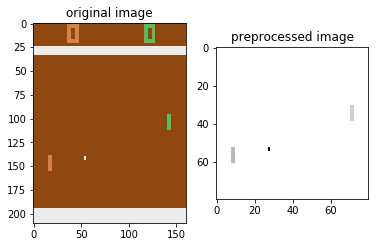

In [3]:
import matplotlib
import matplotlib.pyplot as plt

# show what a preprocessed image looks like
env.reset()
_, _, _, _ = env.step(0)
# get a frame after 20 steps
for _ in range(20):
    frame, _, _, _ = env.step(1)

plt.subplot(1,2,1)
plt.imshow(frame)
plt.title('original image')

plt.subplot(1,2,2)
plt.title('preprocessed image')

# 80 x 80 black and white image
plt.imshow(pong_utils.preprocess_single(frame), cmap='Greys')
plt.show()

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# set up a convolutional neural net
# the output is the probability of moving right
# P(left) = 1-P(right)
RIGHT = 4
LEFT = 5

class Policy(nn.Module):

    def __init__(self):
        super(Policy, self).__init__()

        # 80x80 to outputsize x outputsize
        # outputsize = (inputsize - kernel_size + stride)/stride
        # (round up if not an integer)

        # # output = 20x20 here
        # self.conv_1 = nn.Conv2d(2, 16, kernel_size=8, stride=4)
        # self.conv_2 = nn.Conv2d(16, 32, kernel_size=4, stride=2)
        # self.conv_3 = nn.Conv2d(32, 32, kernel_size=3, stride=1)
        # self.size=6*6*32
        #
        # # 1 fully connected layer
        # self.fc_1 = nn.Linear(self.size, 128)
        # self.fc_2 = nn.Linear(128, 1)
        # self.sig = nn.Sigmoid()

        self.conv1 = nn.Conv2d(2, 4, kernel_size=6, stride=2, bias=False)
        # 38x38x4 to 9x9x32
        self.conv2 = nn.Conv2d(4, 16, kernel_size=6, stride=4)
        self.size = 9 * 9 * 16

        # two fully connected layer
        self.fc1 = nn.Linear(self.size, 256)
        self.fc2 = nn.Linear(256, 1)

        # Sigmoid to
        self.sig = nn.Sigmoid()

    def forward(self, x):

        # x = F.relu(self.conv_1(x))
        # x = F.relu(self.conv_2(x))
        # x = F.relu(self.conv_3(x))
        # # flatten the tensor
        # x = x.view(-1,self.size)
        # x = F.relu(self.fc_1(x))
        # return self.sig(self.fc_2(x))

        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(-1, self.size)
        x = F.relu(self.fc1(x))
        return self.sig(self.fc2(x))

    def full_pass(self, state):
        prob = self.forward(state)
        logits = torch.cat([prob, 1-prob], dim=-1)
        dist = torch.distributions.Categorical(logits=logits)
        action = dist.sample()
        logpa = dist.log_prob(action).unsqueeze(-1)
        entropy = dist.entropy().unsqueeze(-1)

        action = action.cpu().detach().numpy() + RIGHT
        return action, logpa, entropy

    def select_action(self, state):
        prob = self.forward(state)
        logits = torch.cat([prob, 1-prob], dim=-1)
        dist = torch.distributions.Categorical(logits=logits)
        action = dist.sample()
        action = action.cpu().detach().numpy() + RIGHT
        return action

    def select_greedy_action(self, state):
        prob = self.forward(state)
        logits = torch.cat([prob, 1-prob], dim=-1)
        return np.argmax(logits.detach().numpy())

# use your own policy!
policy=Policy().to(device)

# we use the adam optimizer with learning rate 2e-4
# optim.SGD is also possible
import torch.optim as optim
optimizer = optim.Adam(policy.parameters(), lr=2e-4)


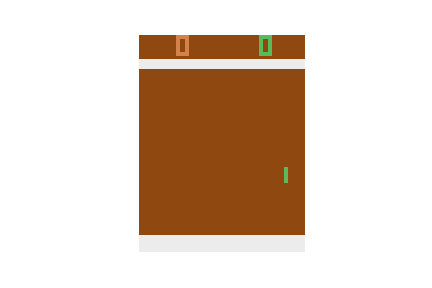
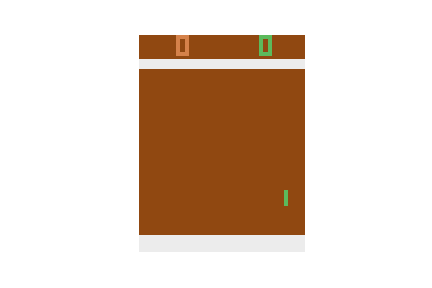
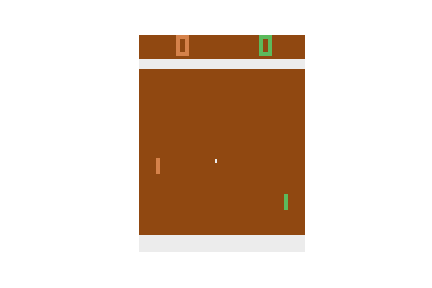
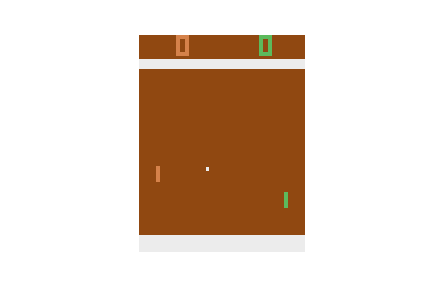
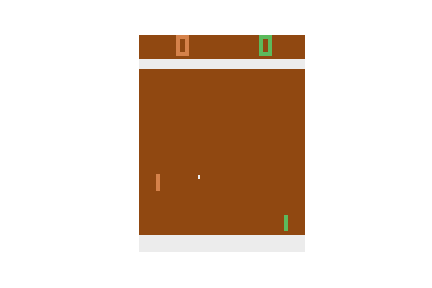
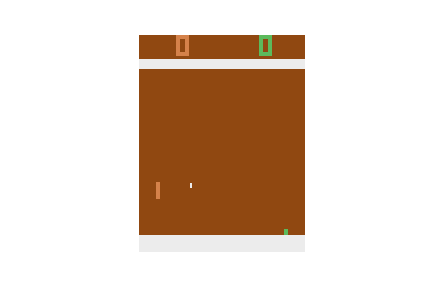
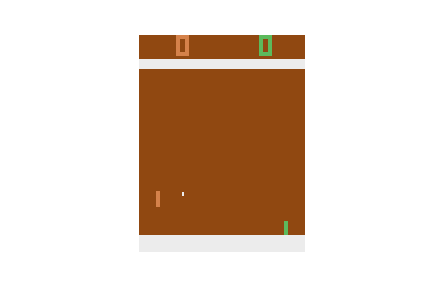
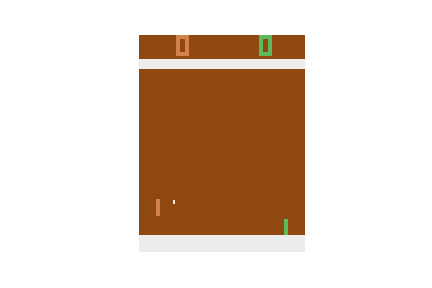
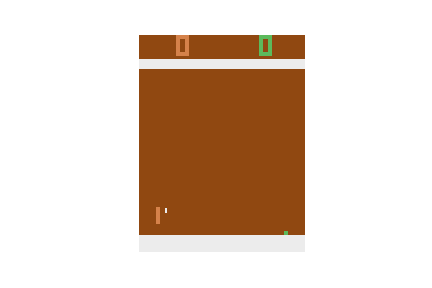
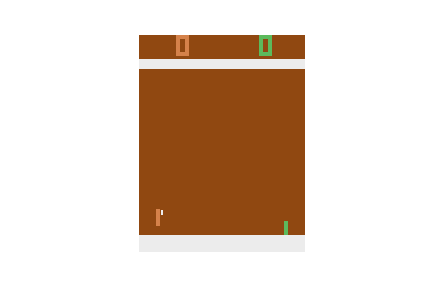
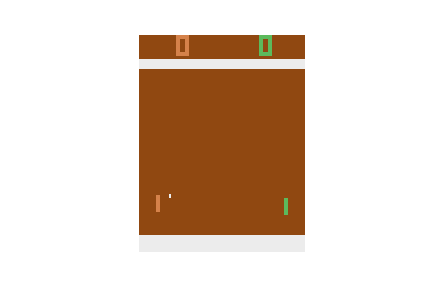
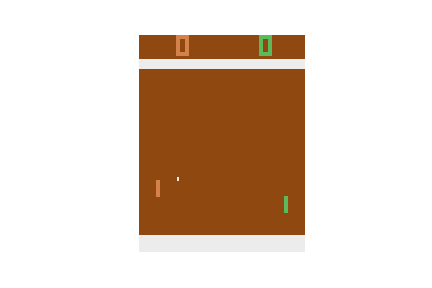
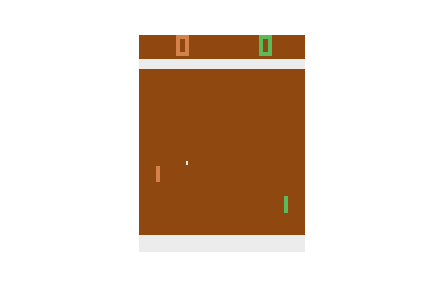
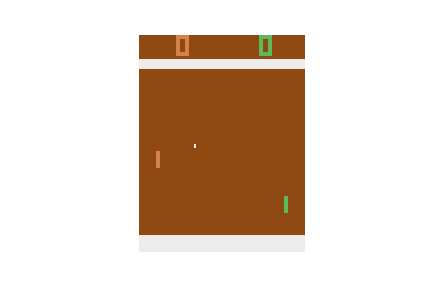
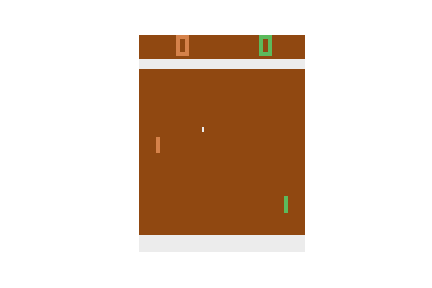
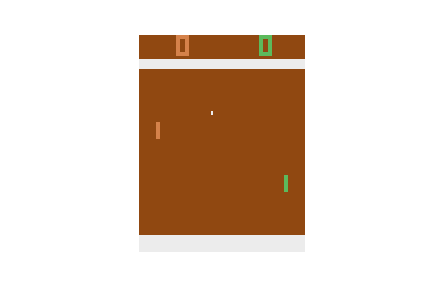
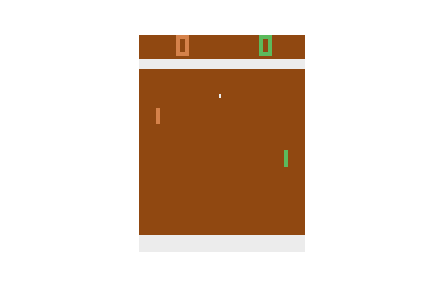
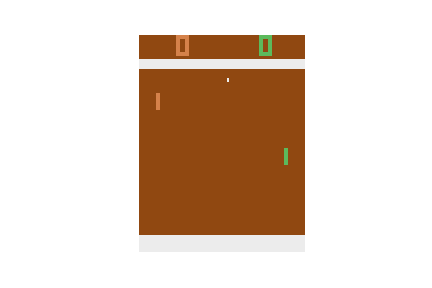
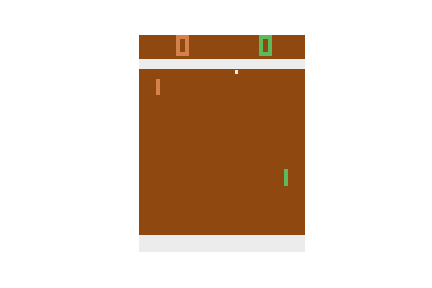
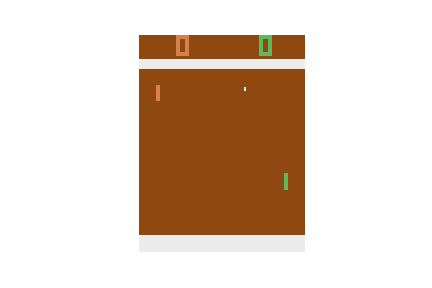
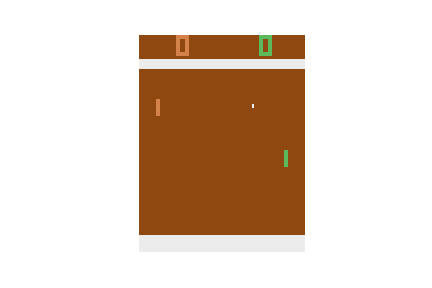
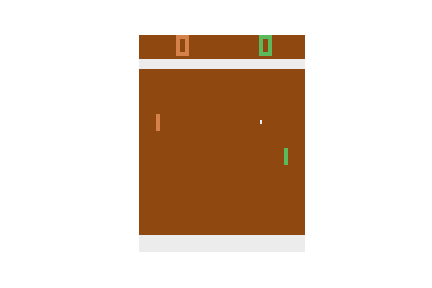
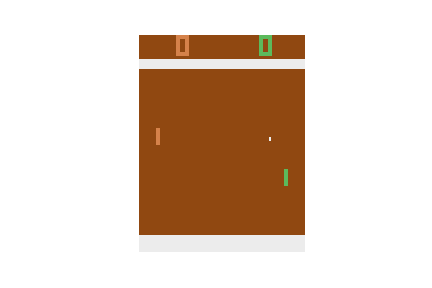
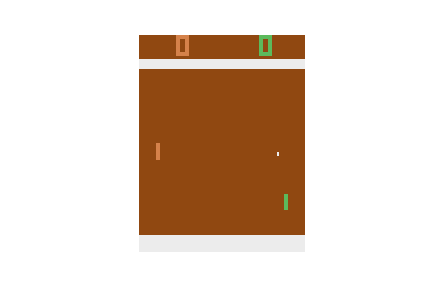
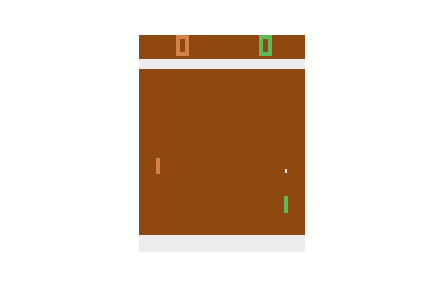
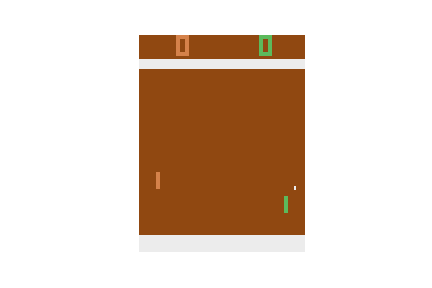
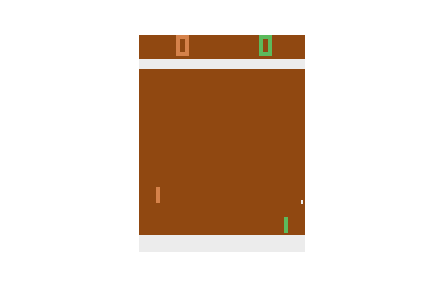
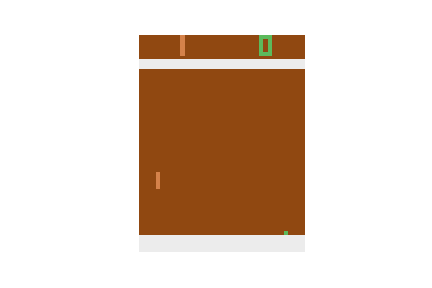
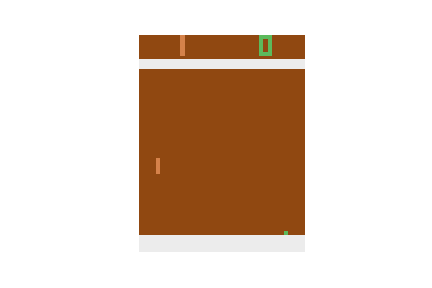
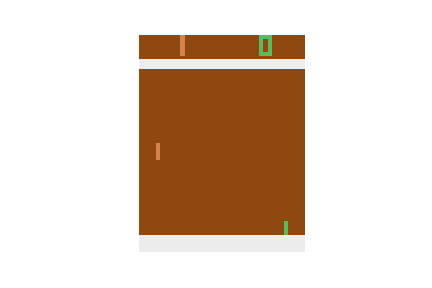
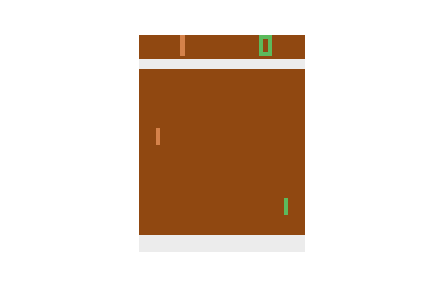
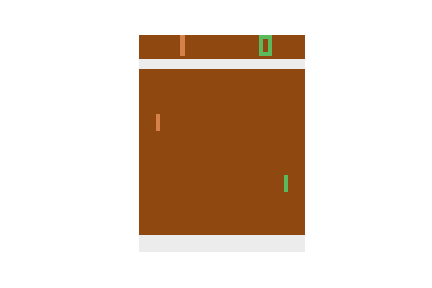
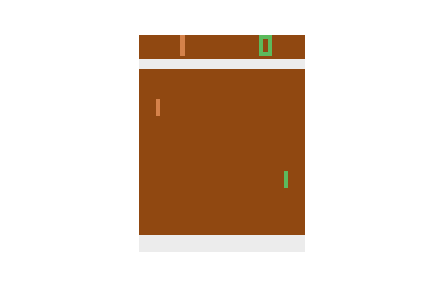
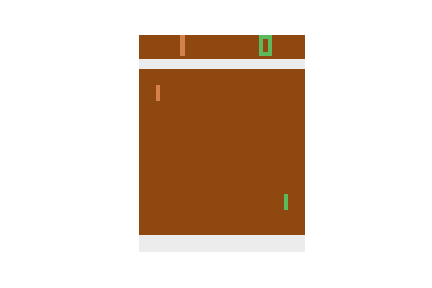
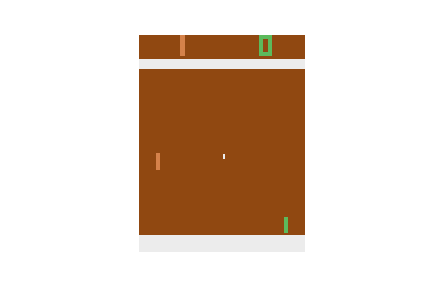
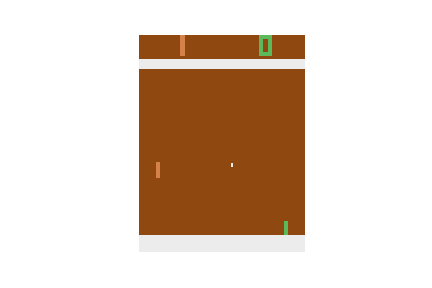
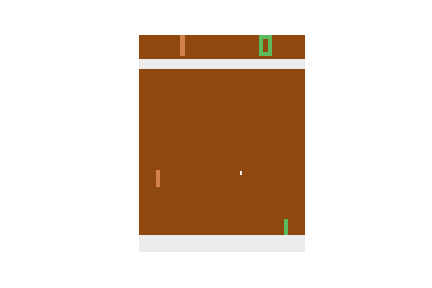
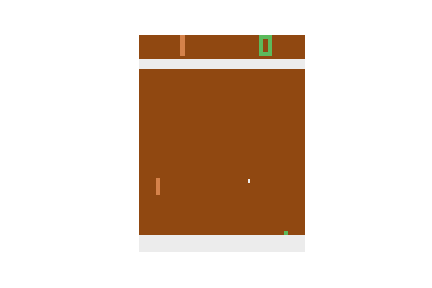
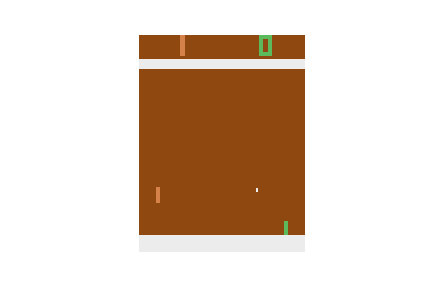
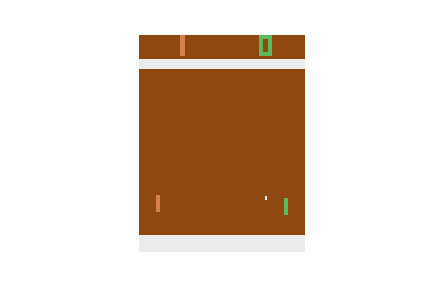
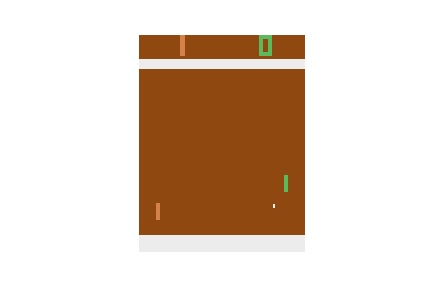
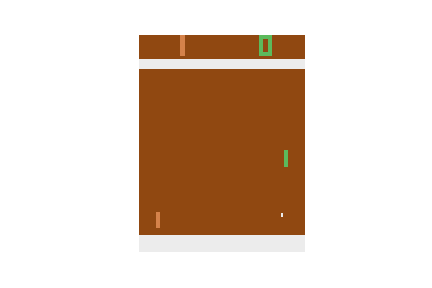
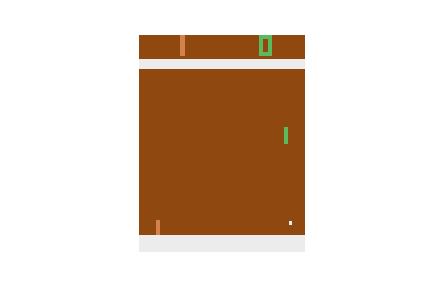
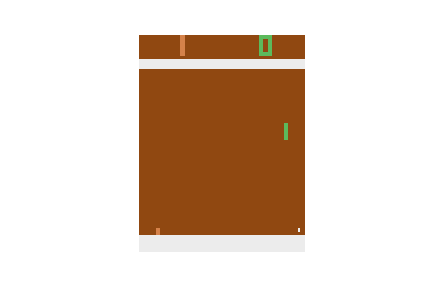
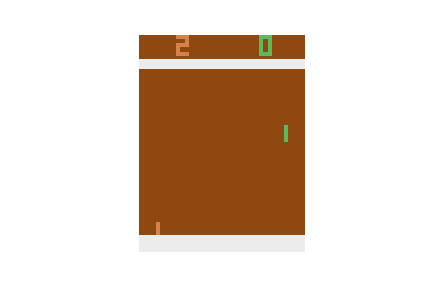
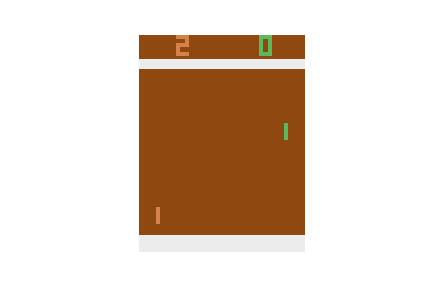
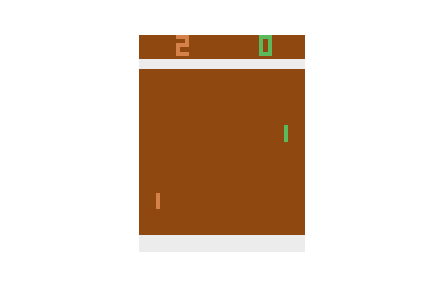
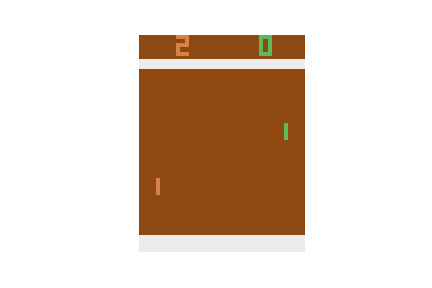
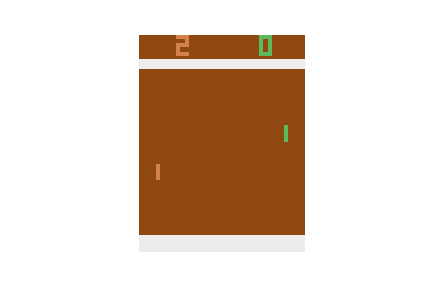
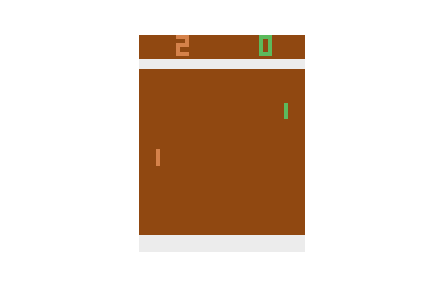
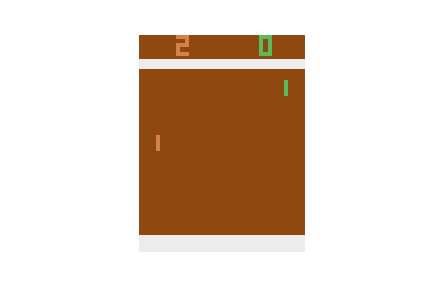
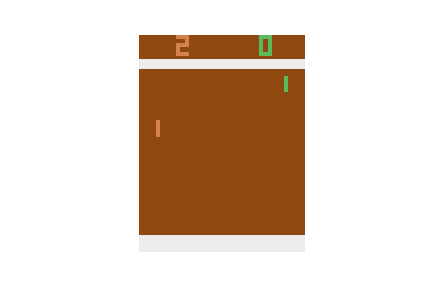
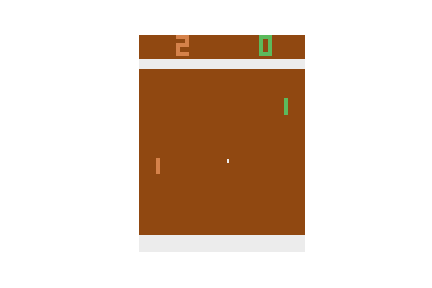
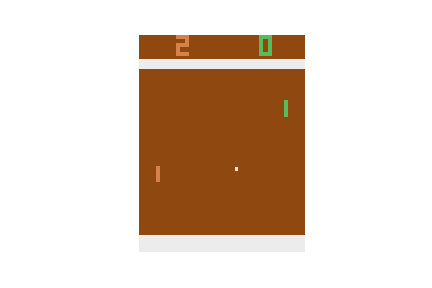
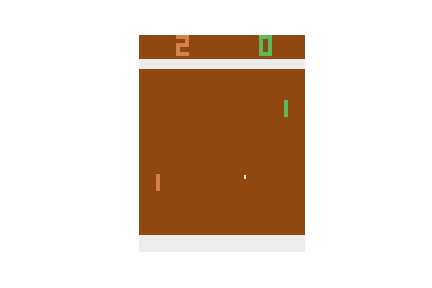
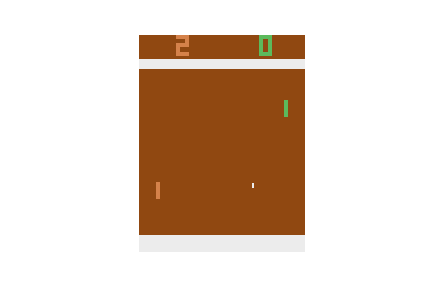
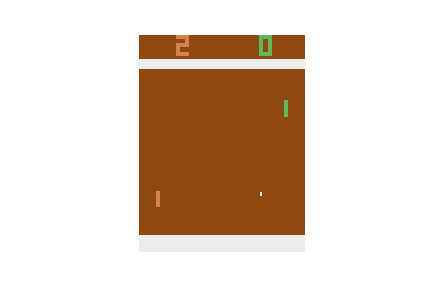
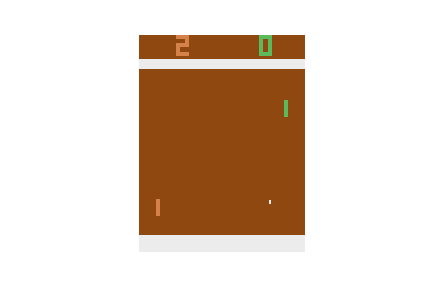
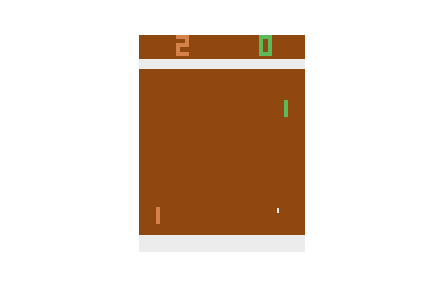
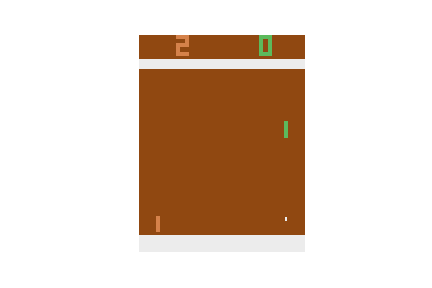
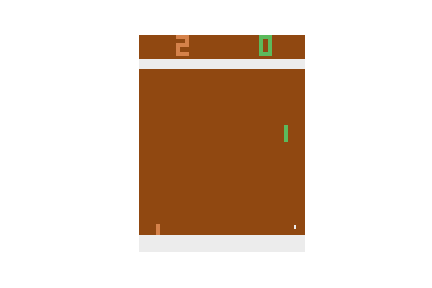
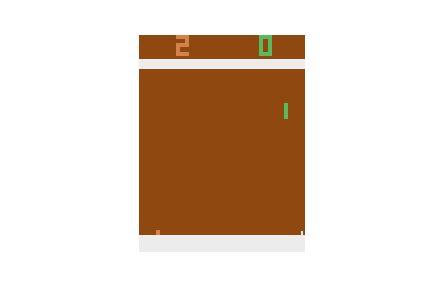
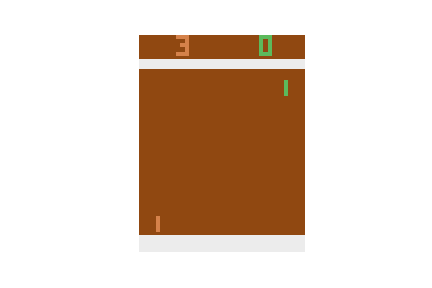
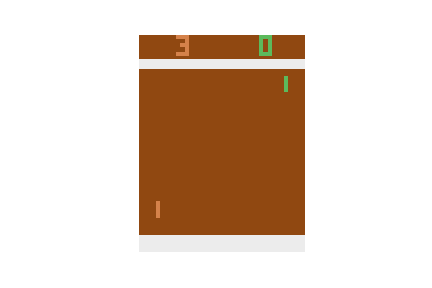
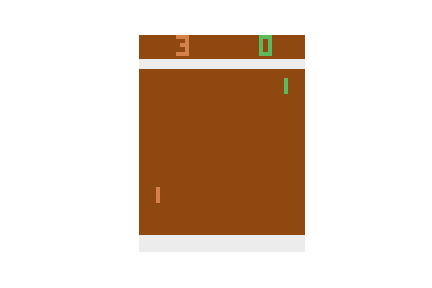
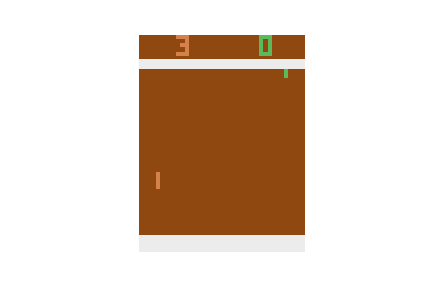
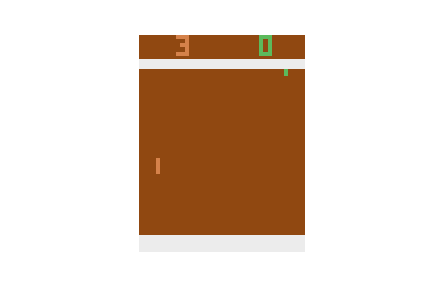
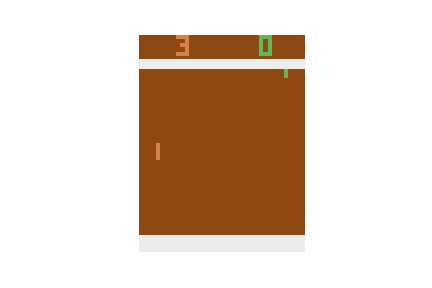
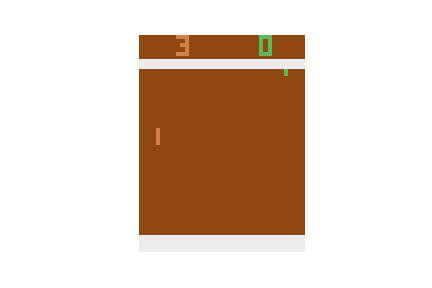
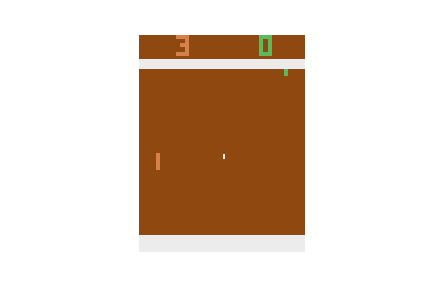
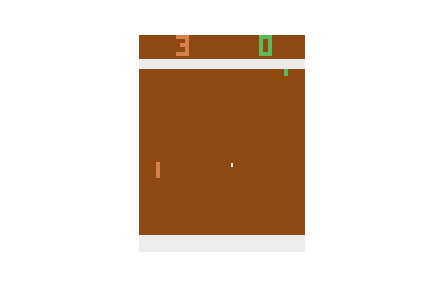
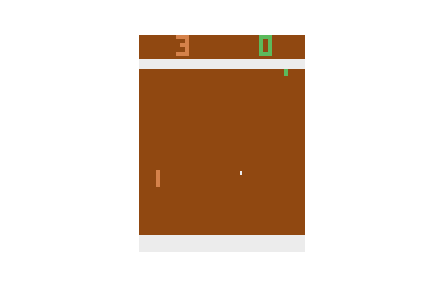
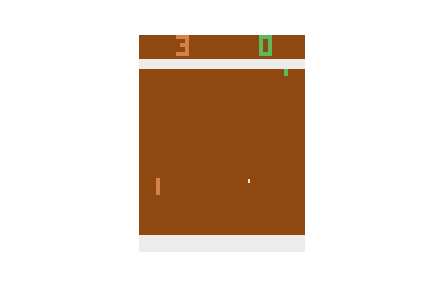
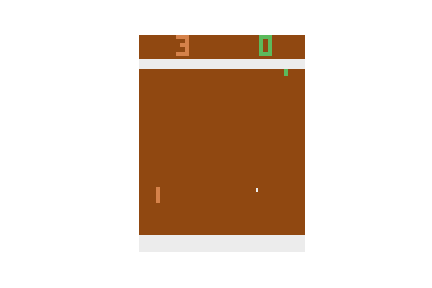
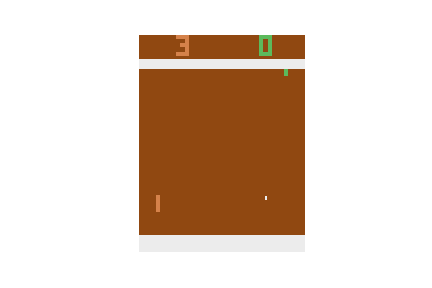
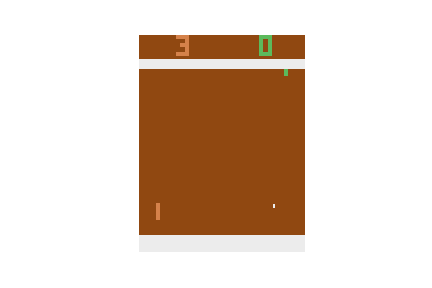
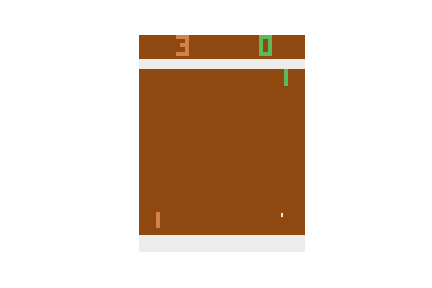
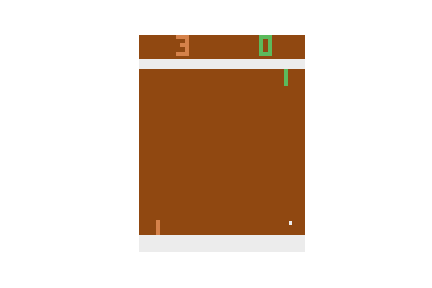
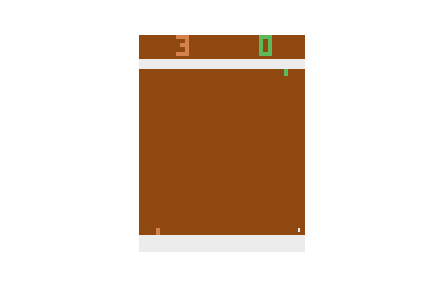
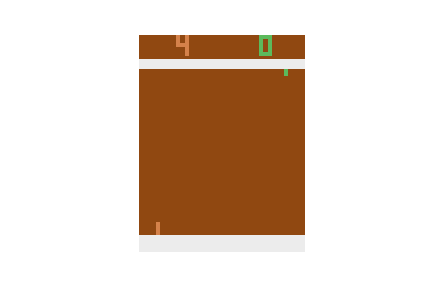
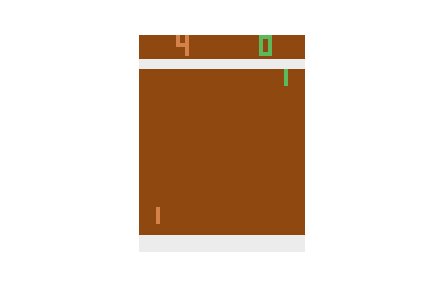
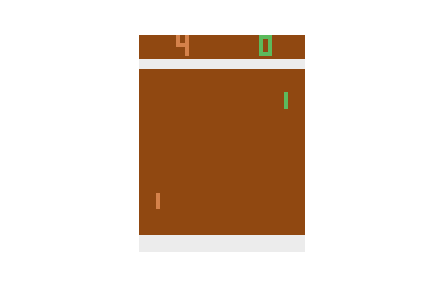
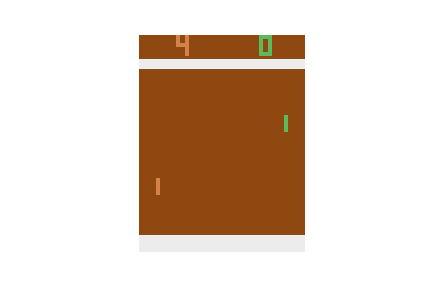
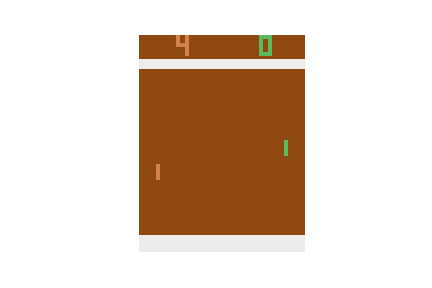
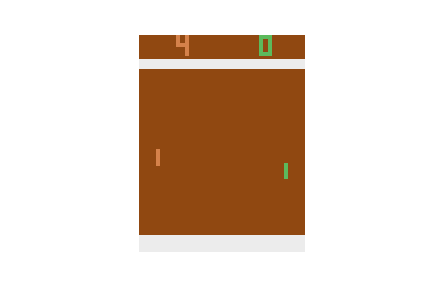
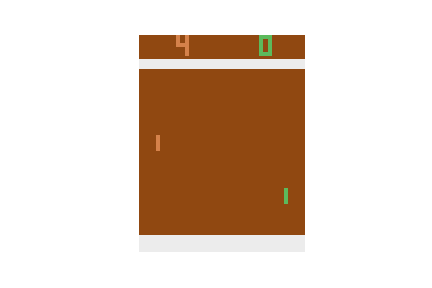
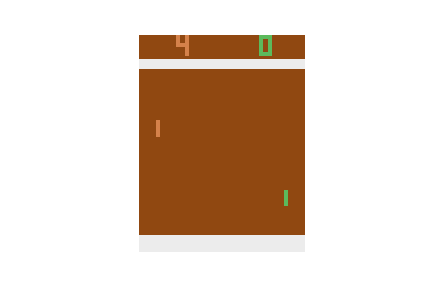
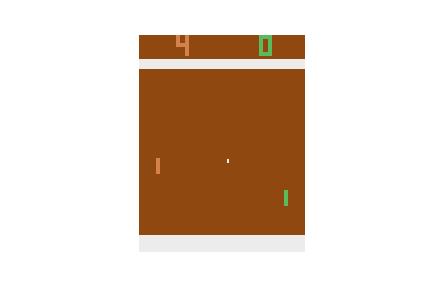
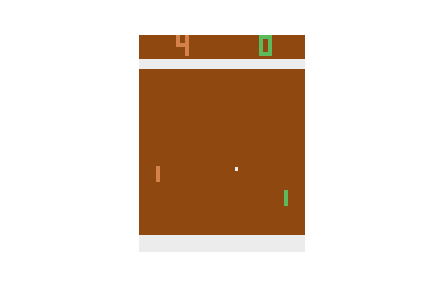
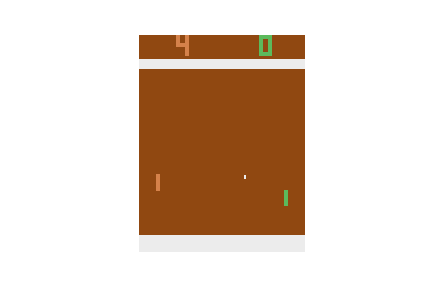
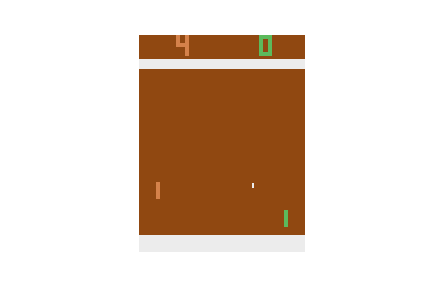
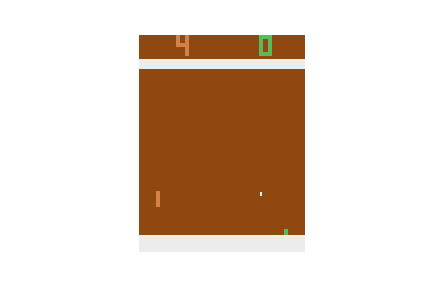
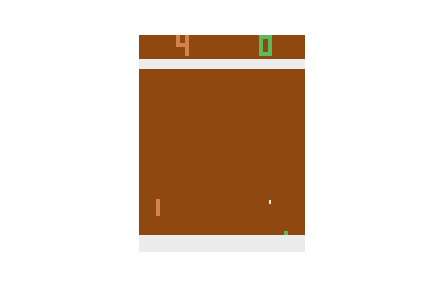
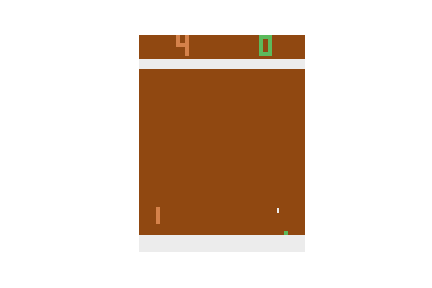
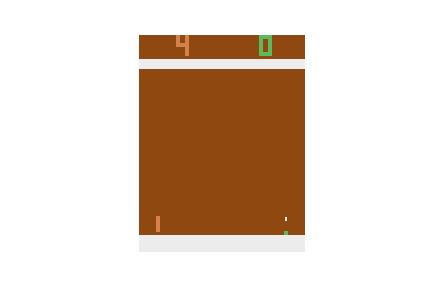
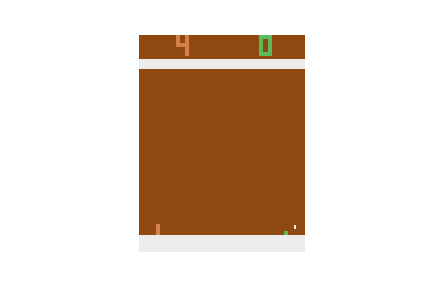
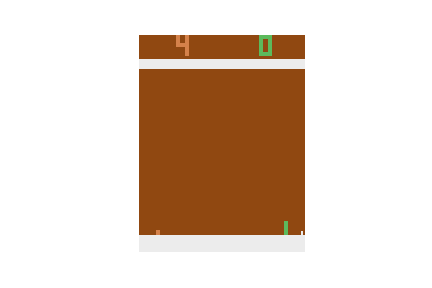
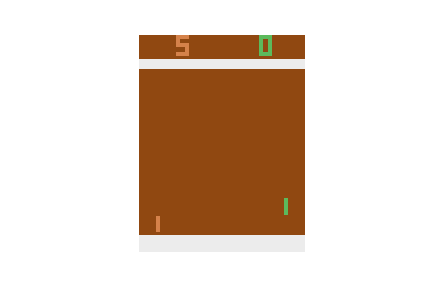
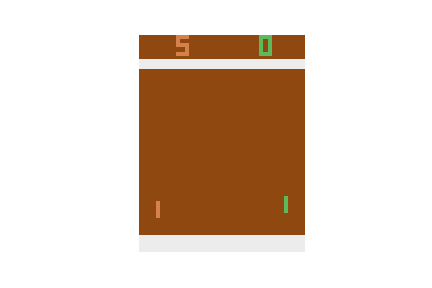
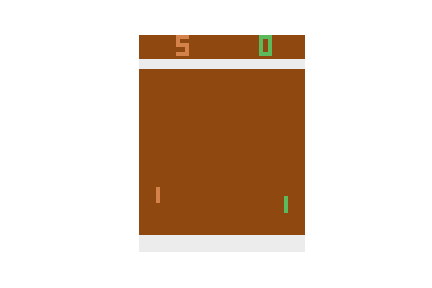

In [5]:
pong_utils.play(env, policy, time=100)
# try to add the option "preprocess=pong_utils.preprocess_single"
# to see what the agent sees

In [6]:
from collections import deque
import numpy as np

def jey_collect_trajectories(envs, policy, tmax=200, nrand=5):
    # number of parallel instances
    n = len(envs.ps)

    # initialize returning lists and start the game!
    state_list = []
    reward_list = []
    logprob_list = []
    entropy_list = []
    action_list = []

    envs.reset()

    # start all parallel agents
    envs.step([1] * n)

    # perform nrand random steps
    for _ in range(nrand):
        fr1, re1, _, _ = envs.step(np.random.choice([RIGHT, LEFT], n))
        fr2, re2, _, _ = envs.step([0] * n)

    for t in range(tmax):

        # prepare the input
        # preprocess_batch properly converts two frames into
        # shape (n, 2, 80, 80), the proper input for the policy
        # this is required when building CNN with pytorch
        batch_input = pong_utils.preprocess_batch([fr1, fr2])

        # probs will only be used as the pi_old
        # no gradient propagation is needed
        # so we move it to the cpu
        action, logprob, entropy = policy.full_pass(batch_input)

        # advance the game (0=no action)
        # we take one action and skip game forward
        fr1, re1, is_done, _ = envs.step(action)
        fr2, re2, is_done, _ = envs.step([0] * n)

        reward = re1 + re2

        # store the result
        state_list.append(batch_input)
        reward_list.append(reward)
        logprob_list.append(logprob)
        entropy_list.append(entropy)
        action_list.append(action)

        # stop if any of the trajectories is done
        # we want all the lists to be retangular
        if is_done.any():
            break

    # return pi_theta, states, actions, rewards, probability
    return logprob_list, entropy_list, state_list, action_list, reward_list

envs = pong_utils.parallelEnv('PongDeterministic-v4', n=8, seed=12345)
logprob_list, entropy_list, state_list, action_list, reward_list = jey_collect_trajectories(envs, policy, tmax=100)

In [7]:
print(np.stack(reward_list))

[[ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [-1. -1. -1. -1. -1. -1. -1. -1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0

In [8]:
def jey_surrogate(logprob_list, entropy_list, rewards_list, gamma = 0.995, beta=0.01):
    logprob = torch.stack(logprob_list, dim=0).squeeze()
    entropy = torch.stack(entropy_list, dim=0).squeeze()

    T = len(rewards_list)
    discounts = np.logspace(0, T, num=T, base=gamma, endpoint=False)[..., None]
    returns = np.array([np.sum(discounts[: T -t] * rewards_list[t:], axis=0) for t in range(T)])

    discounts = torch.FloatTensor(discounts).to(device)
    returns = torch.FloatTensor(returns).to(device)

    r_mean = torch.mean(returns)
    r_std = torch.std(returns) + 1.0e-8

    normalized_returns = (returns-r_mean)/r_std

    return torch.mean(discounts*normalized_returns*logprob + beta*entropy)


Lsur = jey_surrogate(logprob_list, entropy_list, reward_list)

print(Lsur)

tensor(0.0720, device='cuda:0', grad_fn=<MeanBackward0>)


In [9]:
from parallelEnv import parallelEnv
import numpy as np
# WARNING: running through all 800 episodes will take 30-45 minutes

# training loop max iterations
episode = 500
# episode = 800

# widget bar to display progress
!pip install progressbar
import progressbar as pb
widget = ['training loop: ', pb.Percentage(), ' ',
          pb.Bar(), ' ', pb.ETA() ]
timer = pb.ProgressBar(widgets=widget, maxval=episode).start()

# initialize environment
envs = parallelEnv('PongDeterministic-v4', n=8, seed=1234)

discount_rate = .99
beta = .01
tmax = 320

# keep track of progress
mean_rewards = []

for e in range(episode):

    # collect trajectories
    logprob_list, entropy_list, state_list, action_list, reward_list = jey_collect_trajectories(envs, policy, tmax=tmax)

    total_rewards = np.sum(reward_list, axis=0)

    # this is the SOLUTION!
    # use your own surrogate function
    L = -jey_surrogate(logprob_list, entropy_list, reward_list, beta=beta)

    # L = -pong_utils.surrogate(policy, old_probs, states, actions, rewards, beta=beta)
    optimizer.zero_grad()
    L.backward()
    optimizer.step()
    del L

    # the regulation term also reduces
    # this reduces exploration in later runs
    beta*=.995

    # get the average reward of the parallel environments
    mean_rewards.append(np.mean(total_rewards))

    # display some progress every 20 iterations
    if (e+1)%20 ==0 :
        print("Episode: {0:d}, score: {1:f}".format(e+1,np.mean(total_rewards)))
        print(total_rewards)

    # update progress widget bar
    timer.update(e+1)

timer.finish()


You should consider upgrading via the '/home/jeyhoon/git/deep-reinforcement-learning/drlnd/bin/python -m pip install --upgrade pip' command.


Episode: 20, score: -14.000000
[-16. -16. -14.  -8. -16. -13. -13. -16.]


Episode: 40, score: -14.375000
[-16. -15. -11. -16. -15. -12. -15. -15.]


Episode: 60, score: -14.375000
[-16. -16. -16. -13. -16. -13. -10. -15.]


Episode: 80, score: -13.125000
[-16. -16.  -8. -14. -10. -16. -11. -14.]


Episode: 100, score: -15.250000
[-16. -16. -15. -16. -16. -15. -16. -12.]


Episode: 120, score: -14.500000
[-16. -15. -11. -14. -13. -14. -16. -17.]


Episode: 140, score: -15.500000
[-14. -16. -15. -16. -16. -16. -16. -15.]


Episode: 160, score: -15.125000
[-14. -15. -16. -15. -14. -16. -16. -15.]


Episode: 180, score: -14.750000
[-14. -16. -16. -10. -16. -17. -15. -14.]


Episode: 200, score: -15.000000
[-14. -15. -15. -14. -15. -16. -15. -16.]


Episode: 220, score: -14.750000
[-13. -17. -13. -15. -16. -15. -16. -13.]


Episode: 240, score: -14.875000
[-14. -15. -16. -13. -16. -13. -16. -16.]


Episode: 260, score: -15.250000
[-16. -13. -16. -15. -16. -15. -15. -16.]


Episode: 280, score: -13.250000
[-14. -13. -15. -12. -15.  -9. -13. -15.]


Episode: 300, score: -14.250000
[-15. -14. -16. -16. -12. -15. -16. -10.]


Episode: 320, score: -13.500000
[-12. -15. -16.  -8. -16. -16.  -9. -16.]


Episode: 340, score: -14.750000
[-10. -16. -14. -16. -15. -16. -15. -16.]


Episode: 360, score: -15.375000
[-16. -17.  -8. -17. -16. -16. -16. -17.]


Episode: 380, score: -16.000000
[-16. -16. -16. -16. -16. -16. -16. -16.]


Episode: 400, score: -15.125000
[-15. -12. -16. -16. -14. -16. -16. -16.]


Episode: 420, score: -12.875000
[ -9. -14. -12. -11. -15. -16. -10. -16.]


Episode: 440, score: -13.250000
[-14. -13. -13. -14. -16. -13. -12. -11.]


Episode: 460, score: -12.250000
[-14.  -8. -16. -12. -10. -12. -12. -14.]


Episode: 480, score: -14.375000
[-12. -13. -16. -14. -16. -13. -15. -16.]


Episode: 500, score: -13.875000
[-11.  -9. -16. -13. -15. -15. -16. -16.]



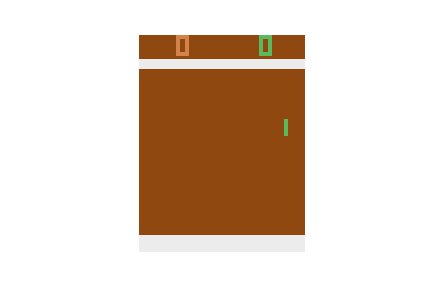
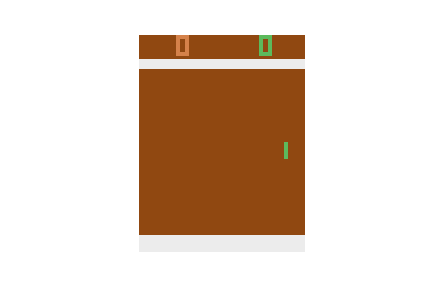
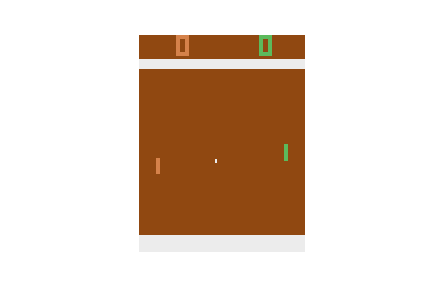
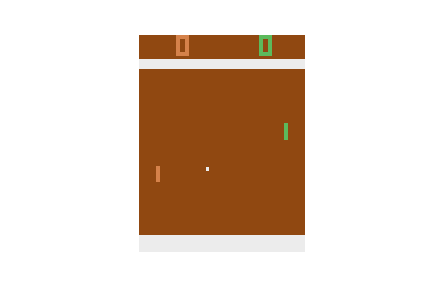
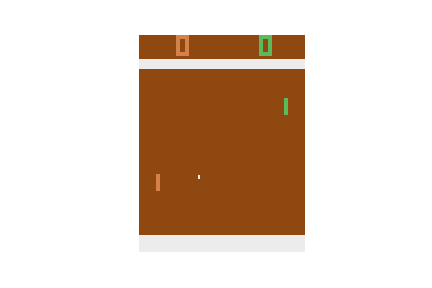
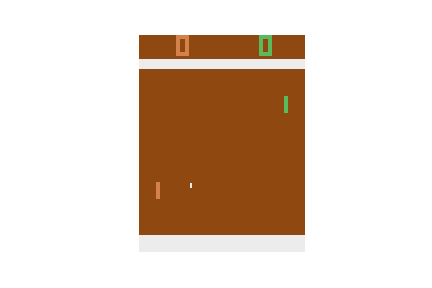
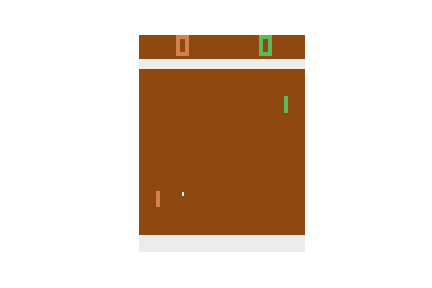
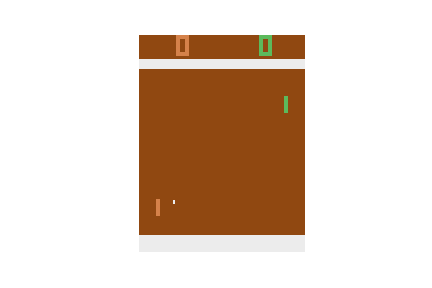
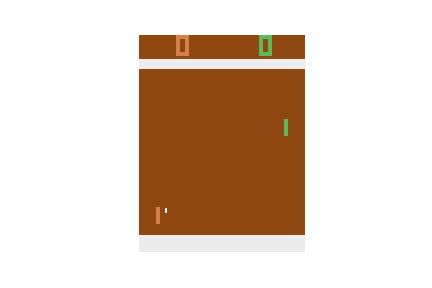
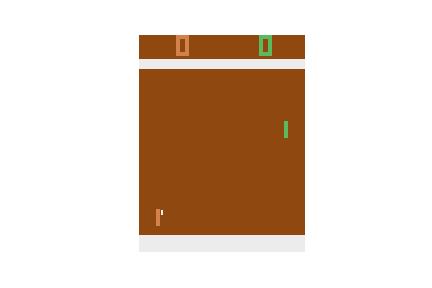
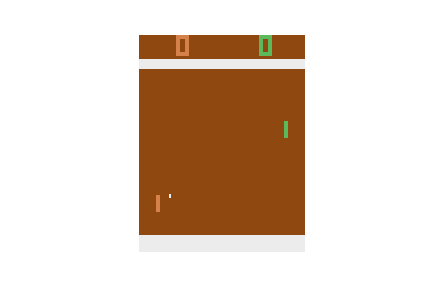
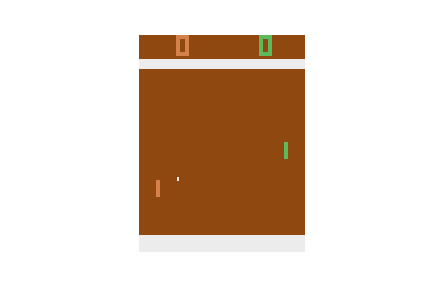
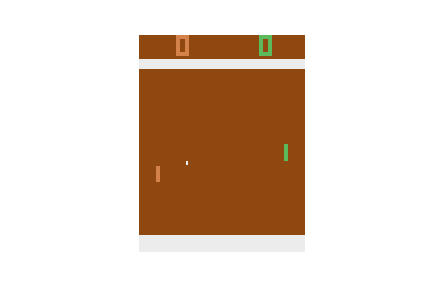
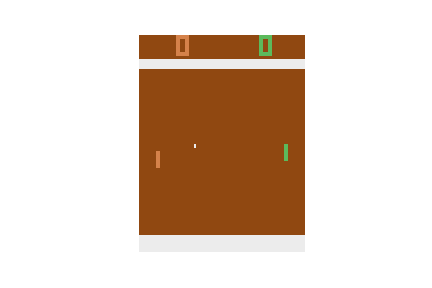
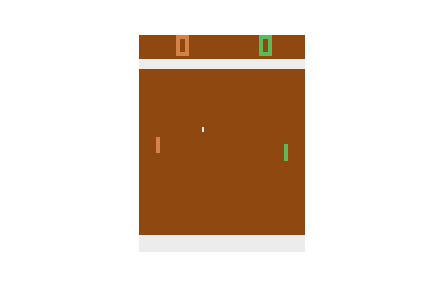
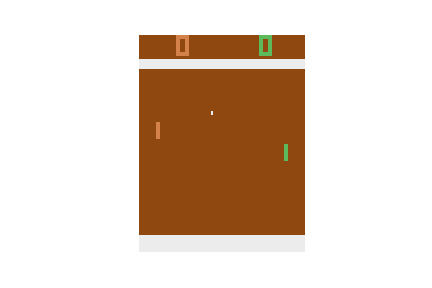
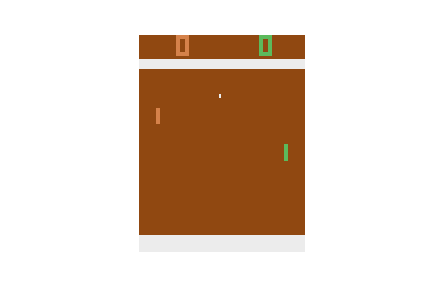
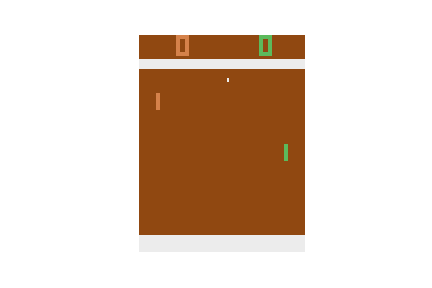
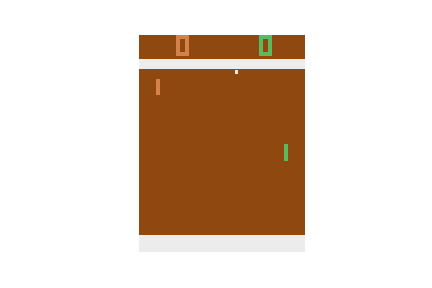
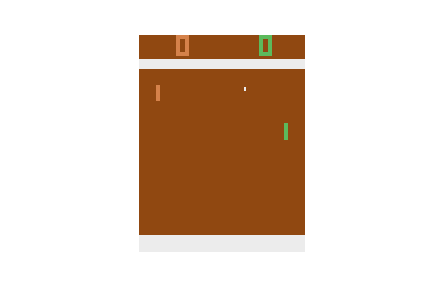
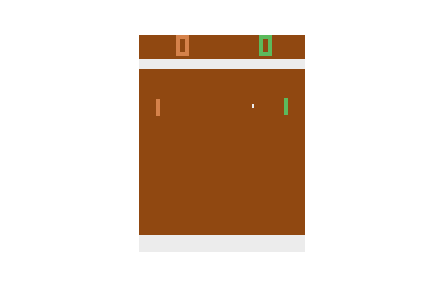
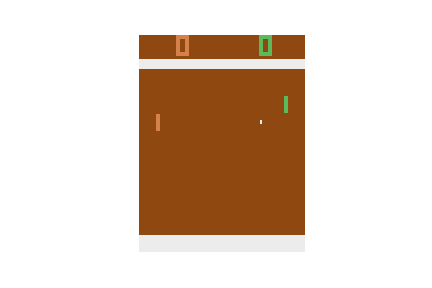
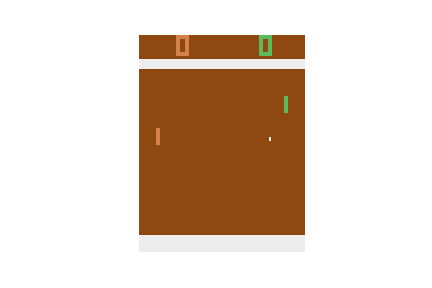
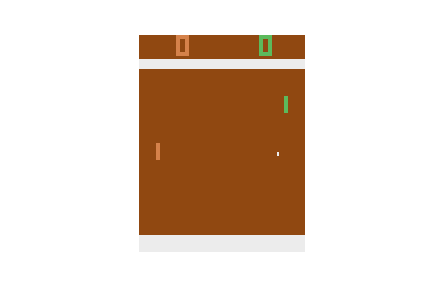
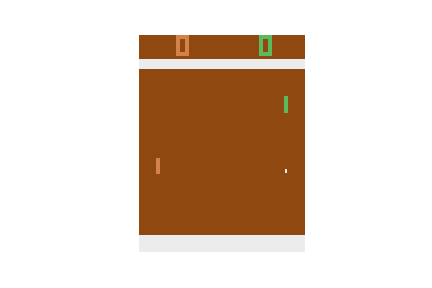
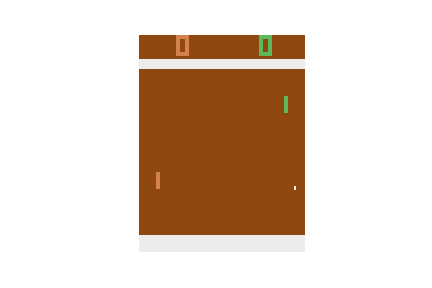
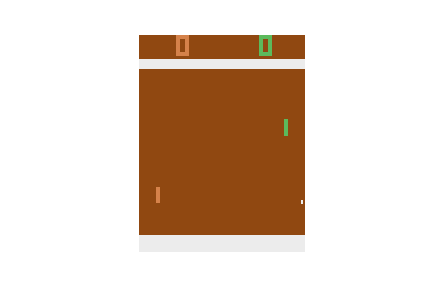
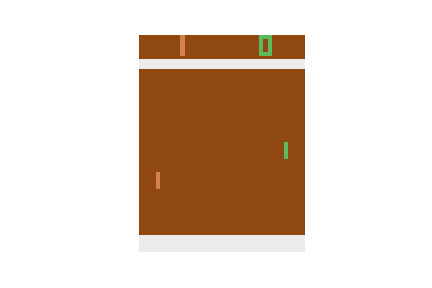
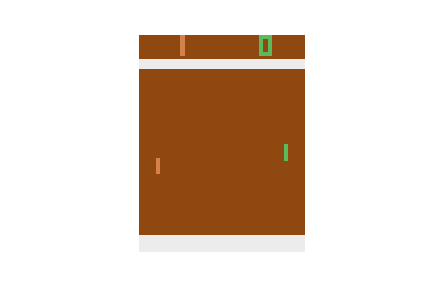
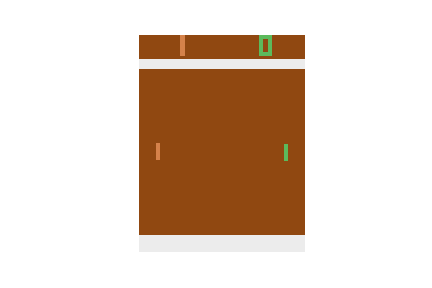
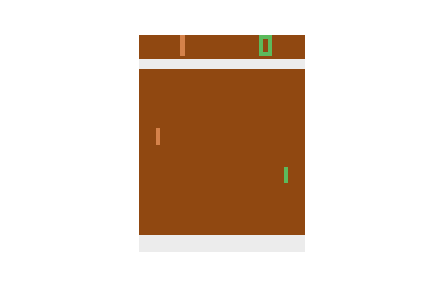
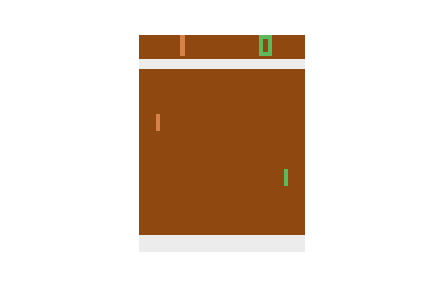
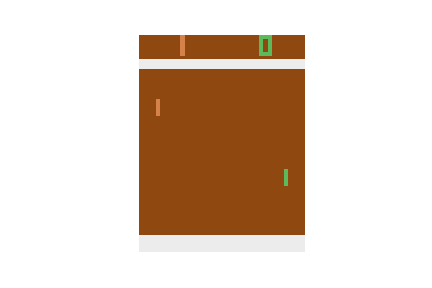
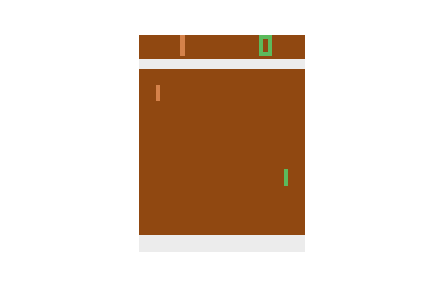
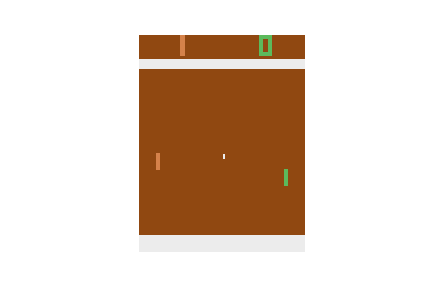
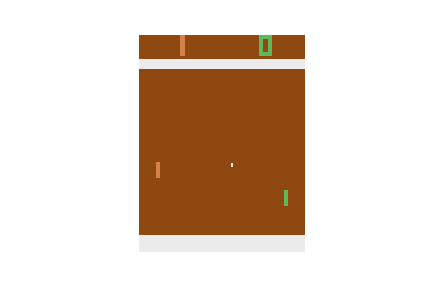
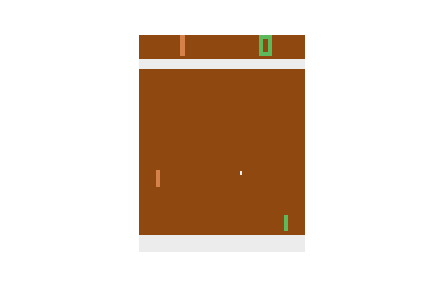
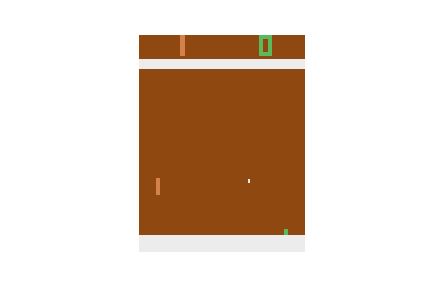
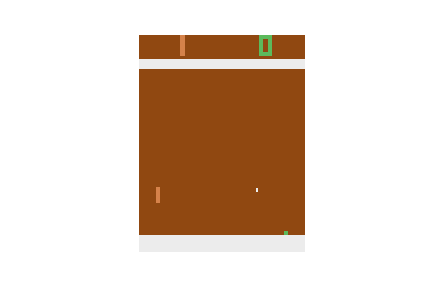
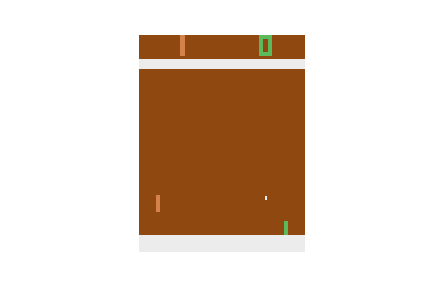
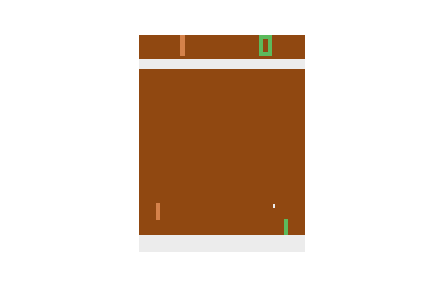
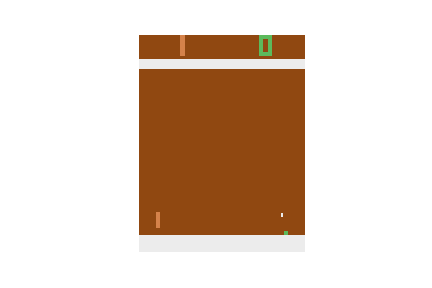
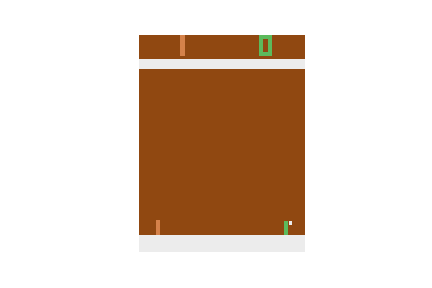
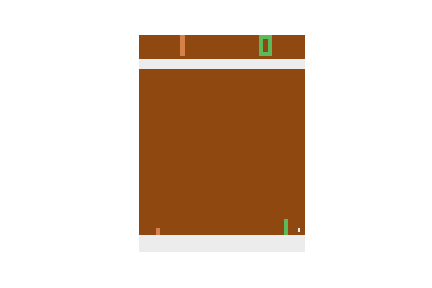
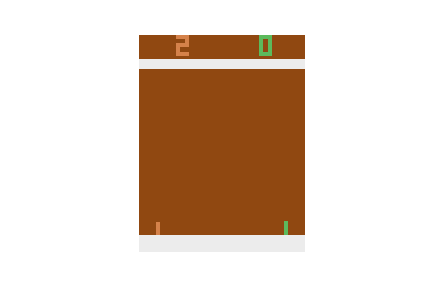
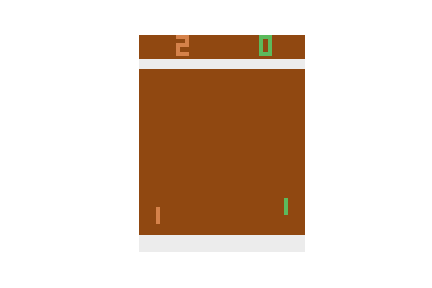
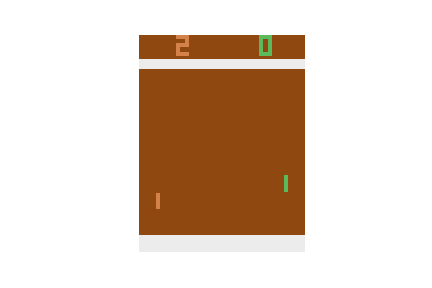
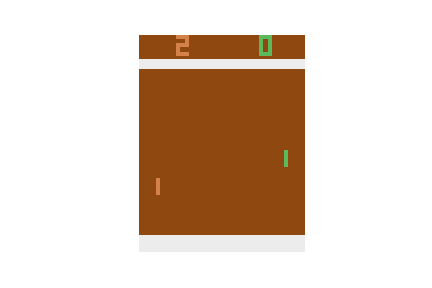
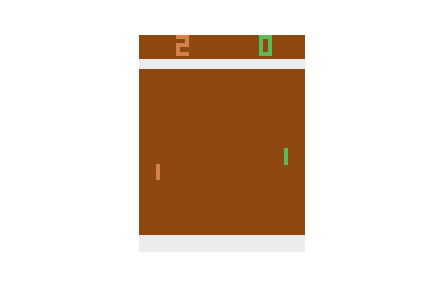
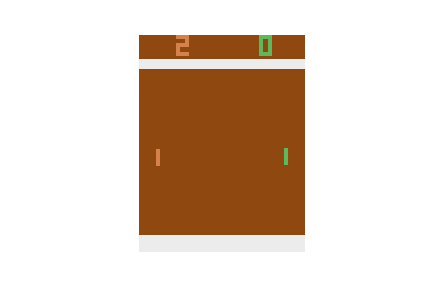
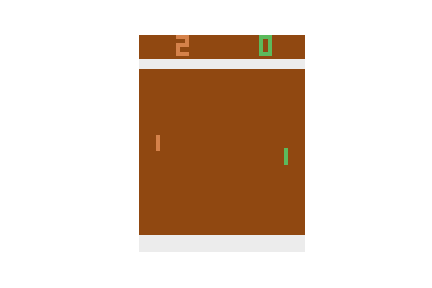
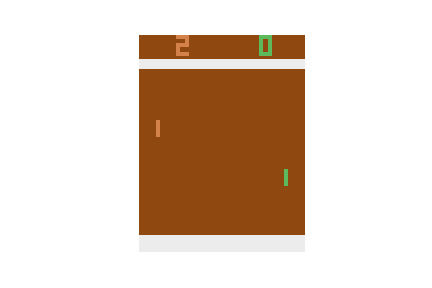
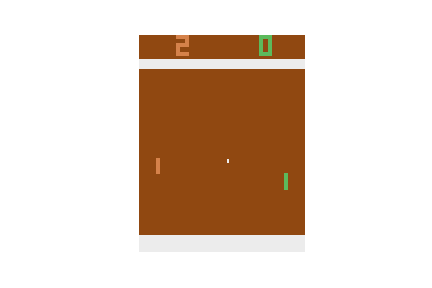
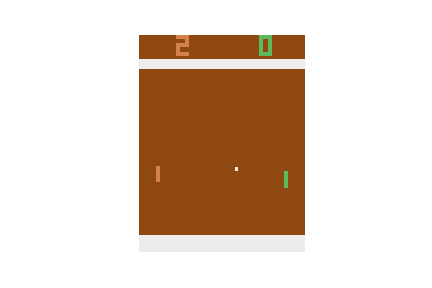
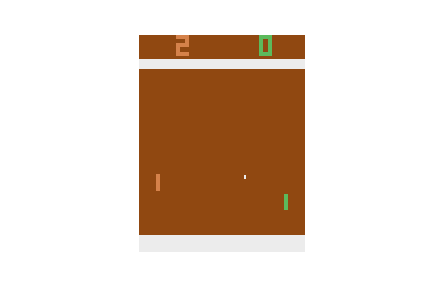
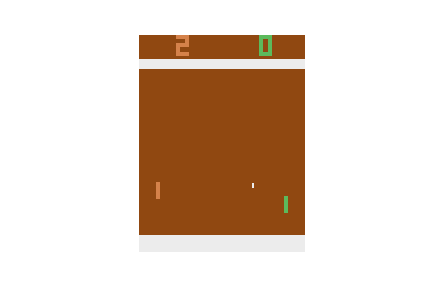
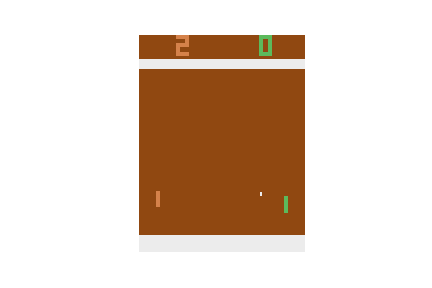
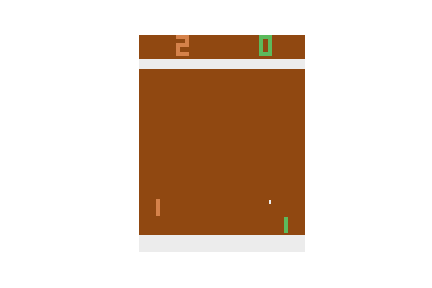
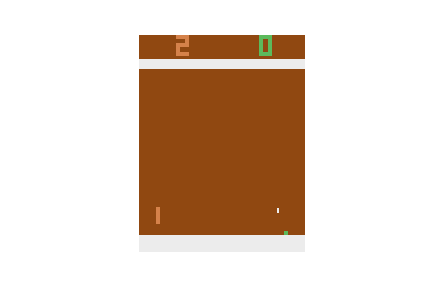
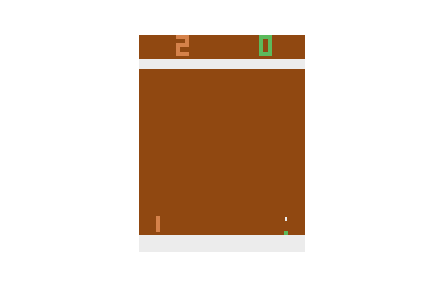
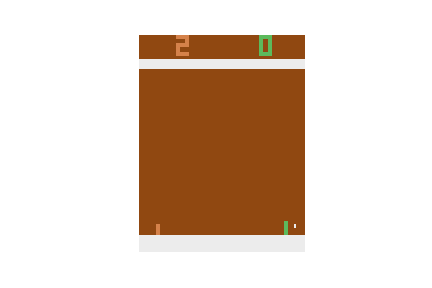
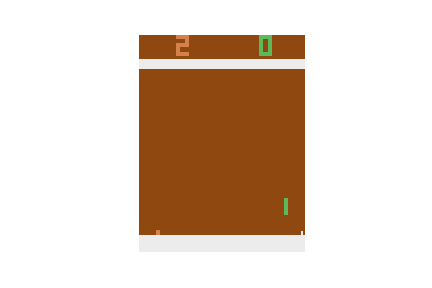
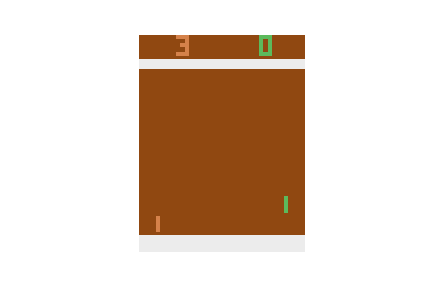
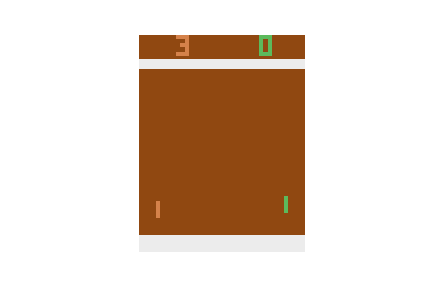
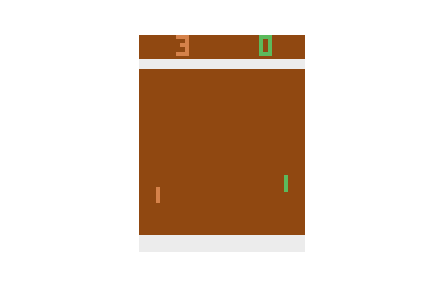
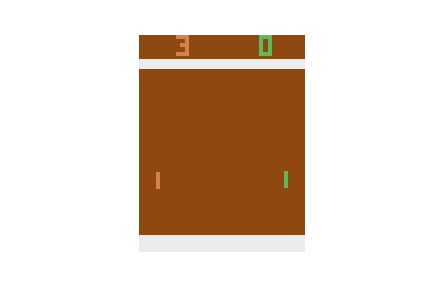
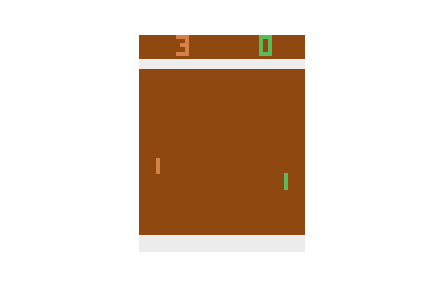
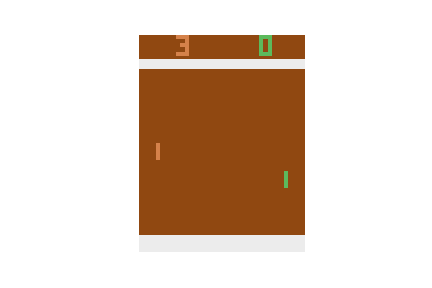
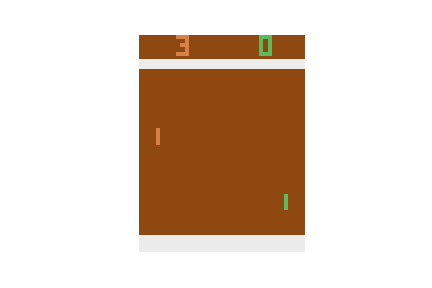
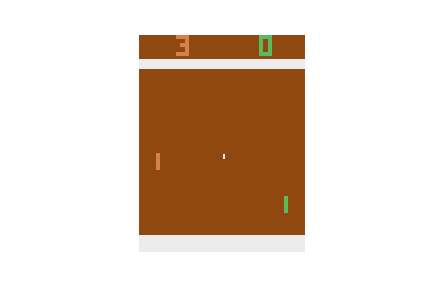
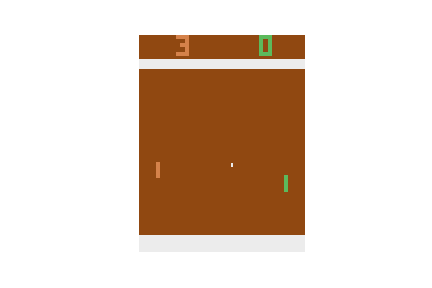
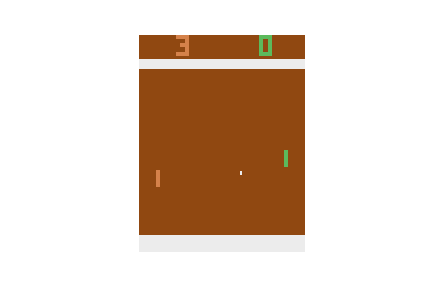
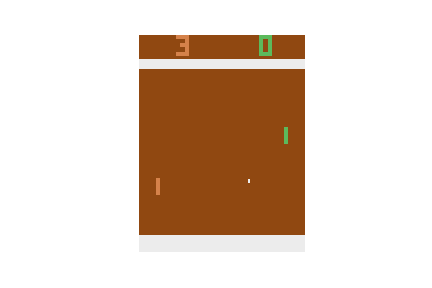
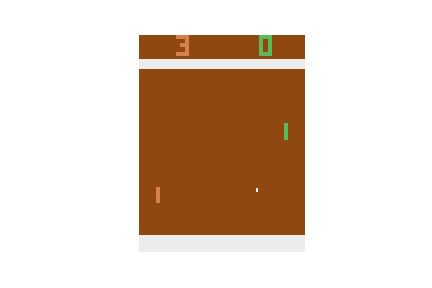
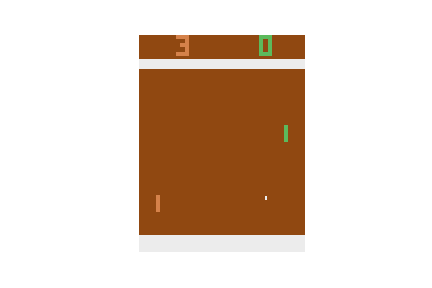
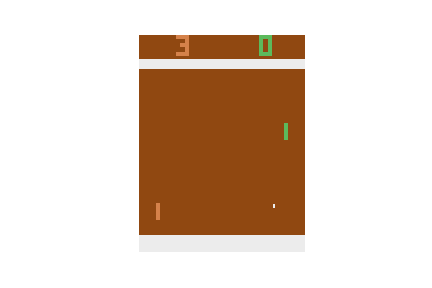
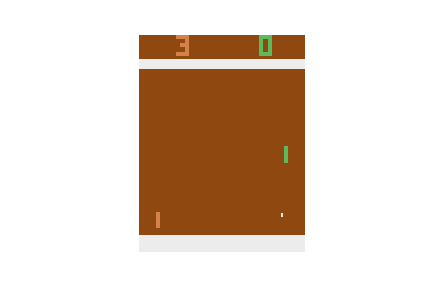
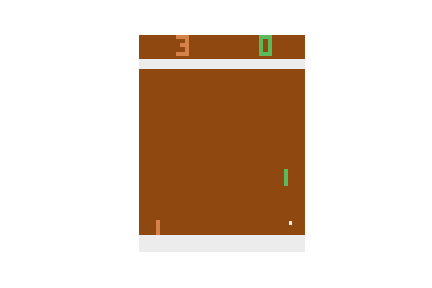
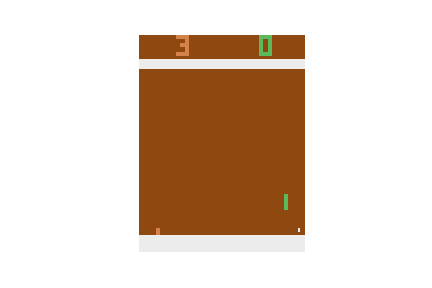
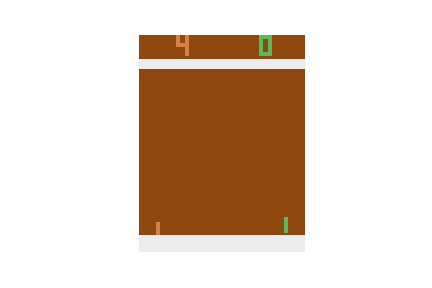
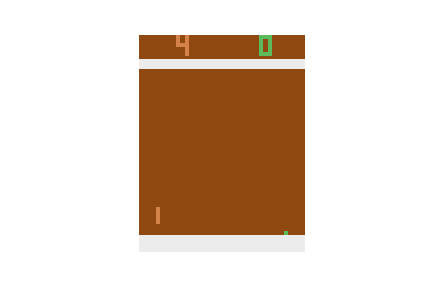
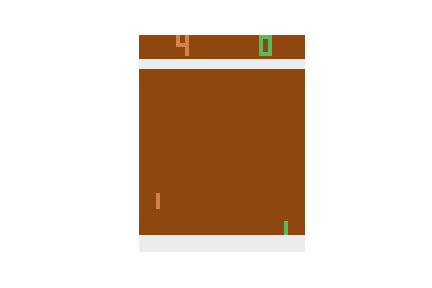
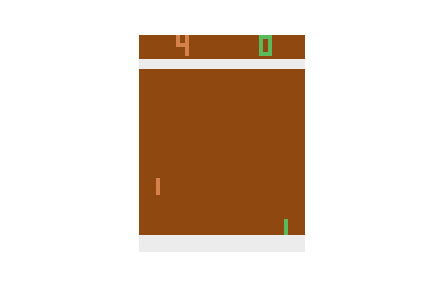
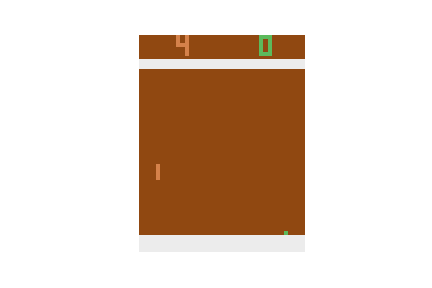
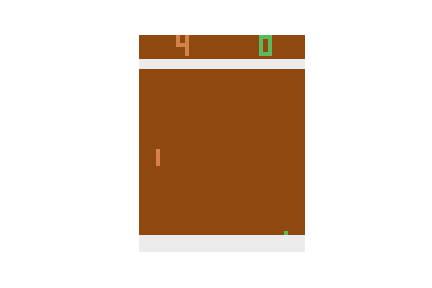
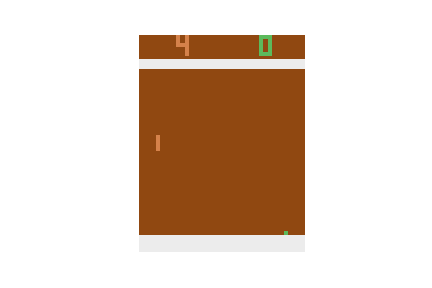
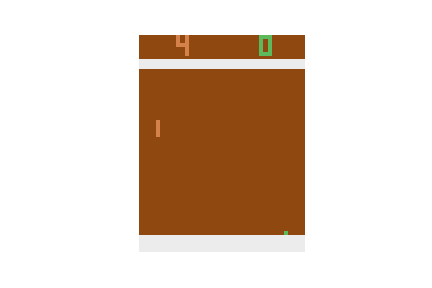
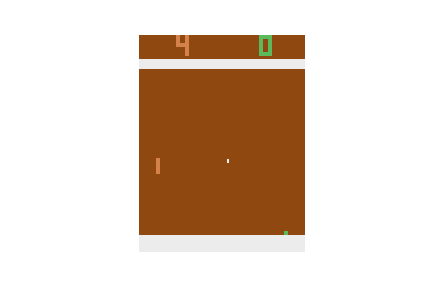
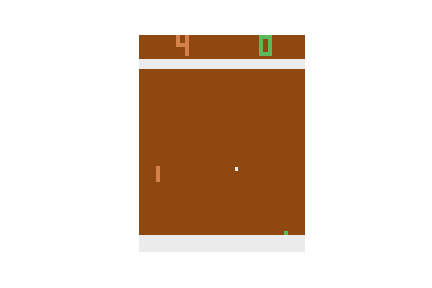
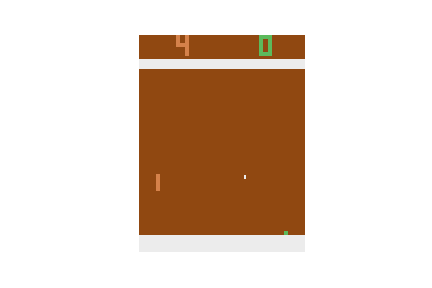
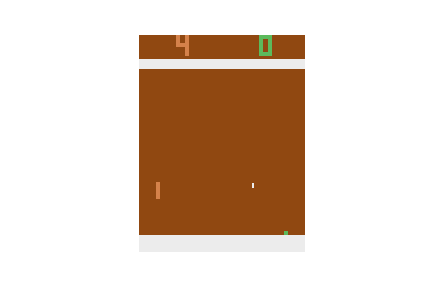
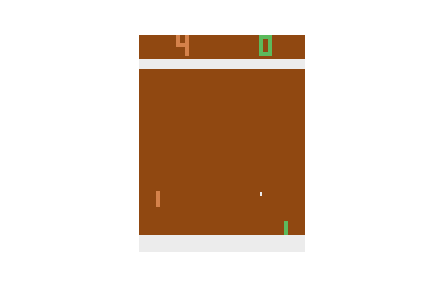
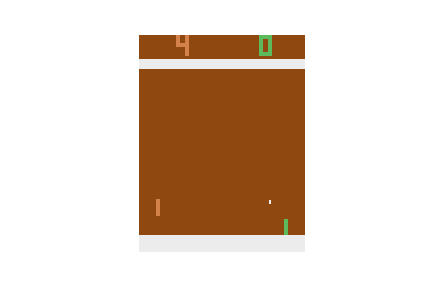
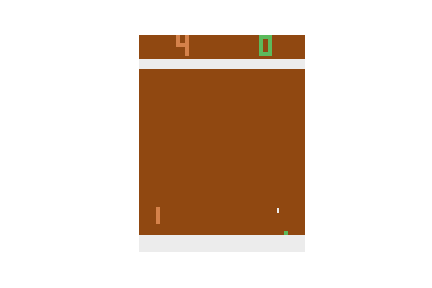
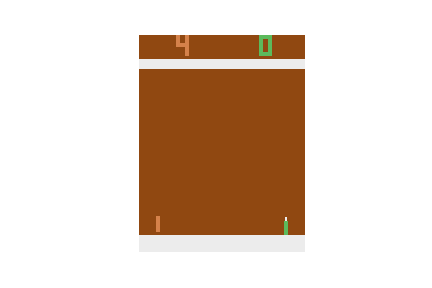
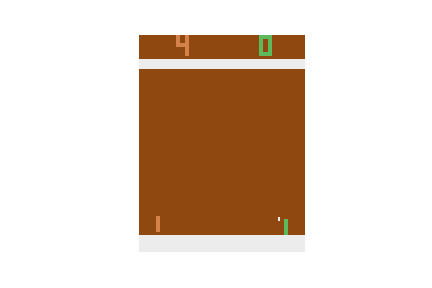
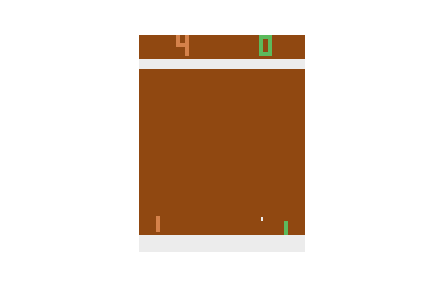
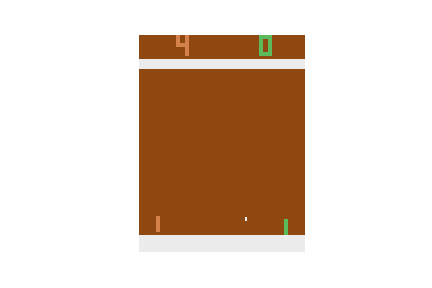
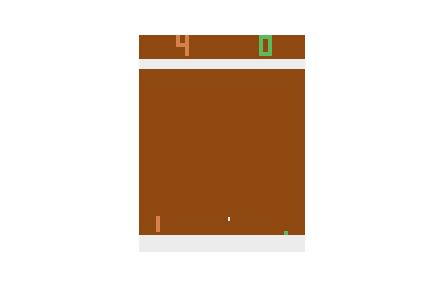
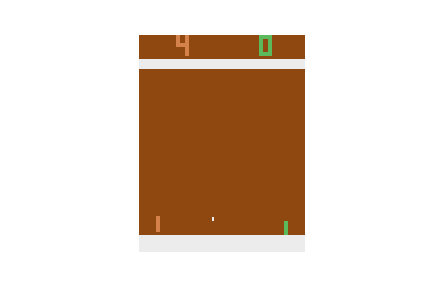
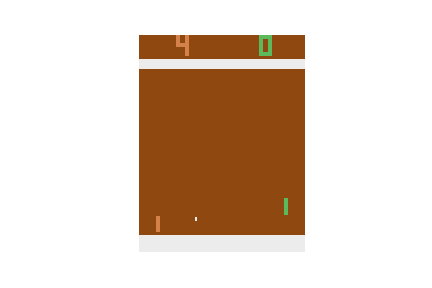
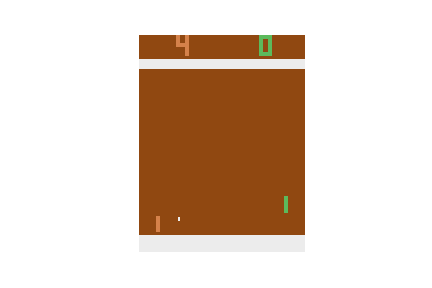
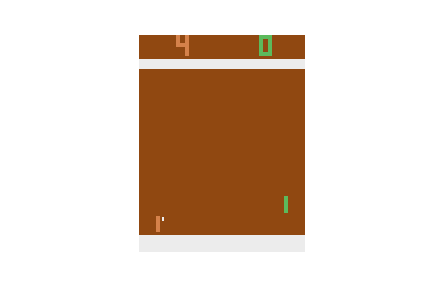
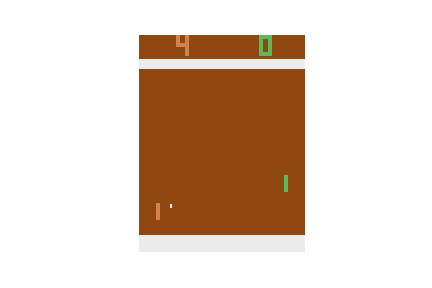
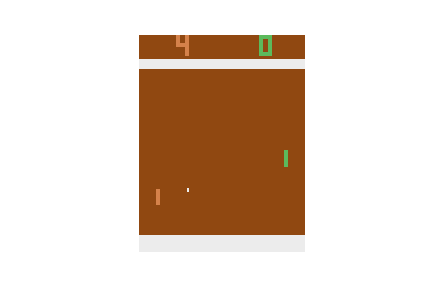
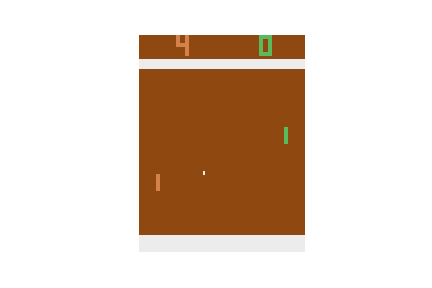
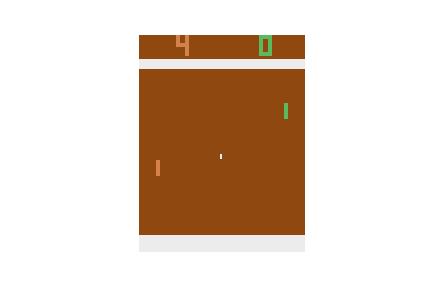
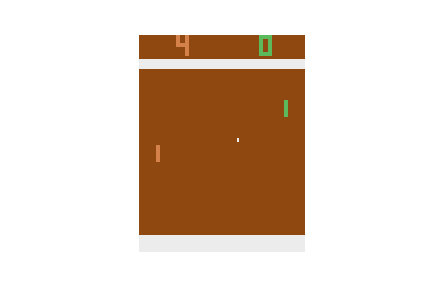
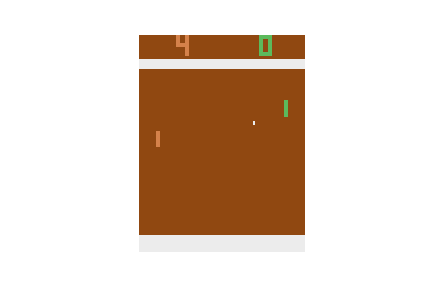
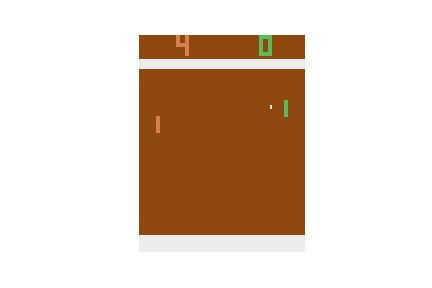
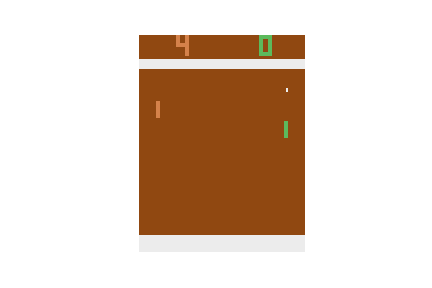
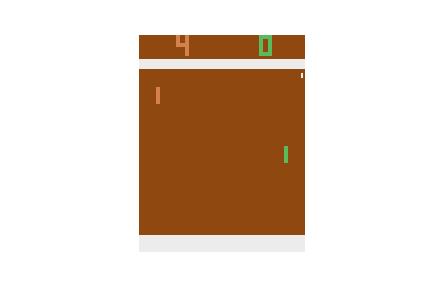
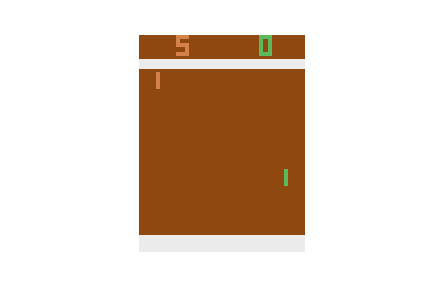
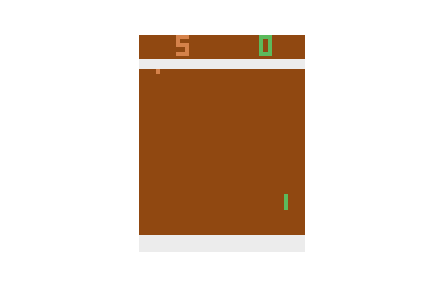
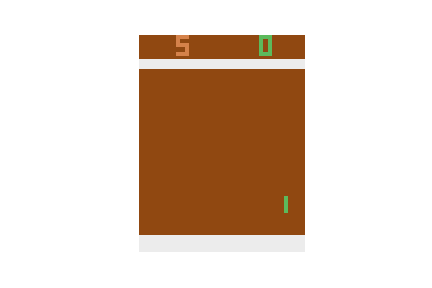
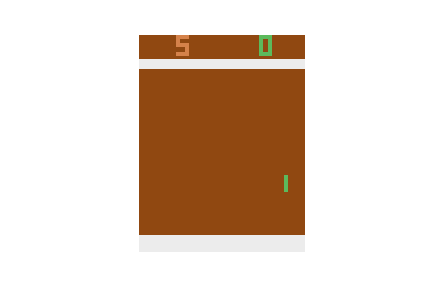
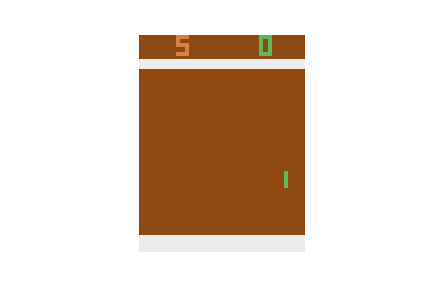
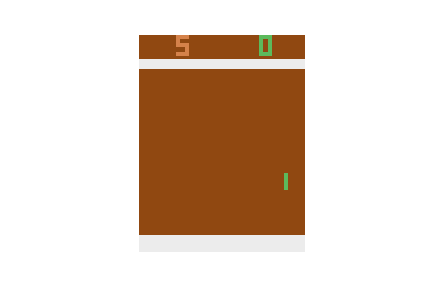
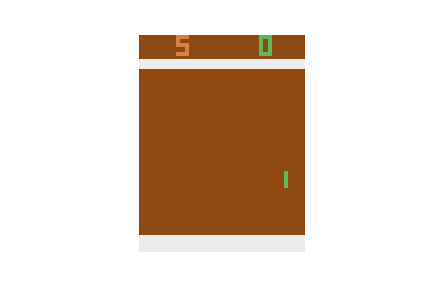
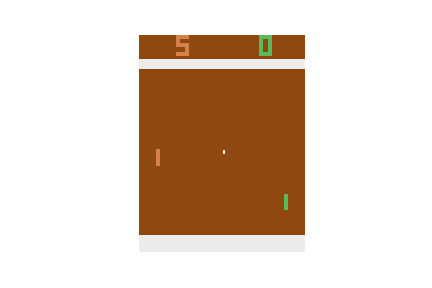
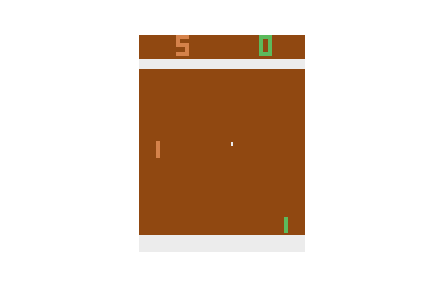
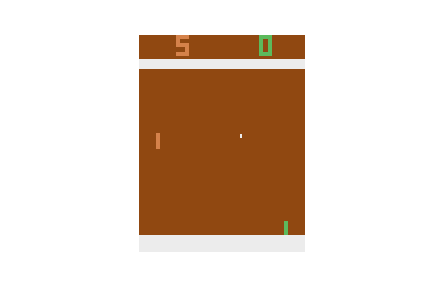
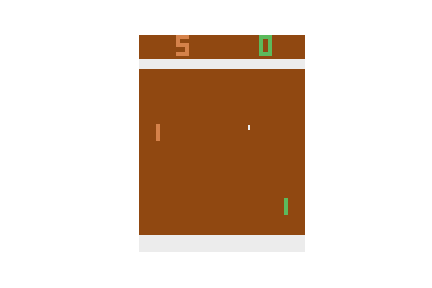
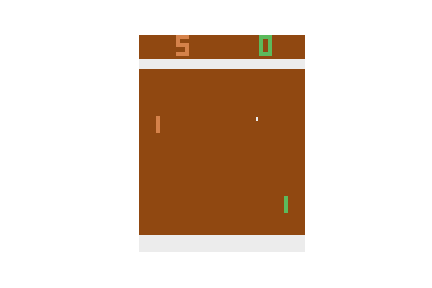
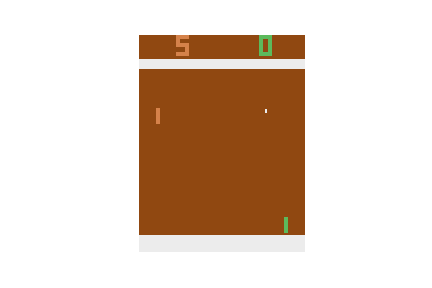
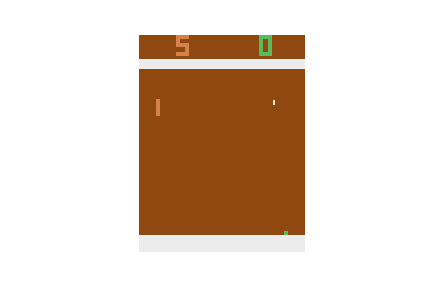
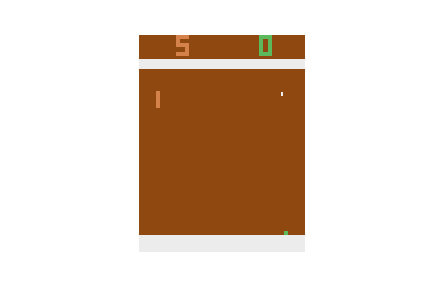
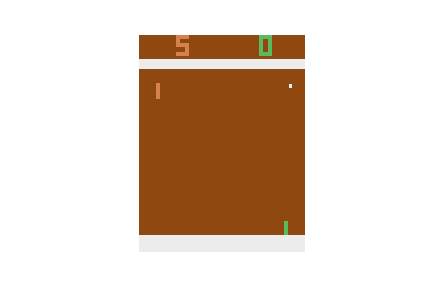
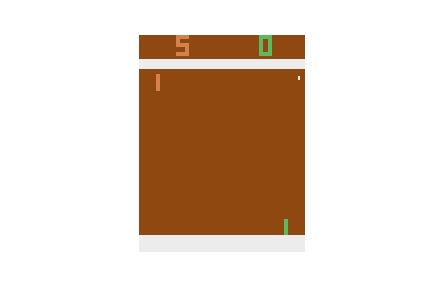
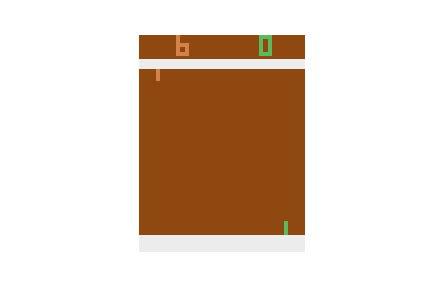
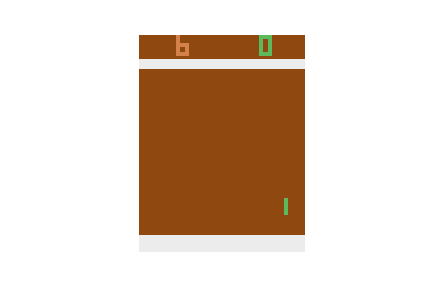
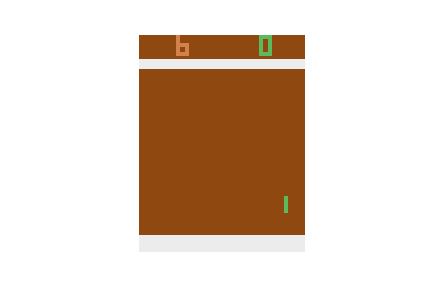
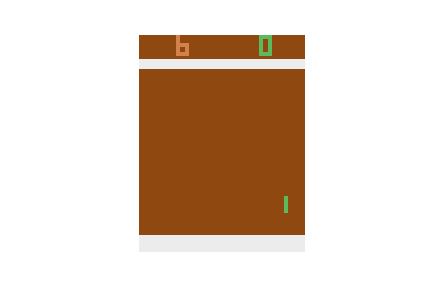
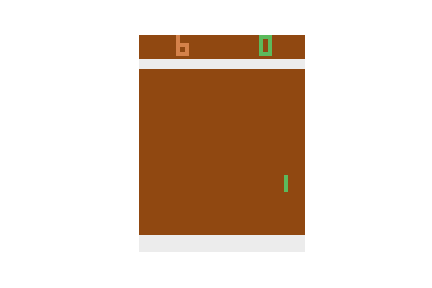
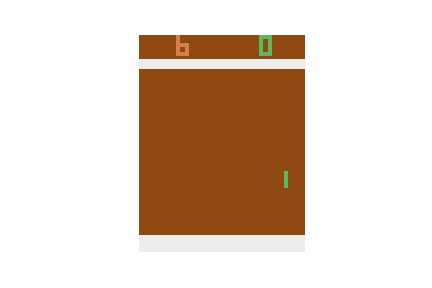
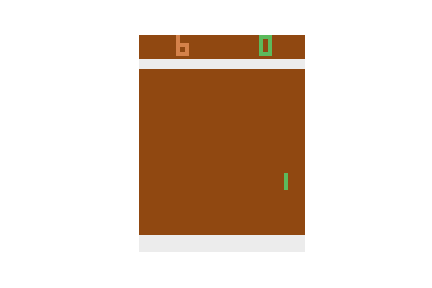
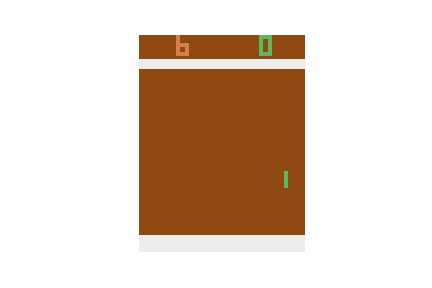
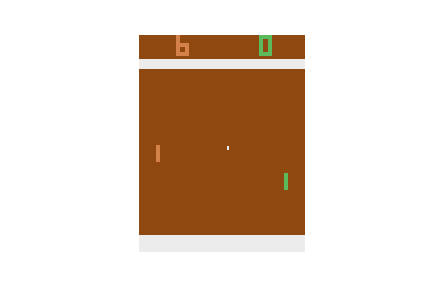
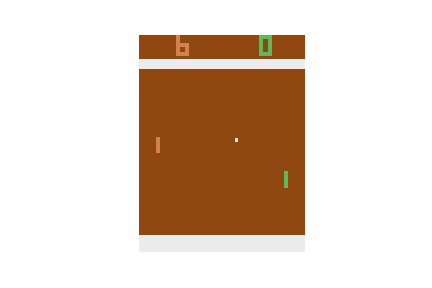
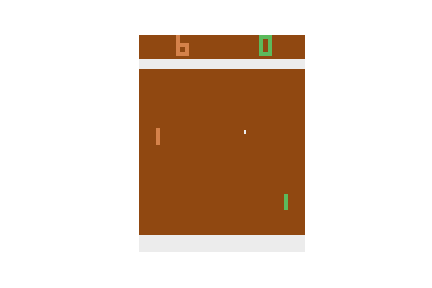
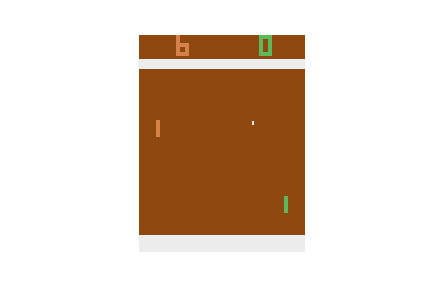
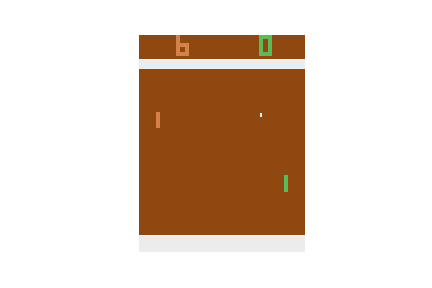
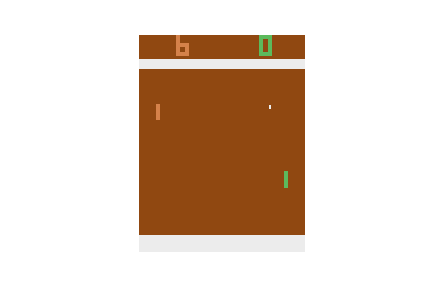
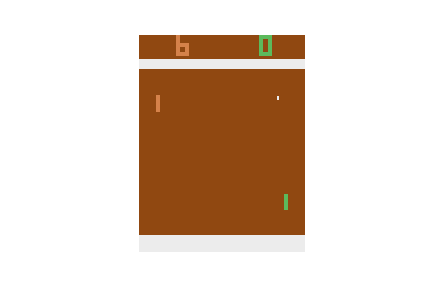
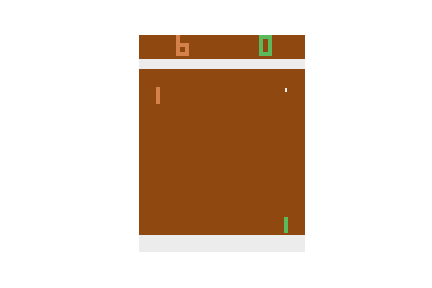
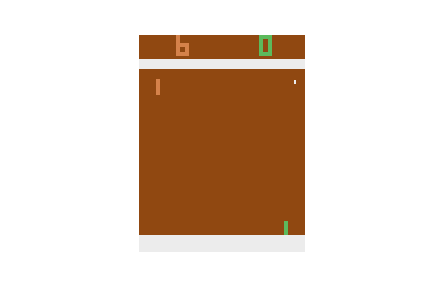
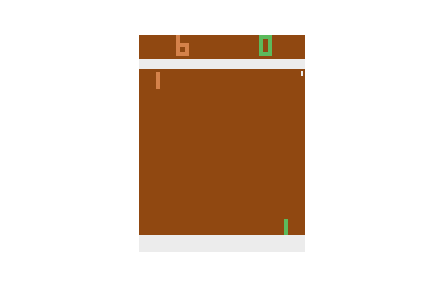
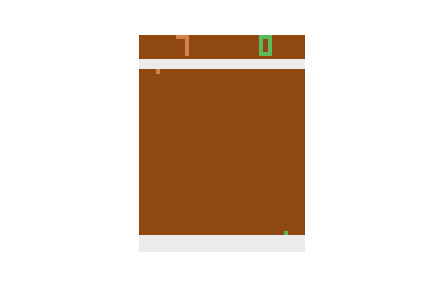
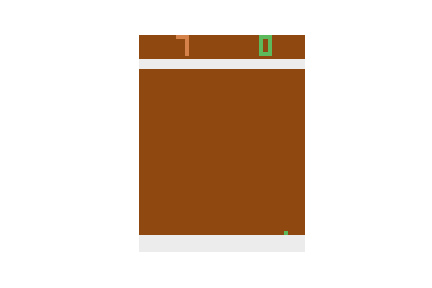
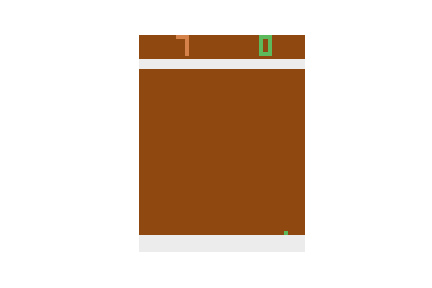
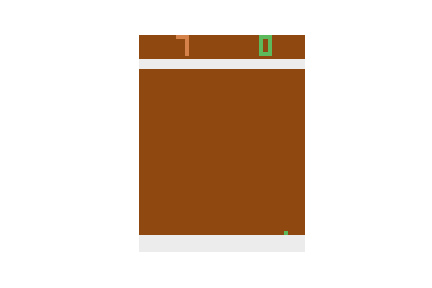
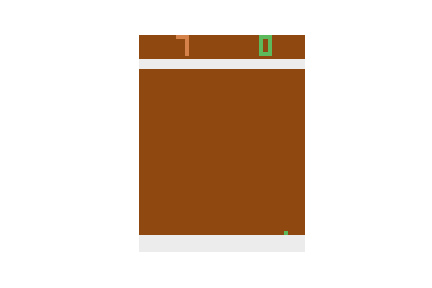
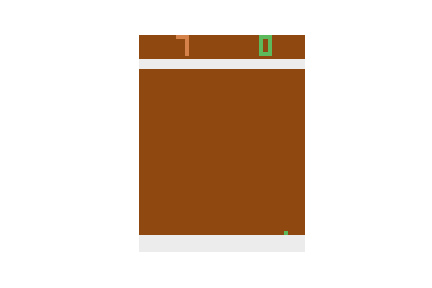
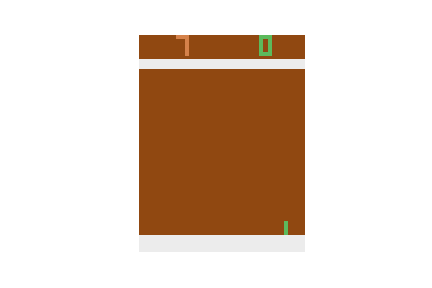
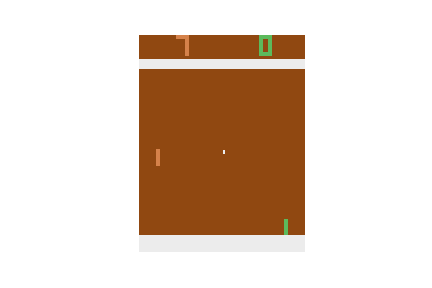
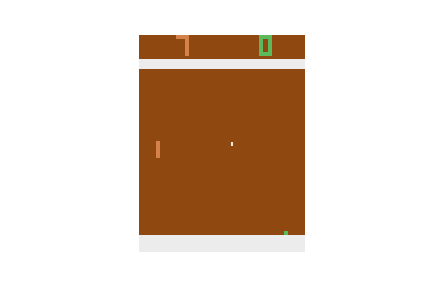
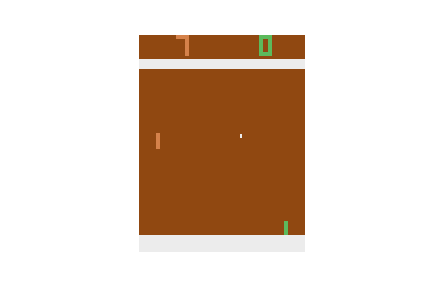
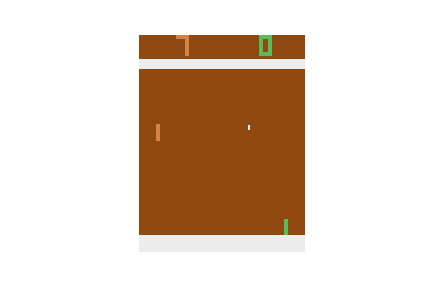
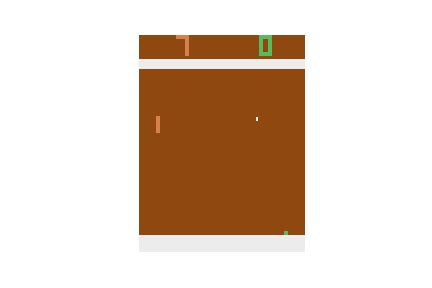
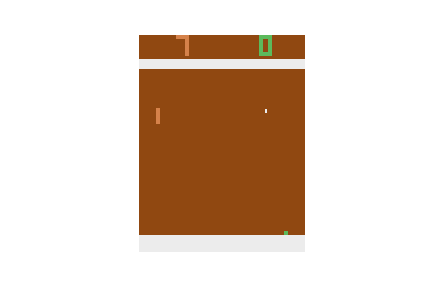
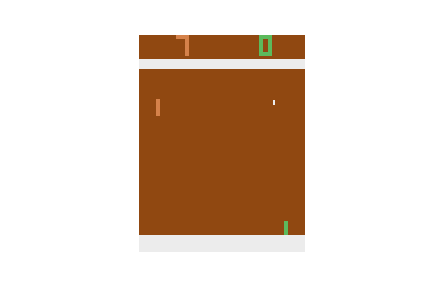
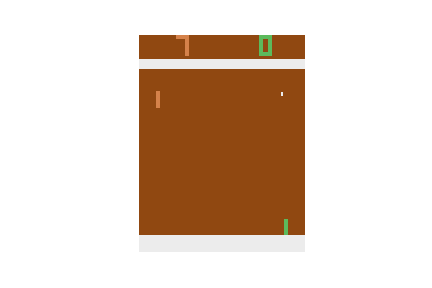
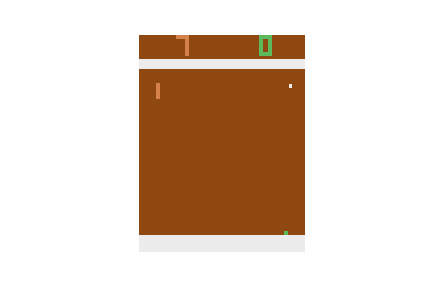
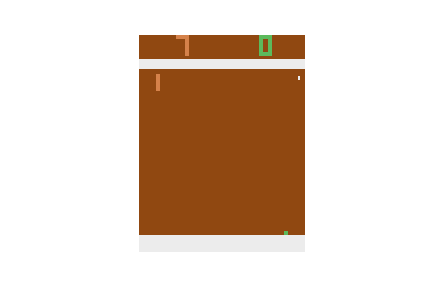
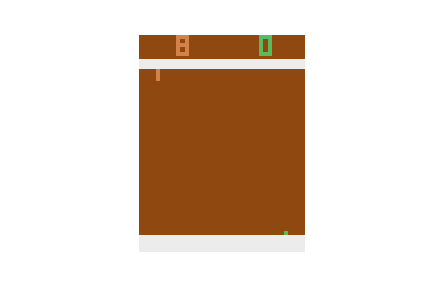
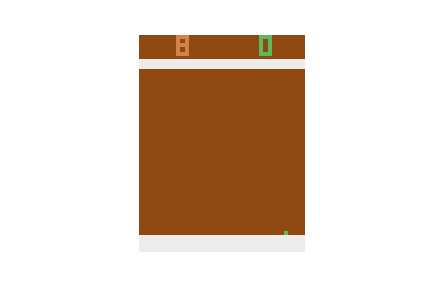
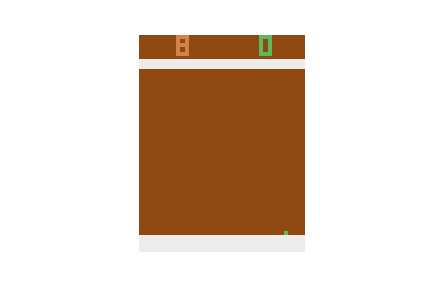
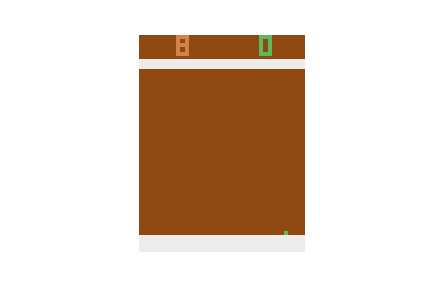
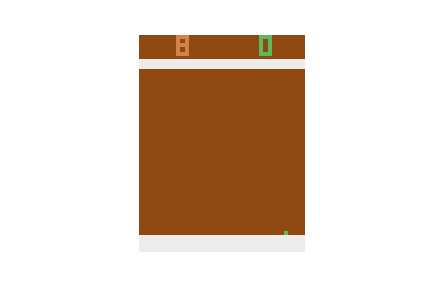
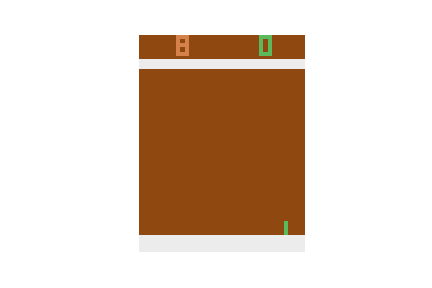
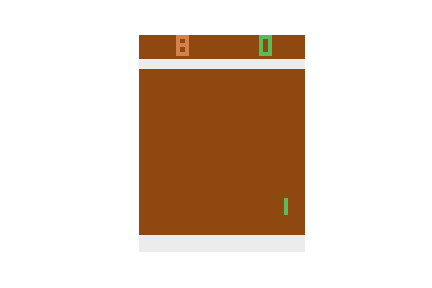
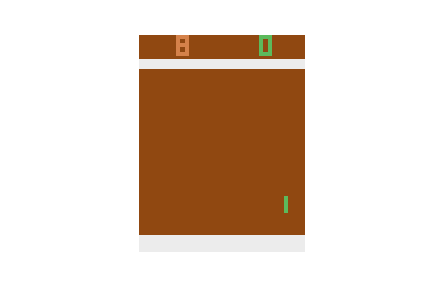
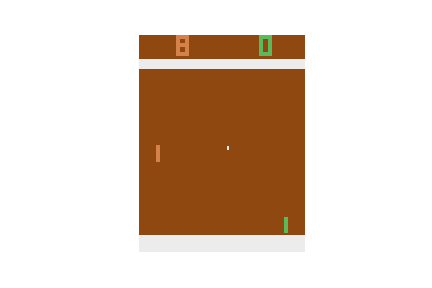
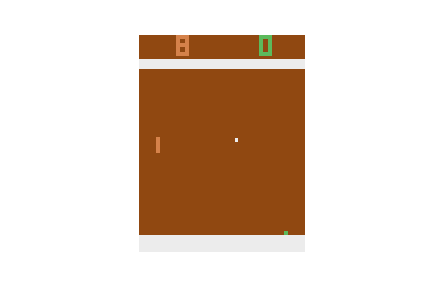
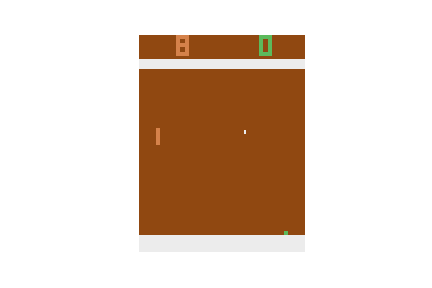
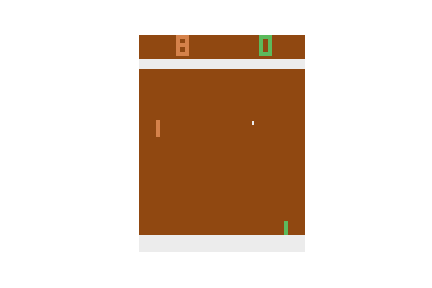
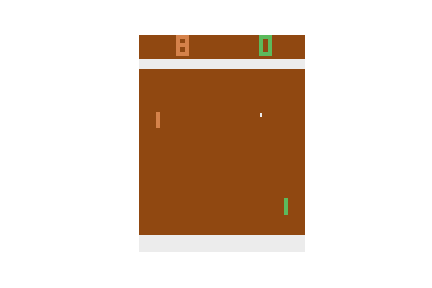
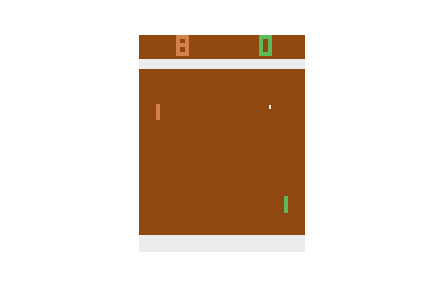
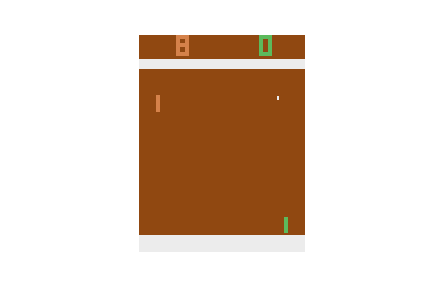
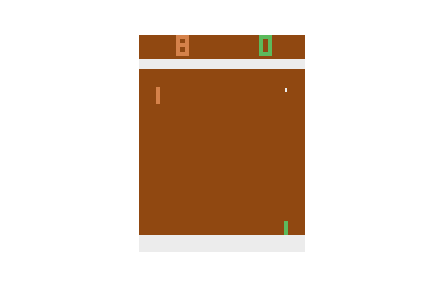
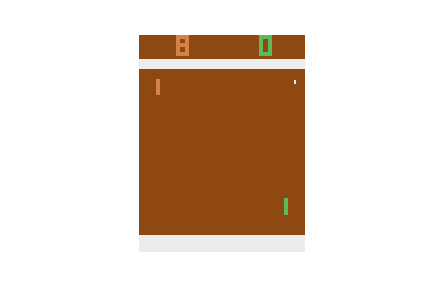
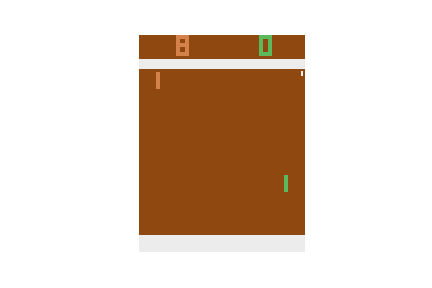
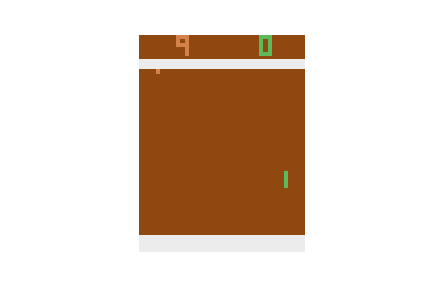
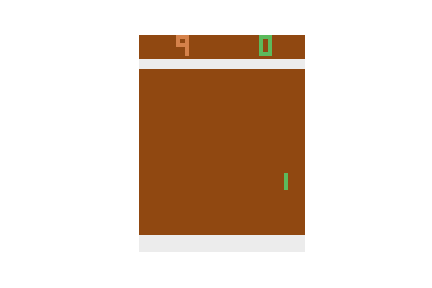
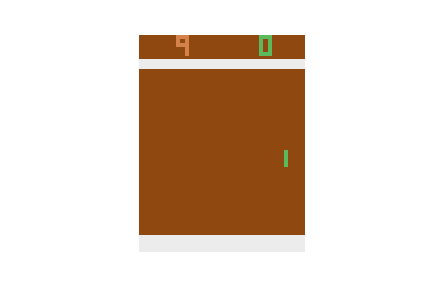
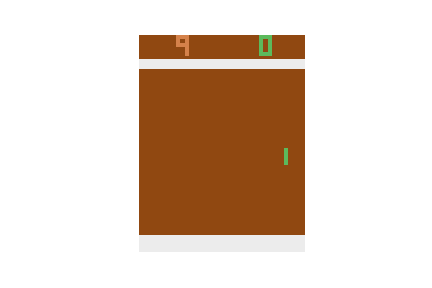
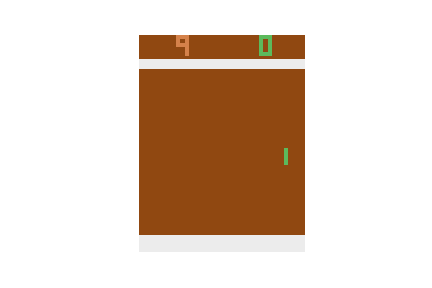
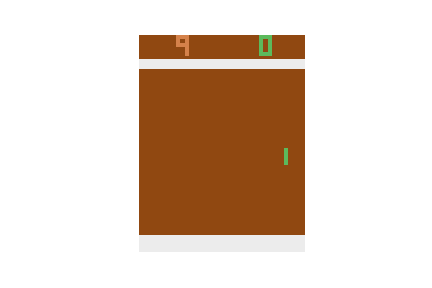
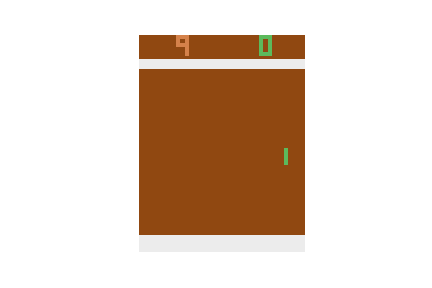
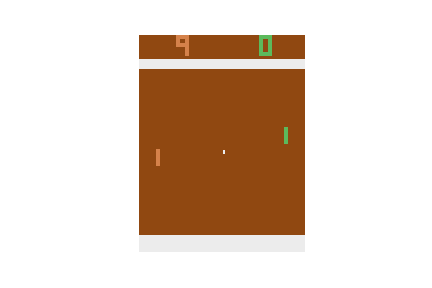
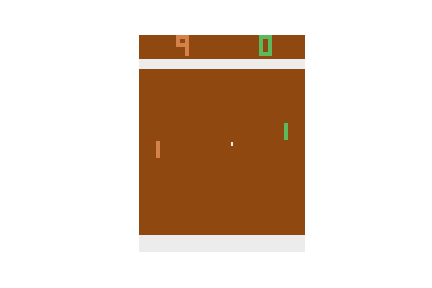
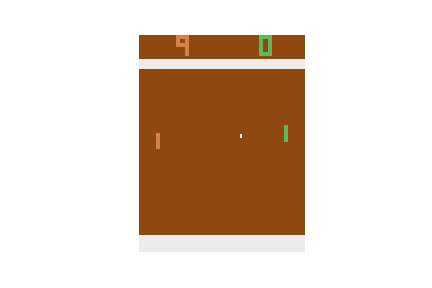
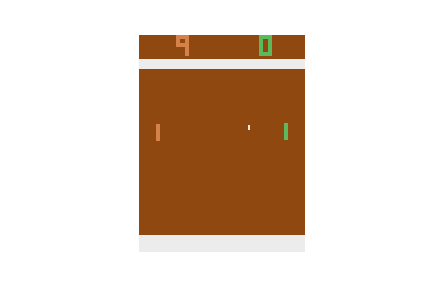
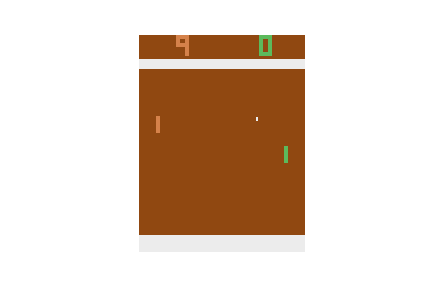
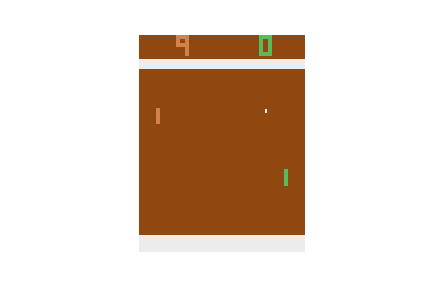
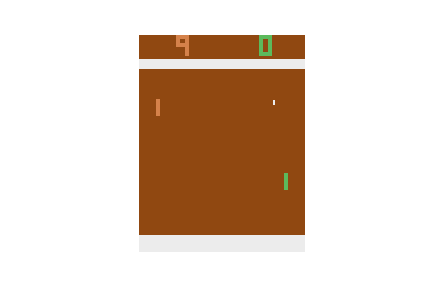
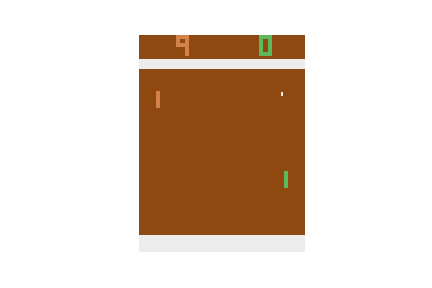
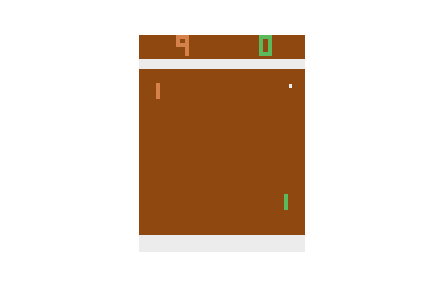
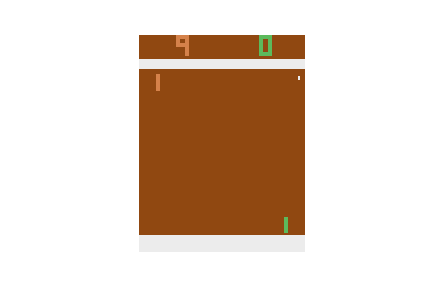
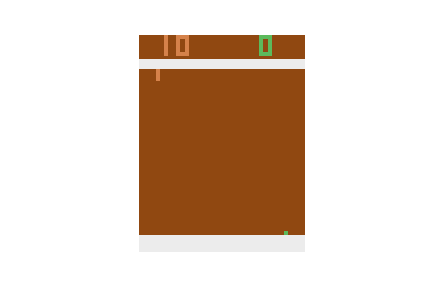
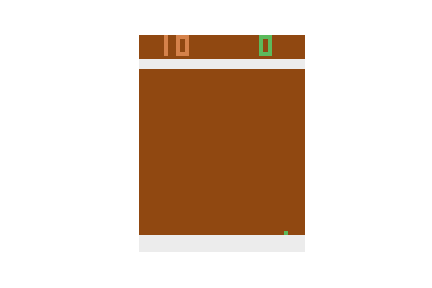
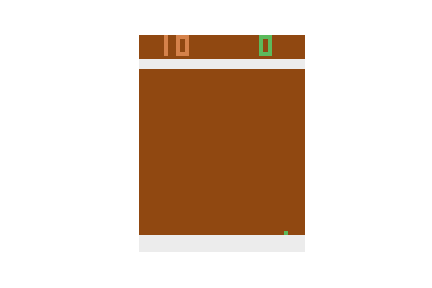
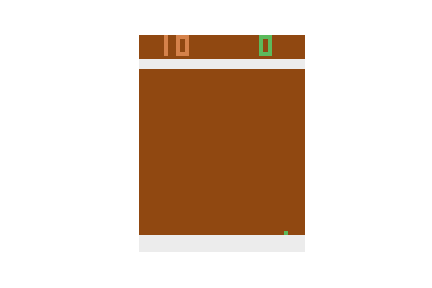
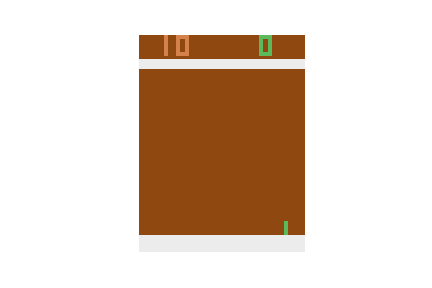
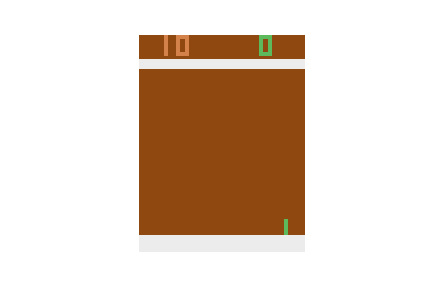
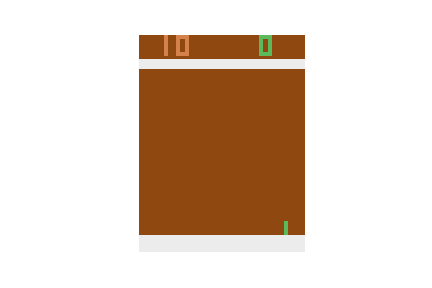
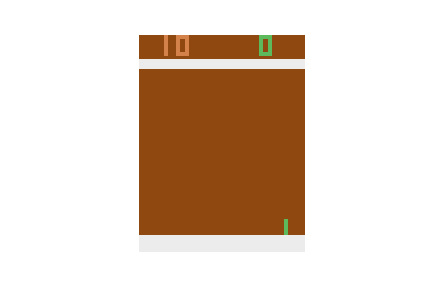
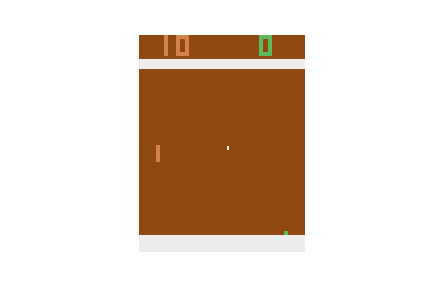
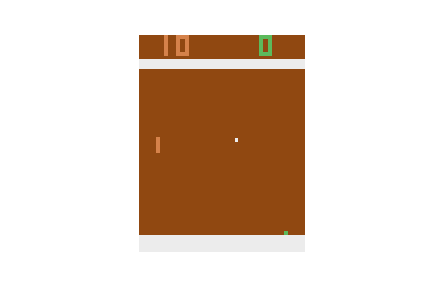
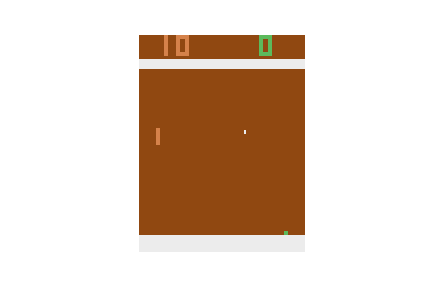
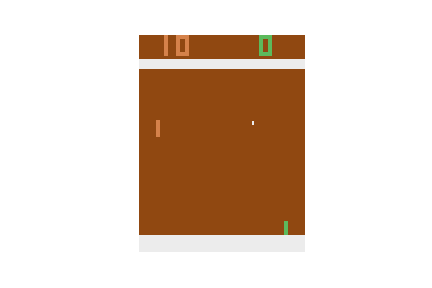
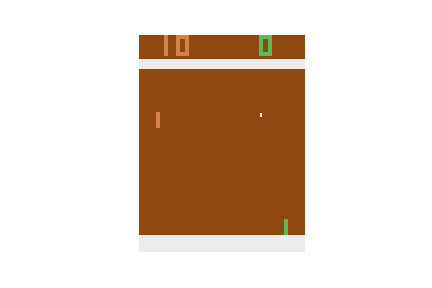
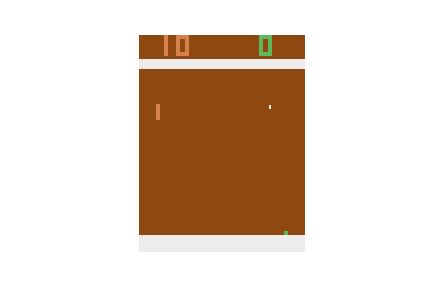
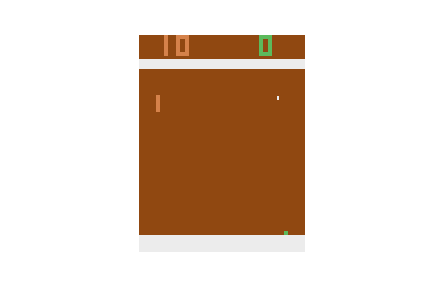
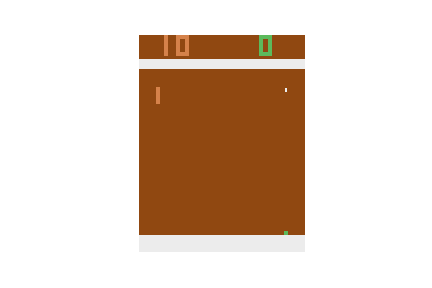
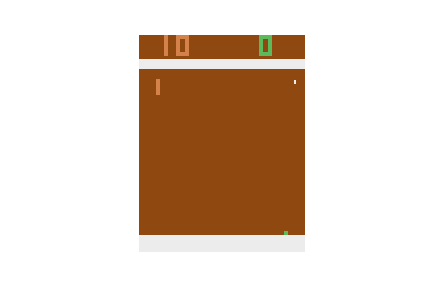
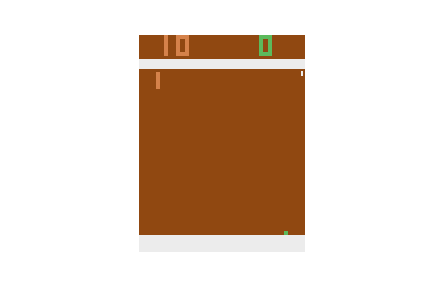
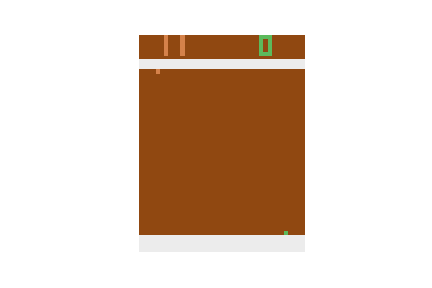
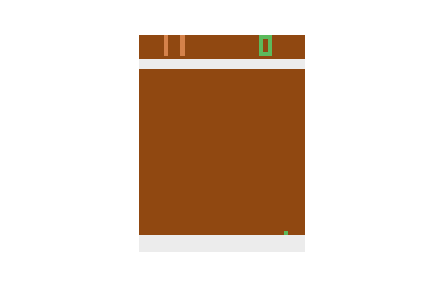
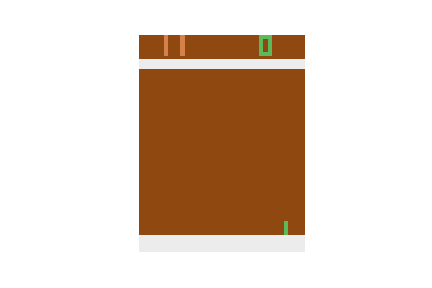
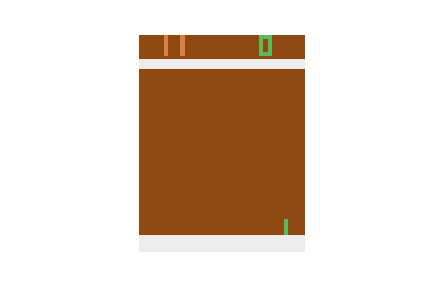
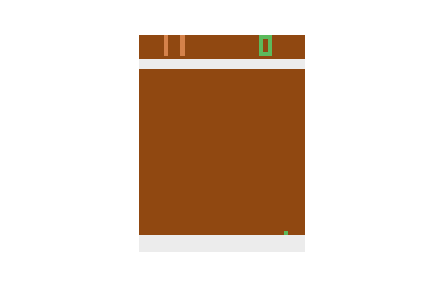
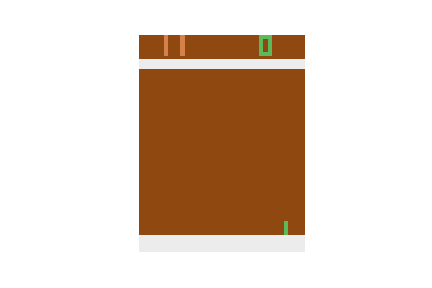
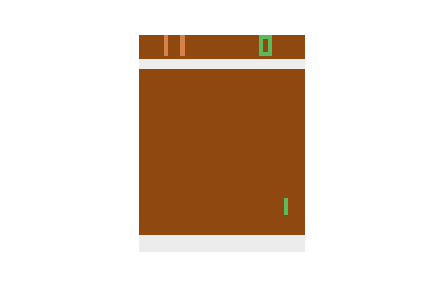
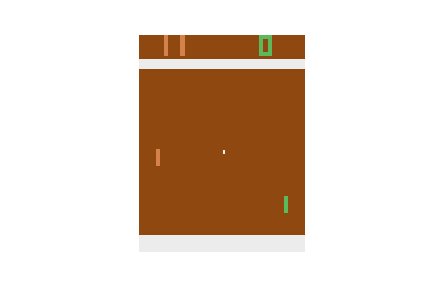
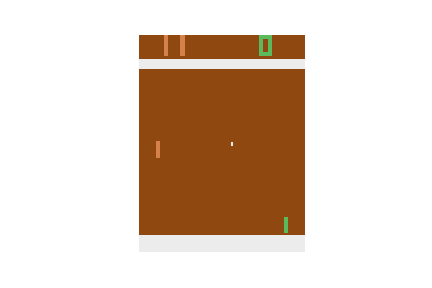
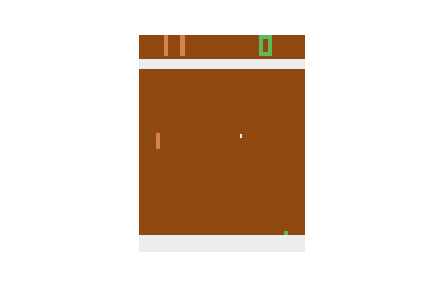
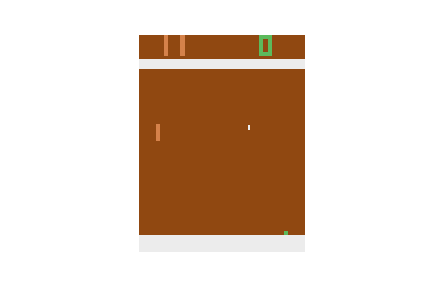
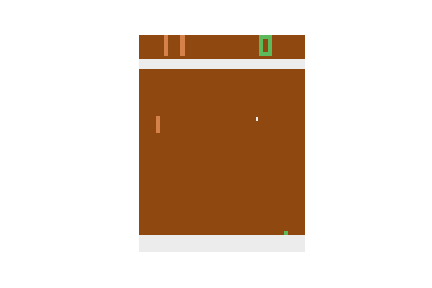
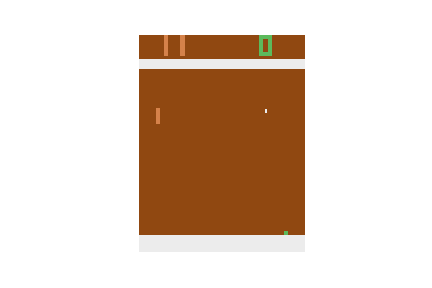
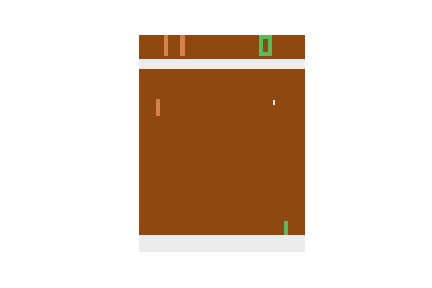
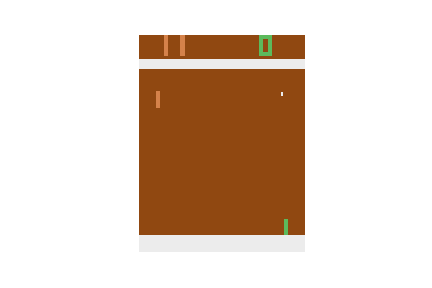
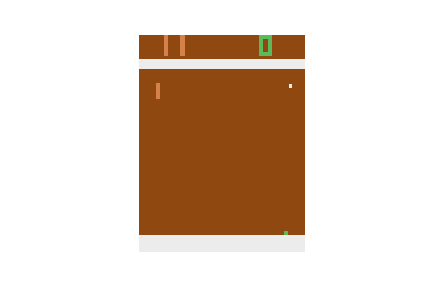
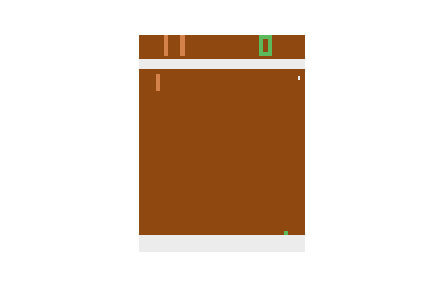
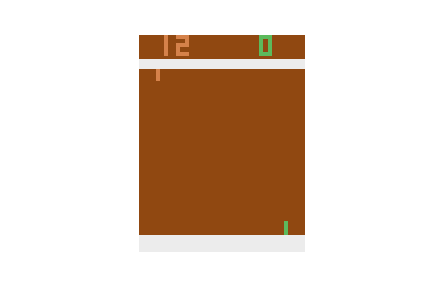
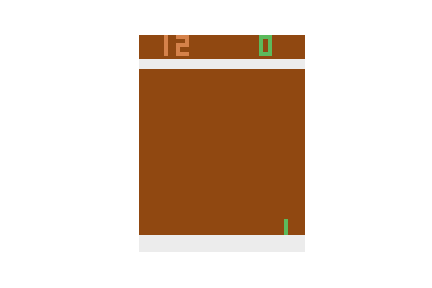
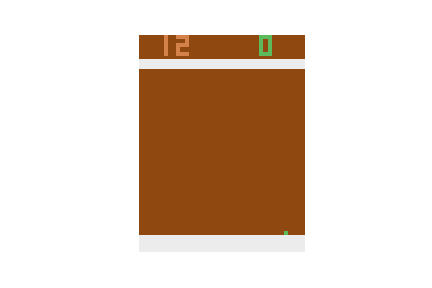
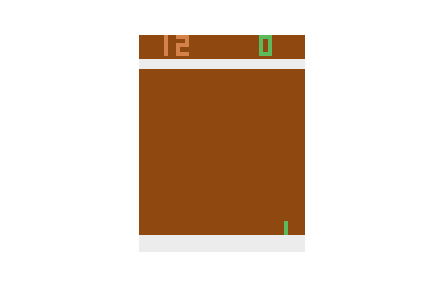
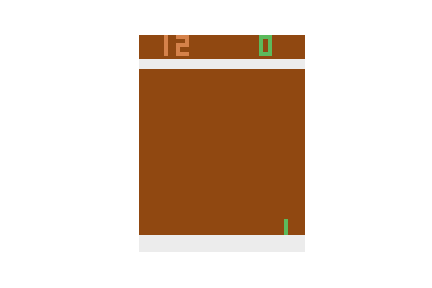
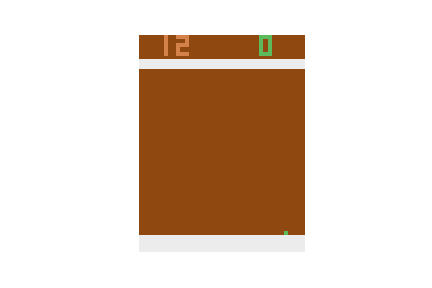
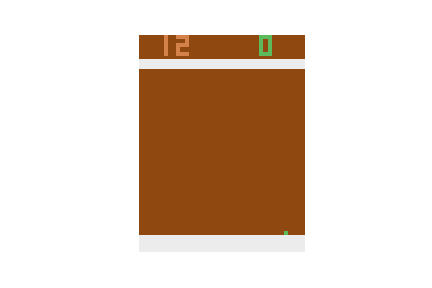
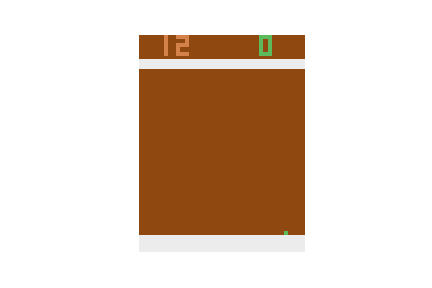
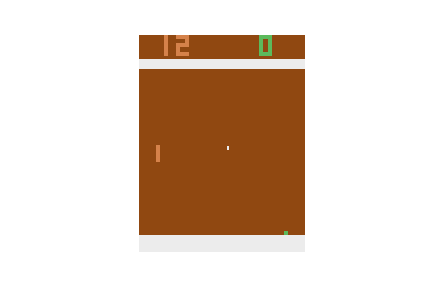
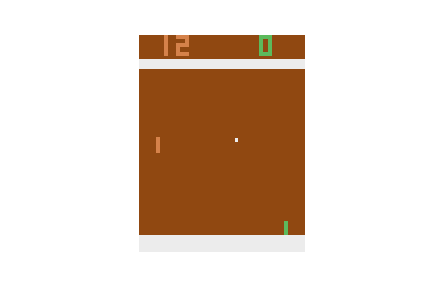
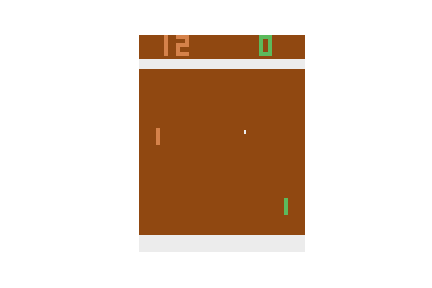
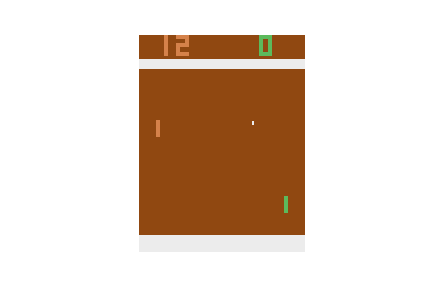
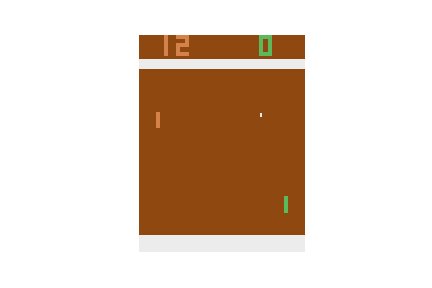
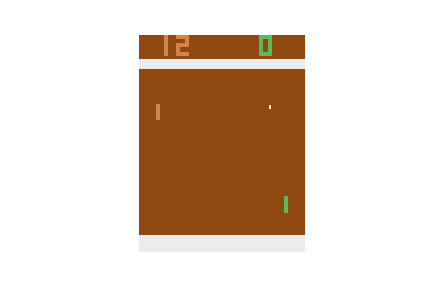
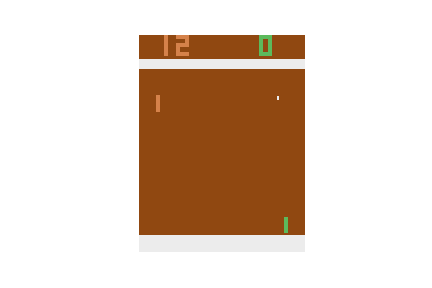
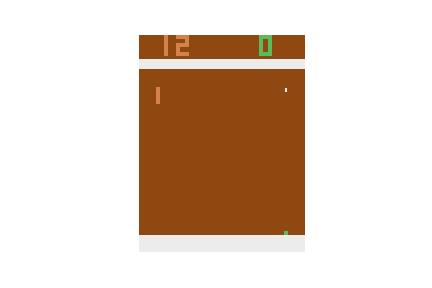
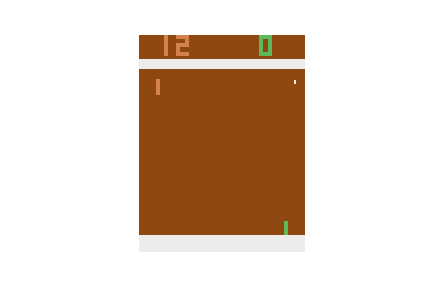
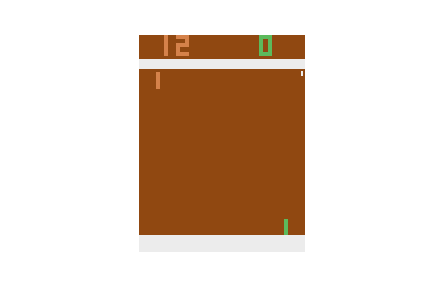
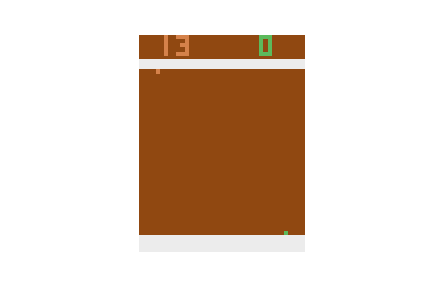
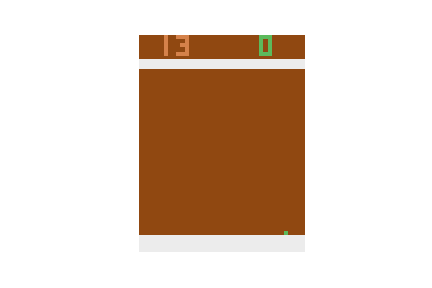
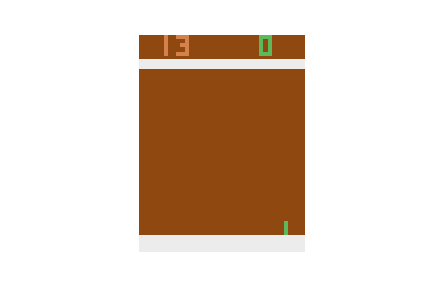
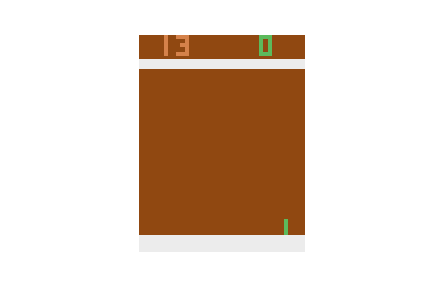
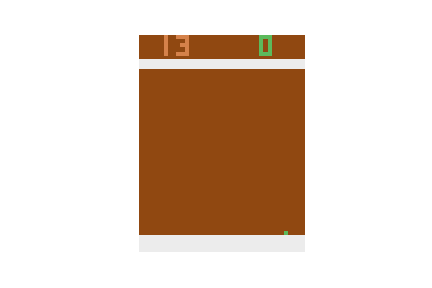
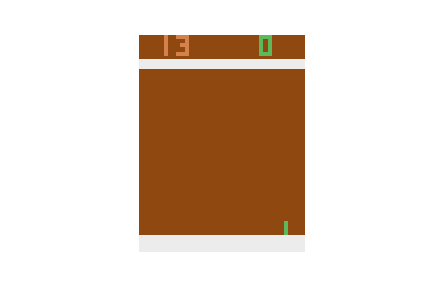
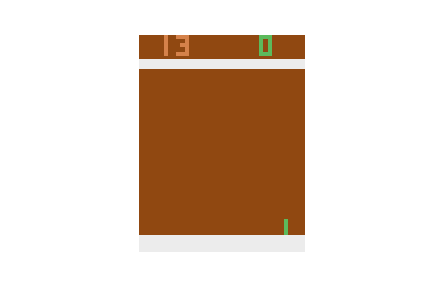
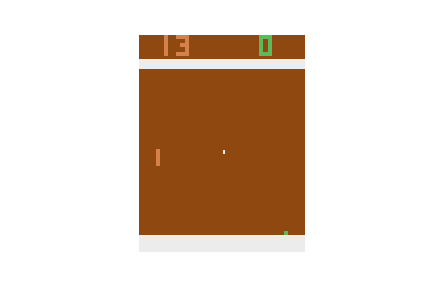
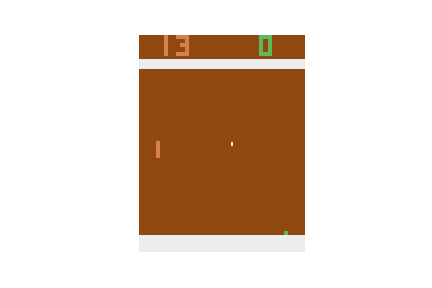
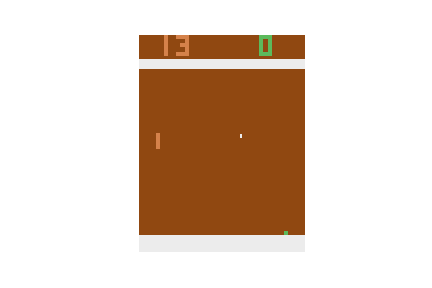
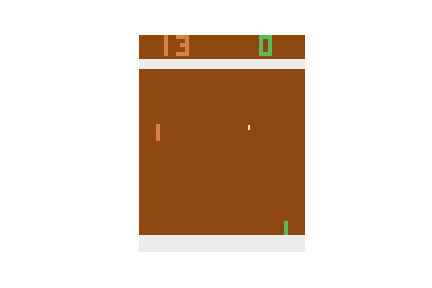
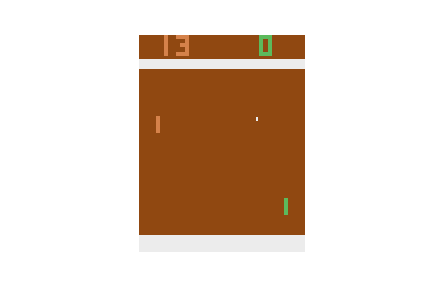
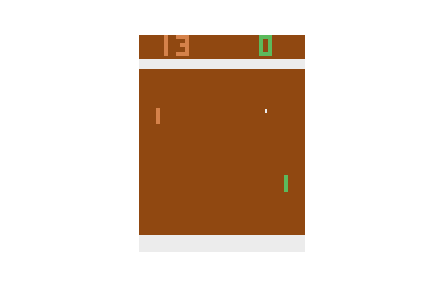
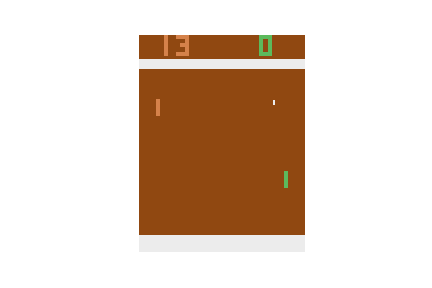
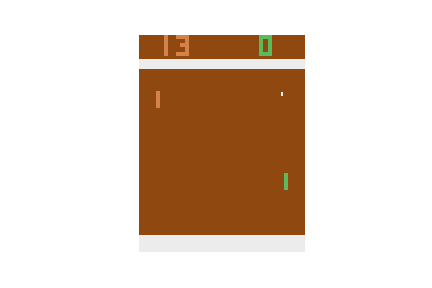
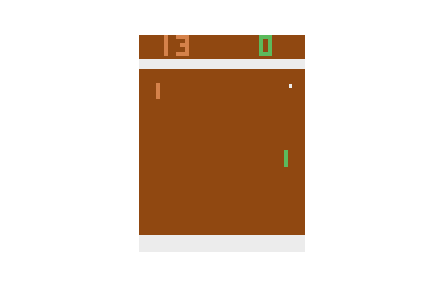
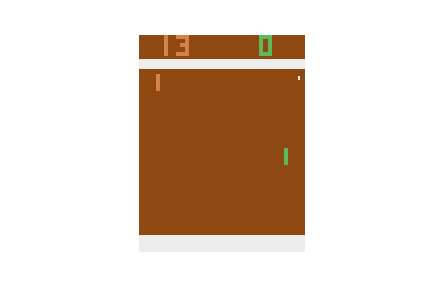
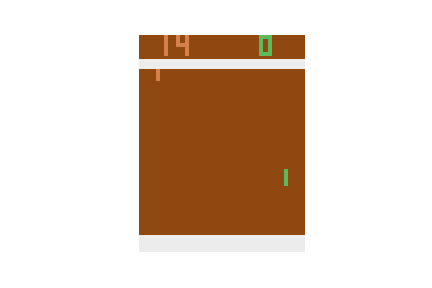
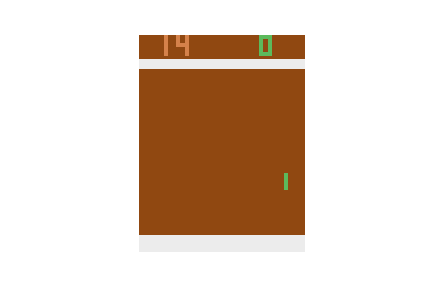
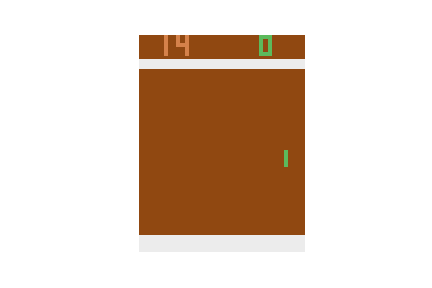
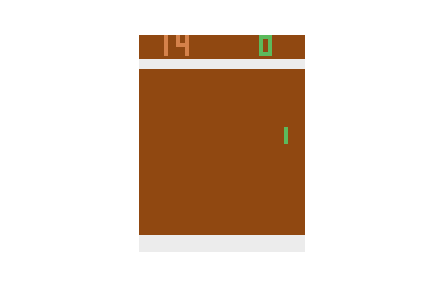
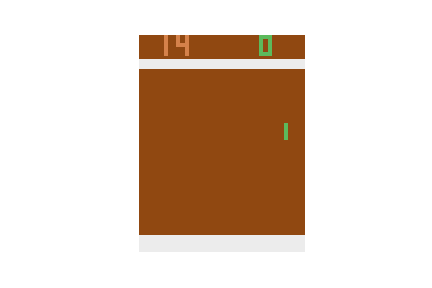
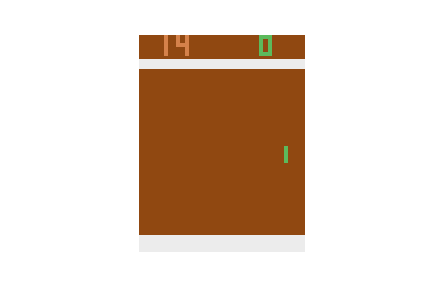
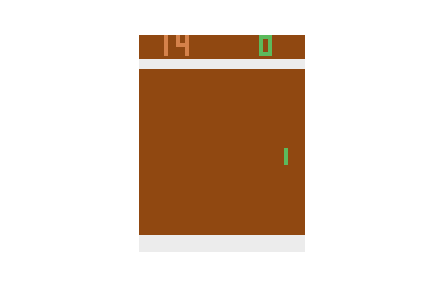
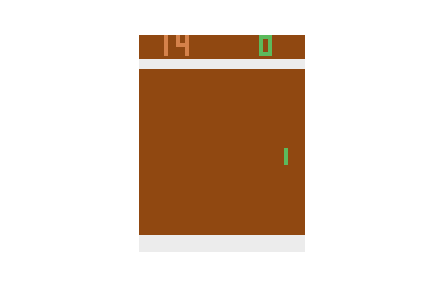
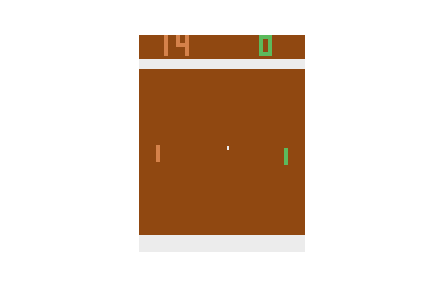
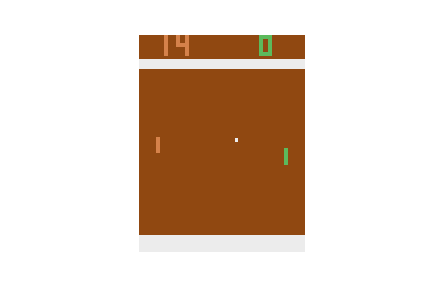
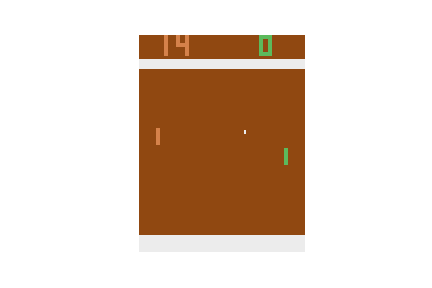
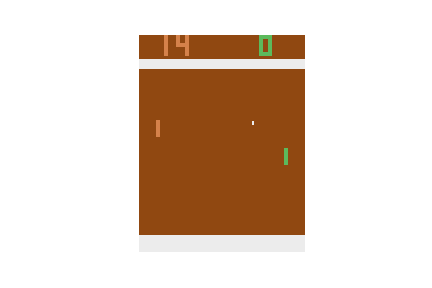
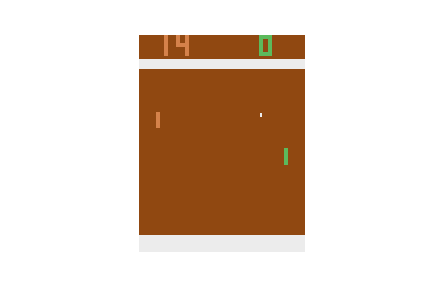
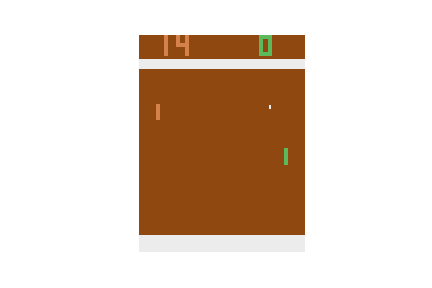
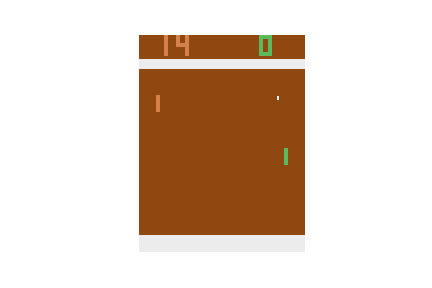
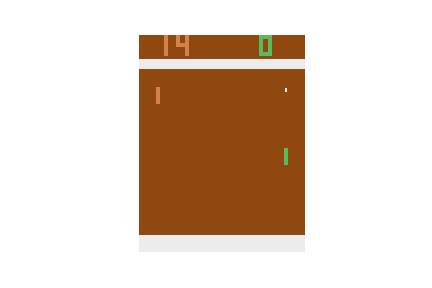
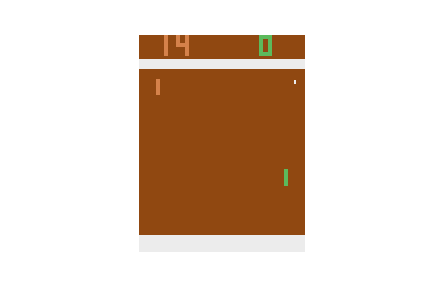
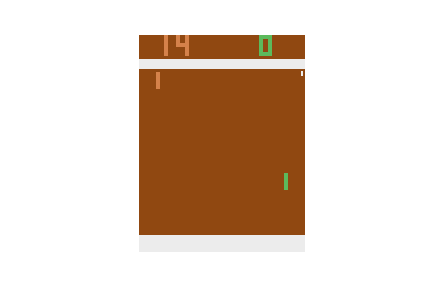
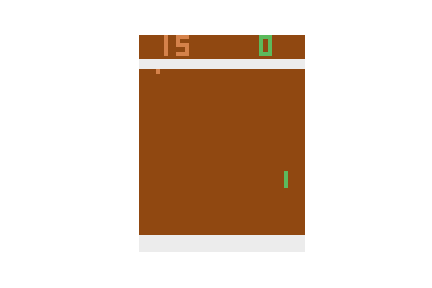
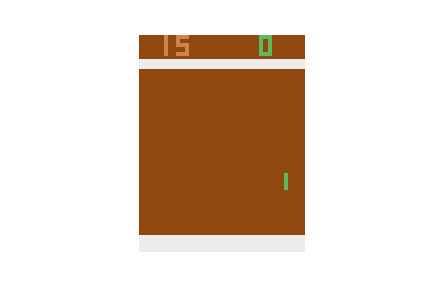
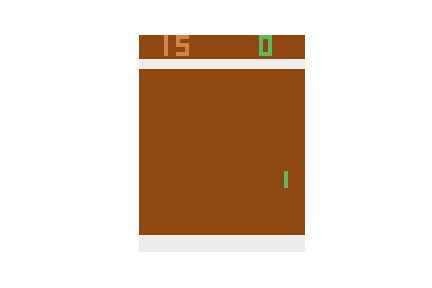
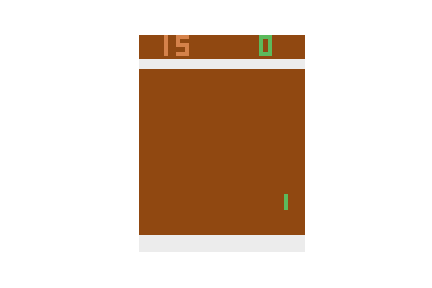
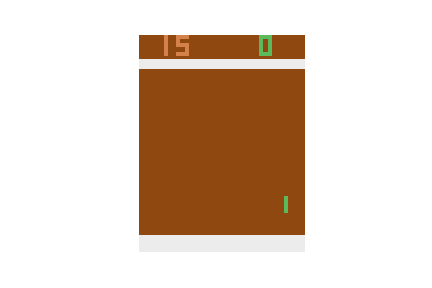
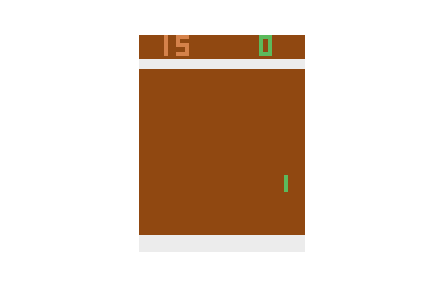
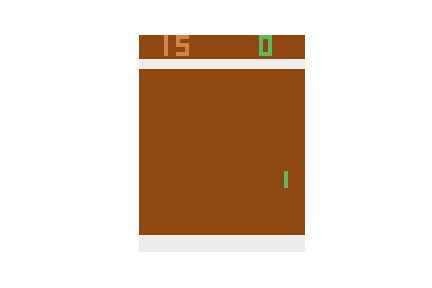
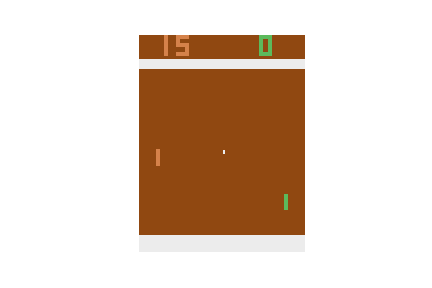
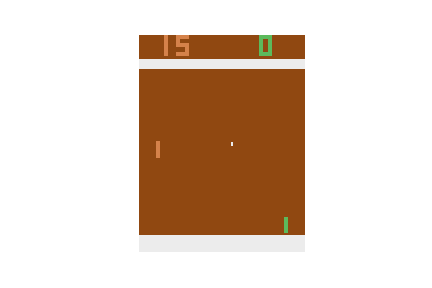
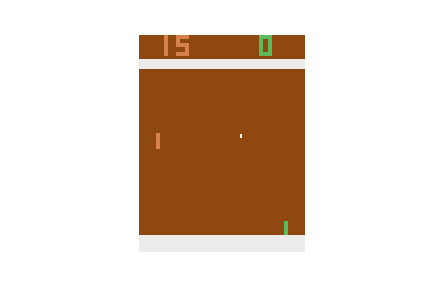
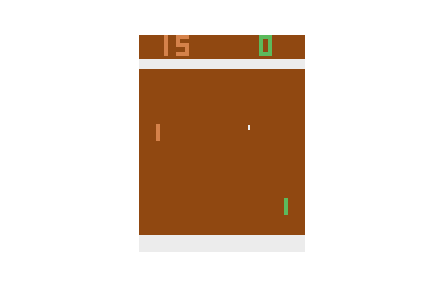
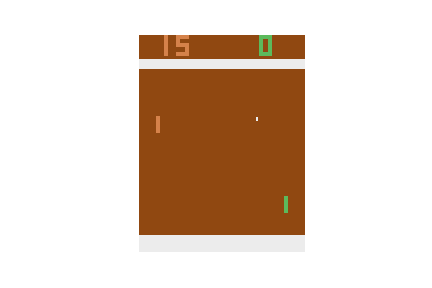
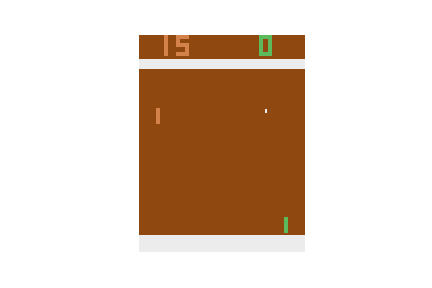
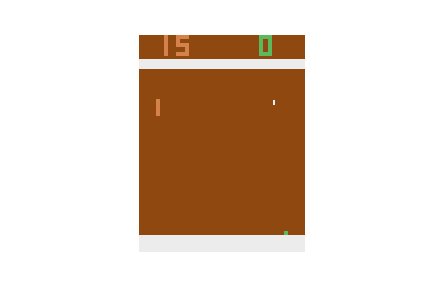
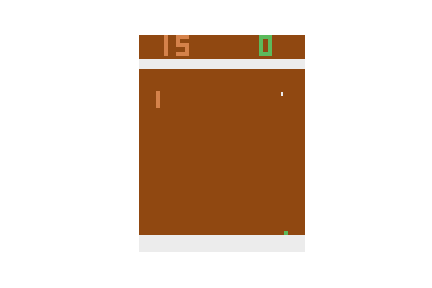
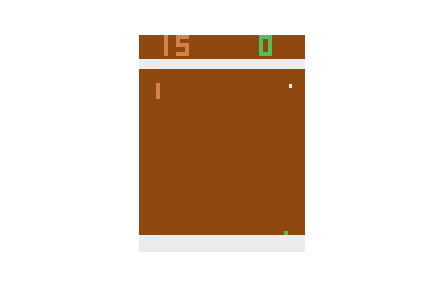
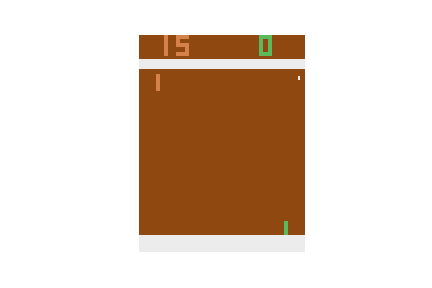
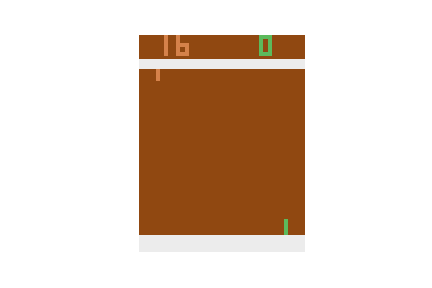
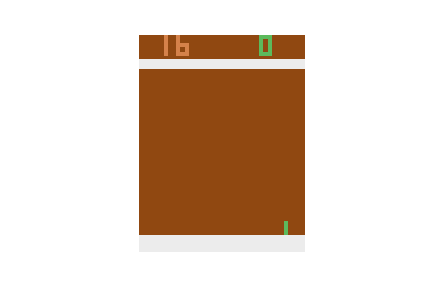
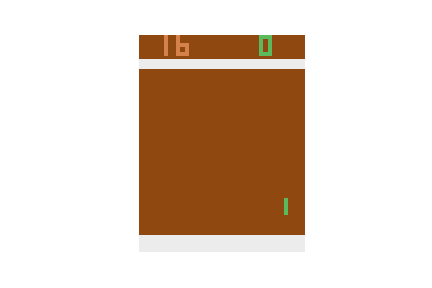
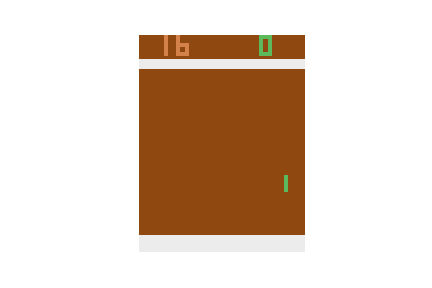
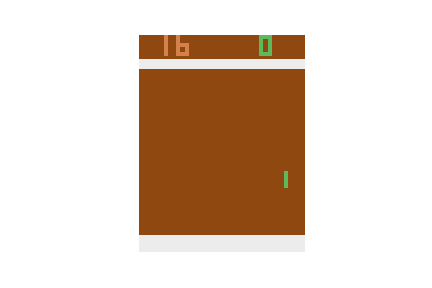
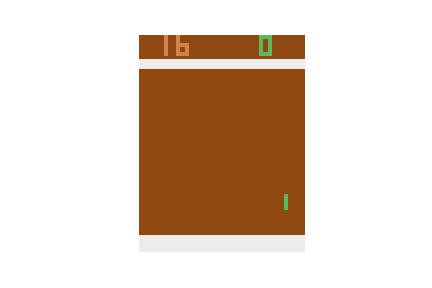
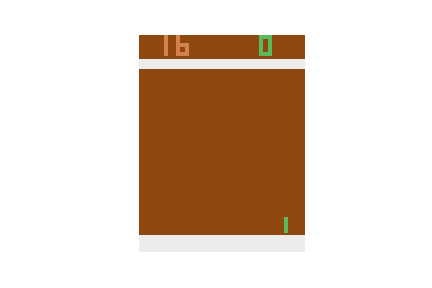
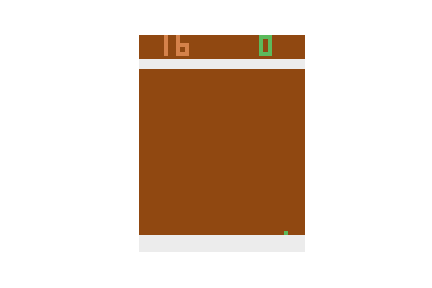
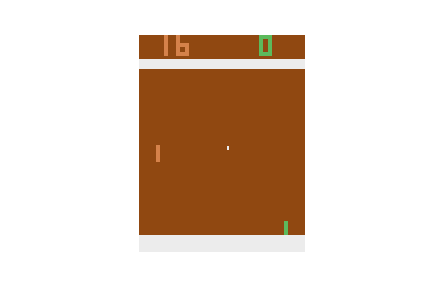
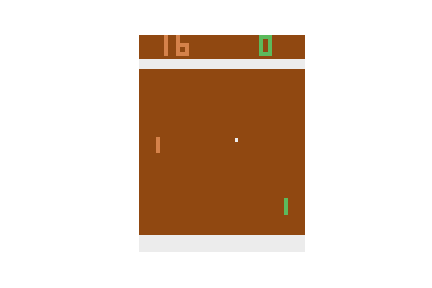
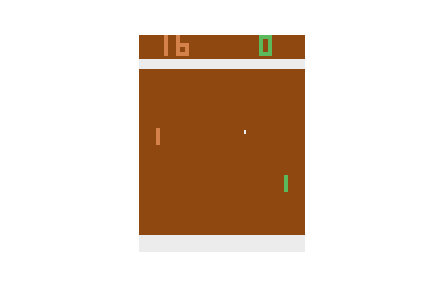
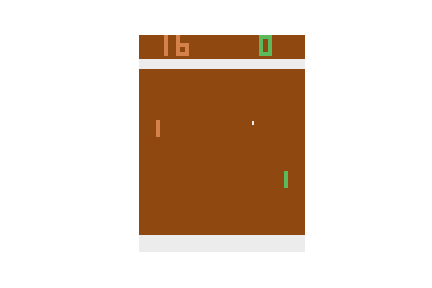
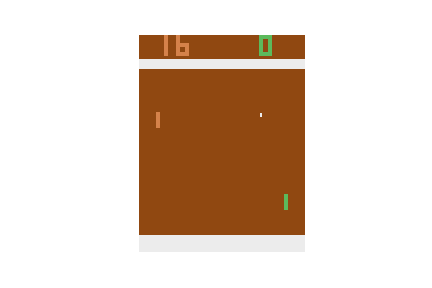
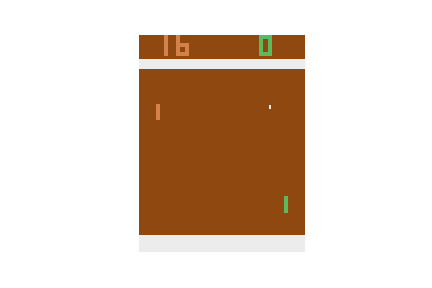
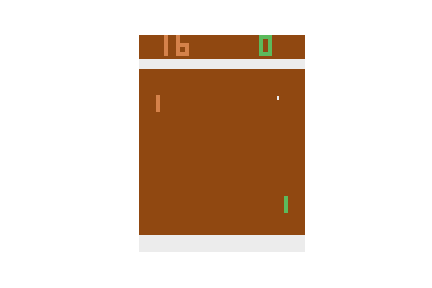
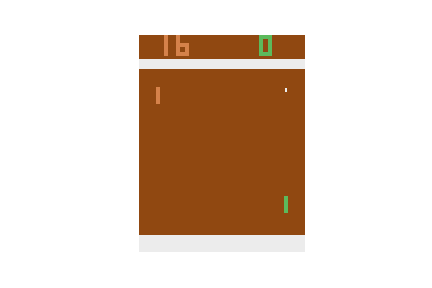
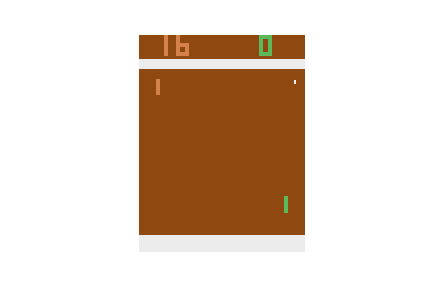
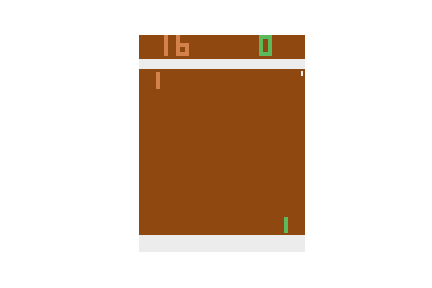
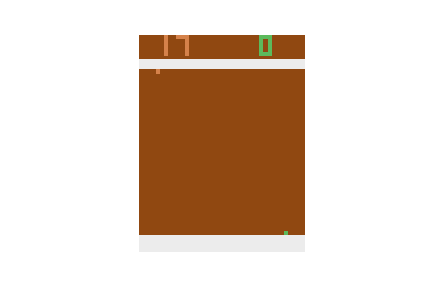
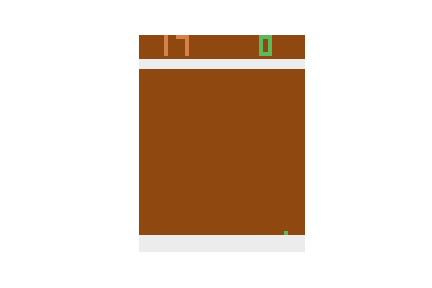
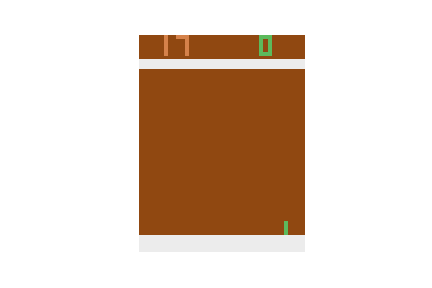
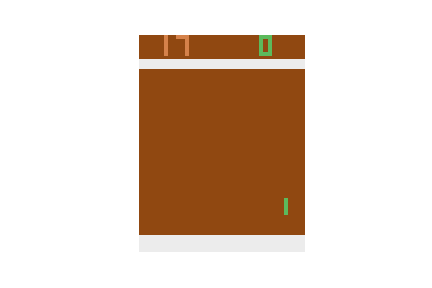
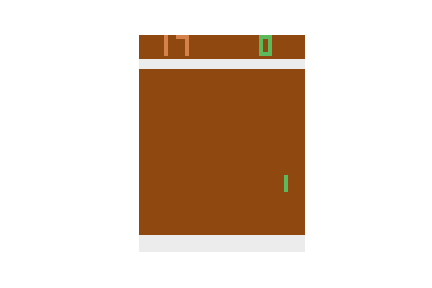
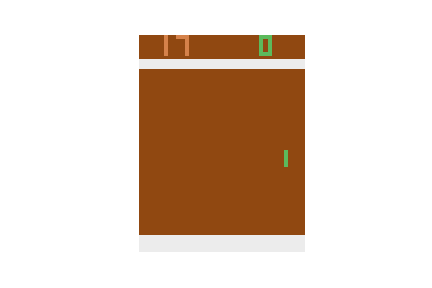
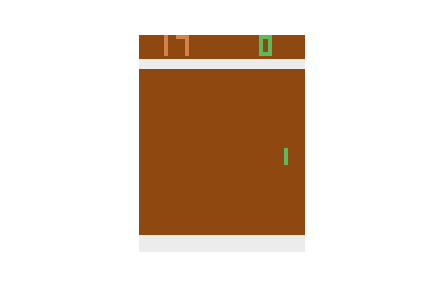
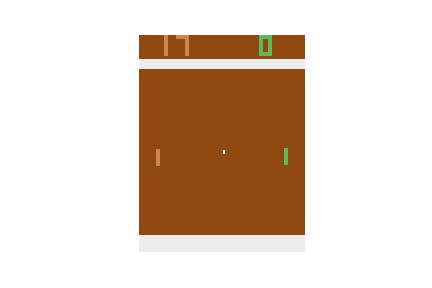
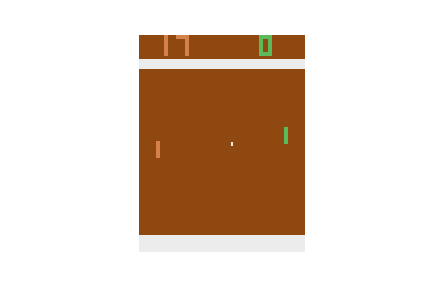
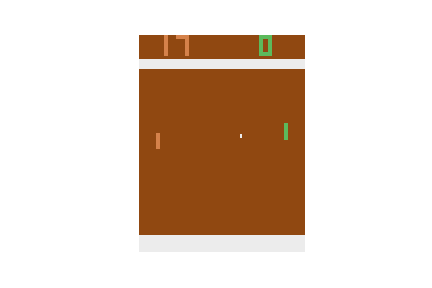
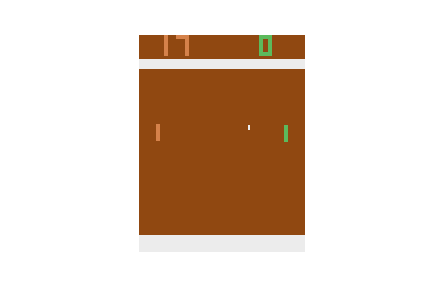
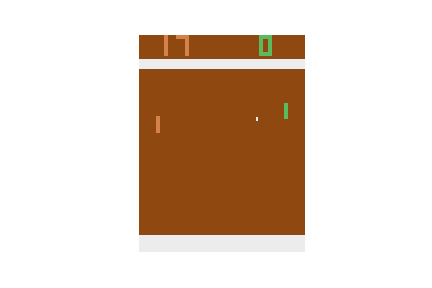
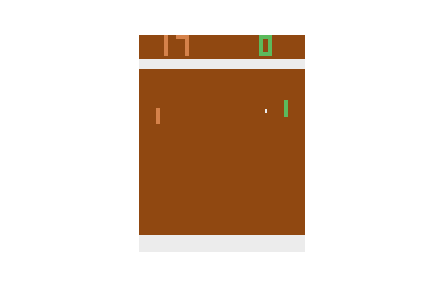
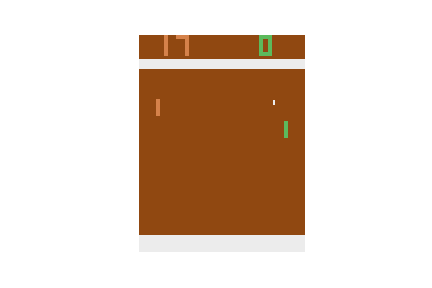
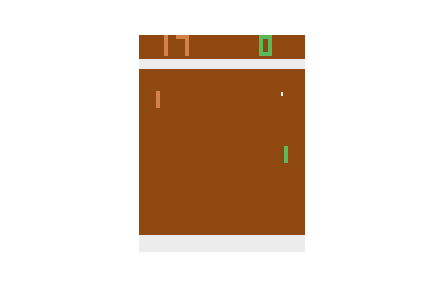
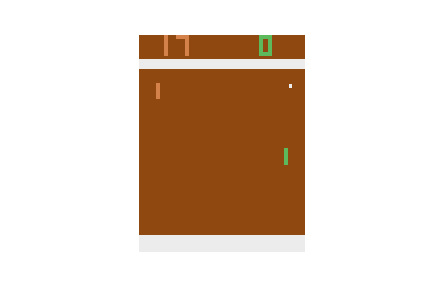
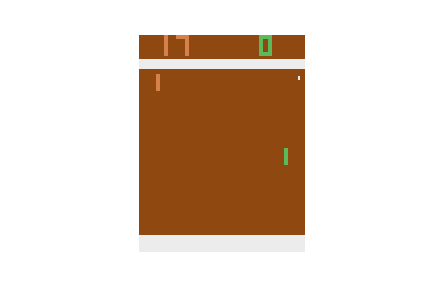
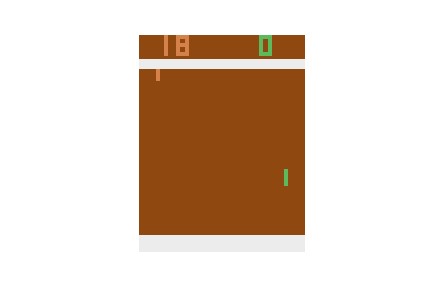
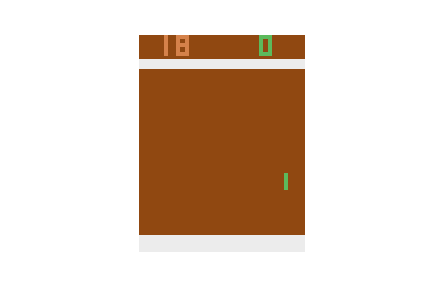
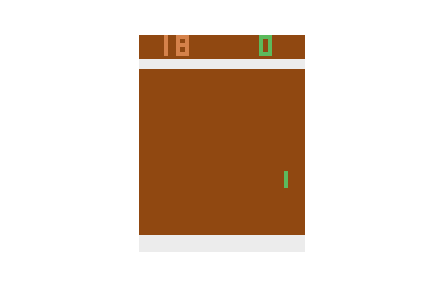
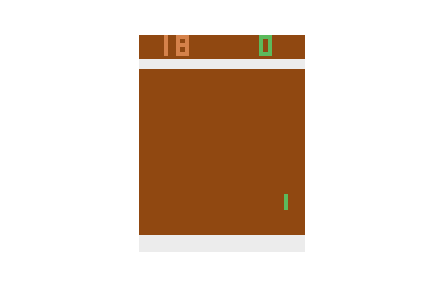
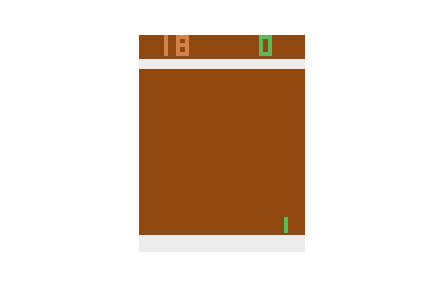
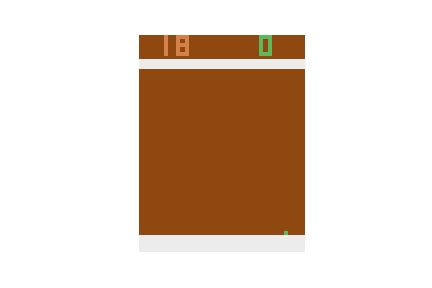
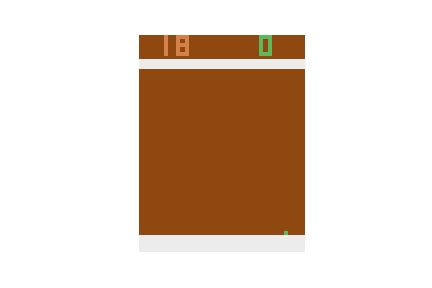
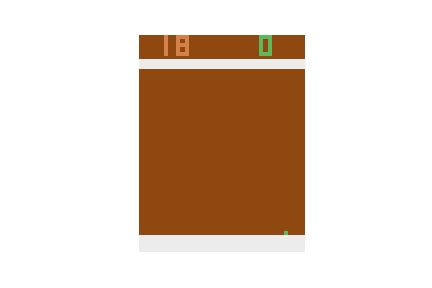
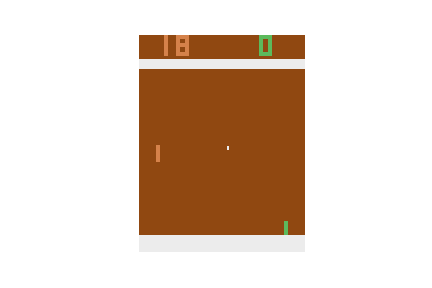
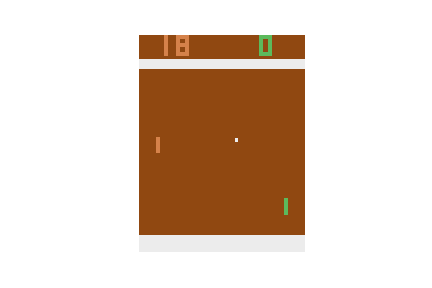
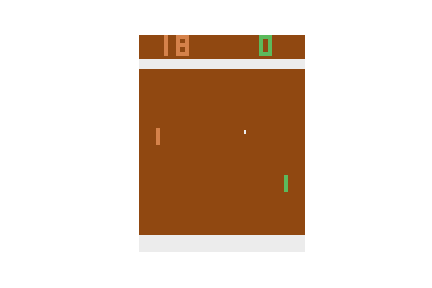
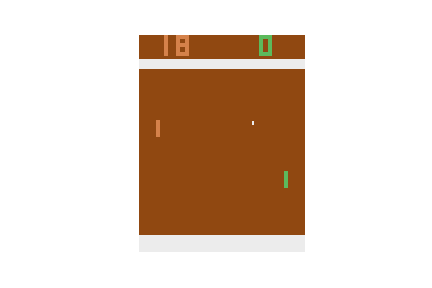
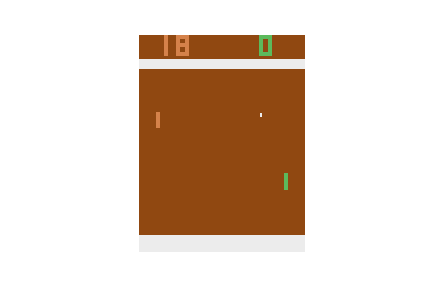
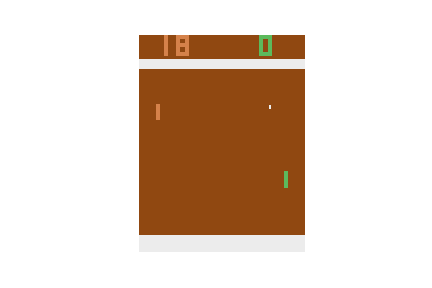
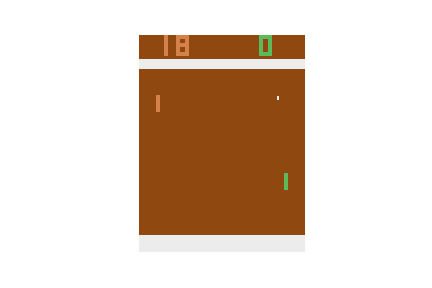
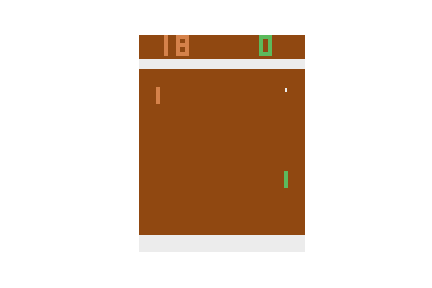
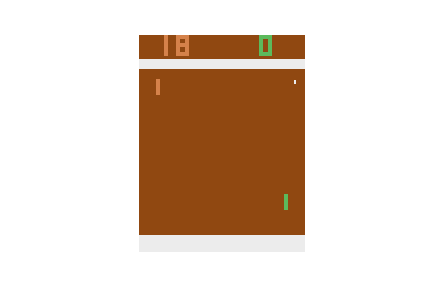
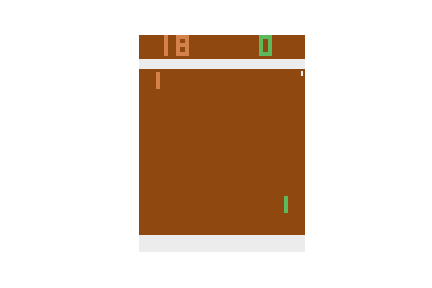
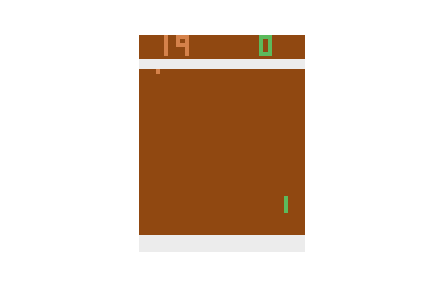
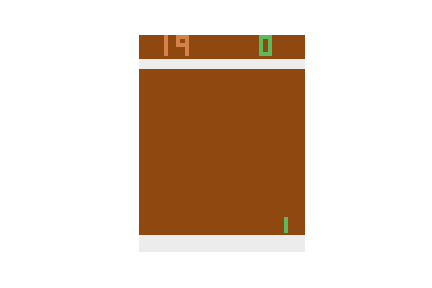
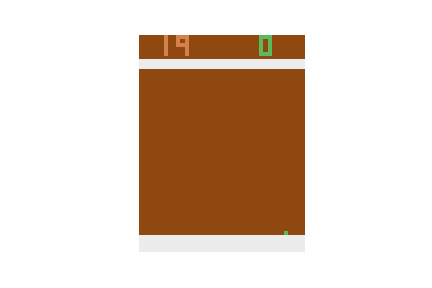
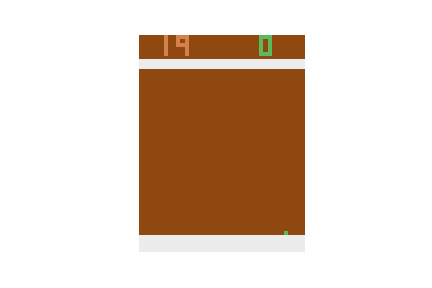
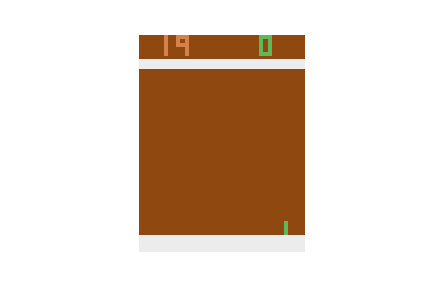
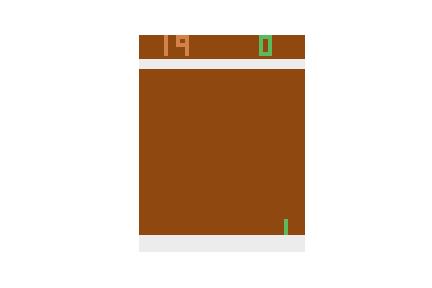
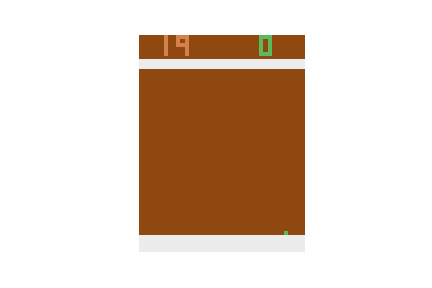
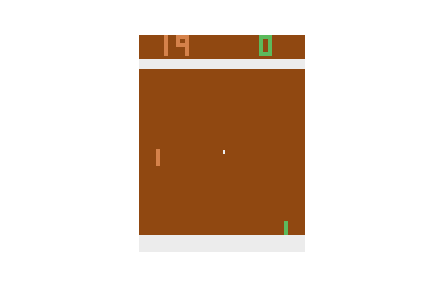
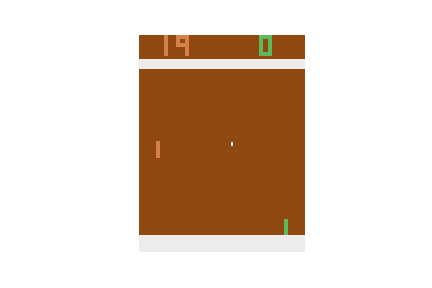
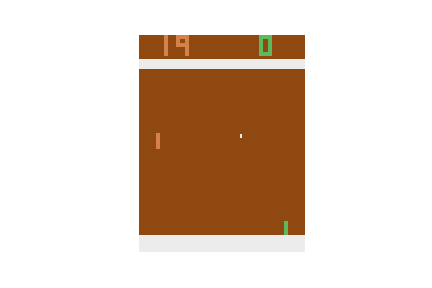
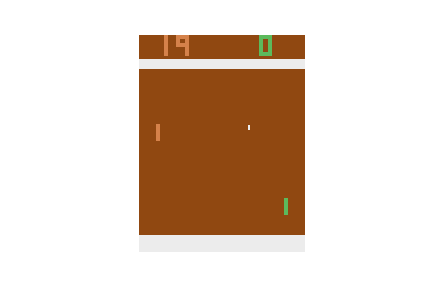
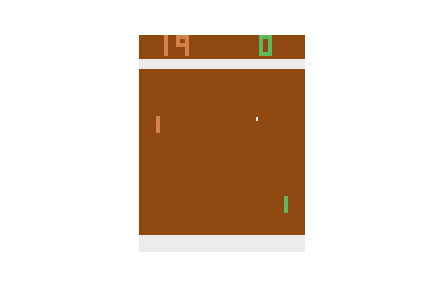
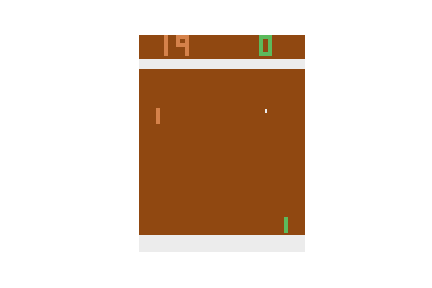
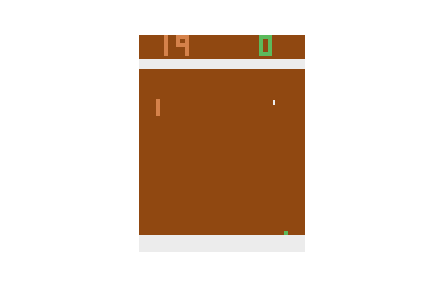
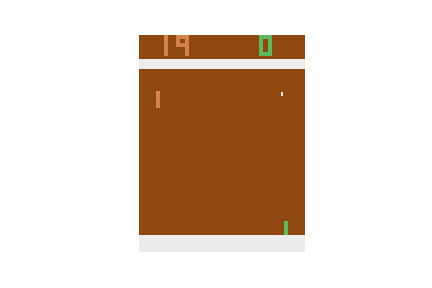
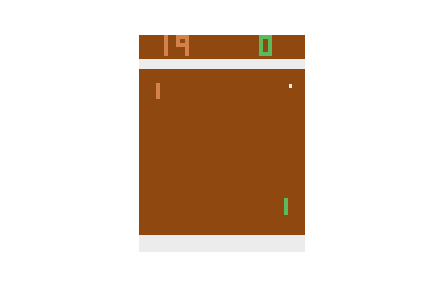
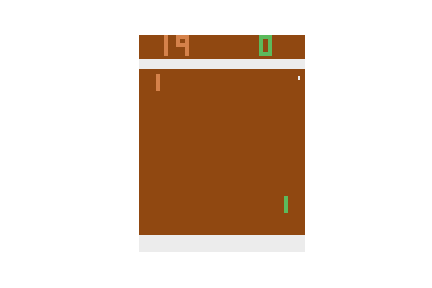
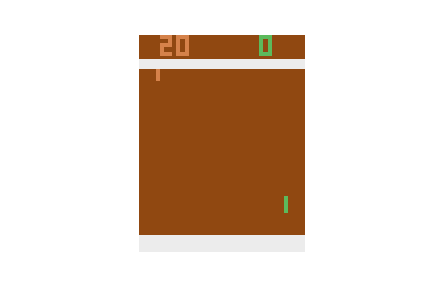
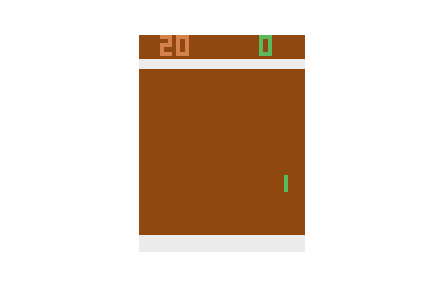
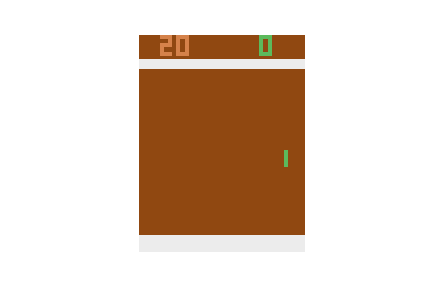
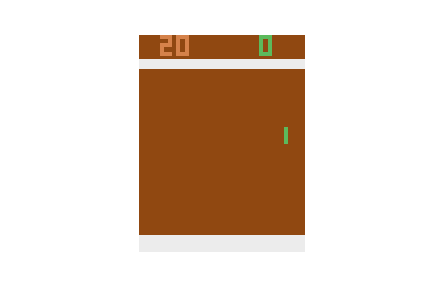
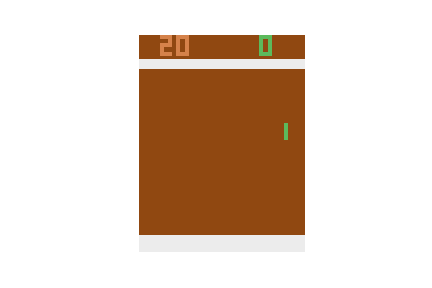
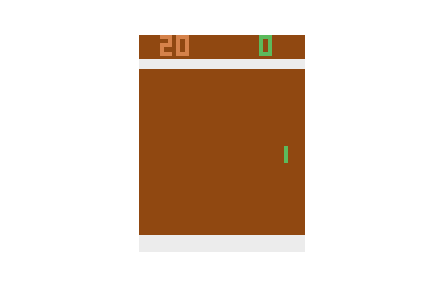
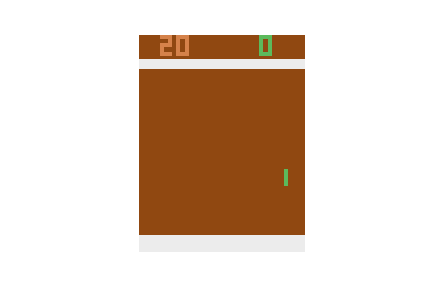
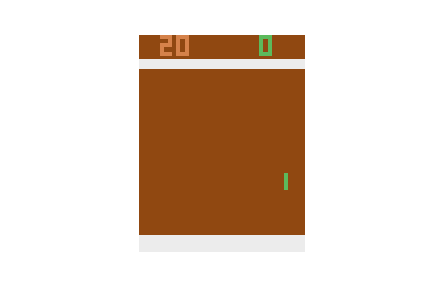
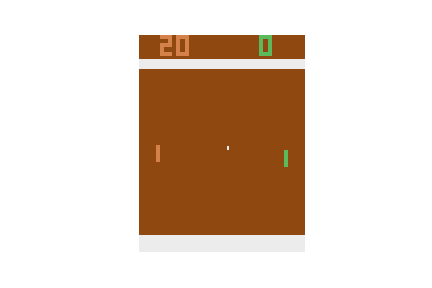
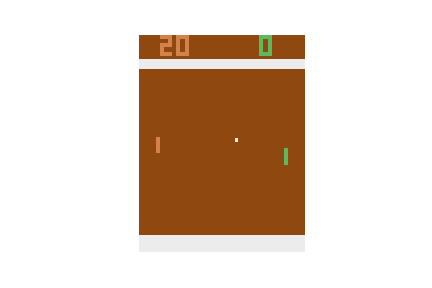
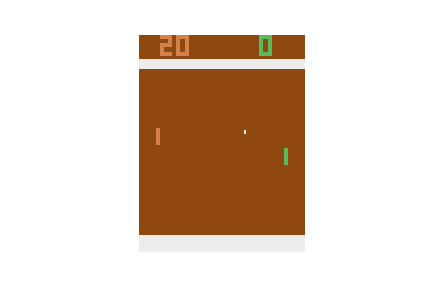
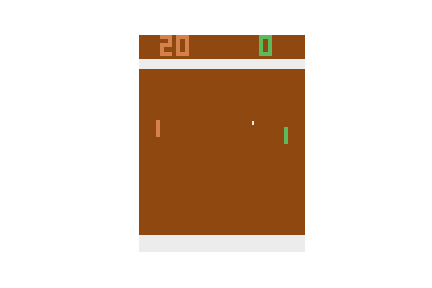
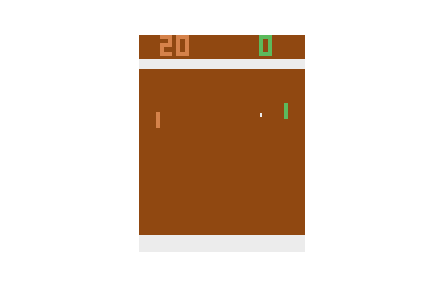
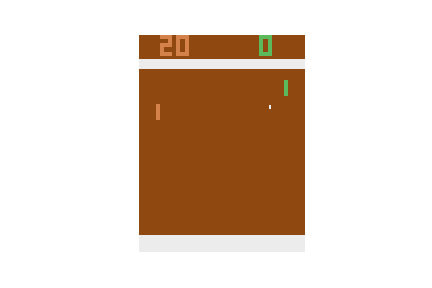
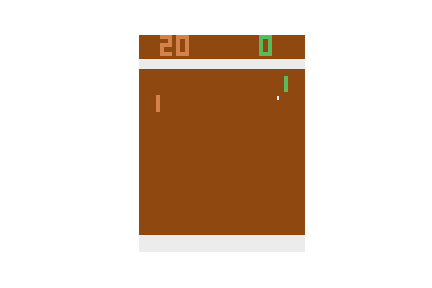
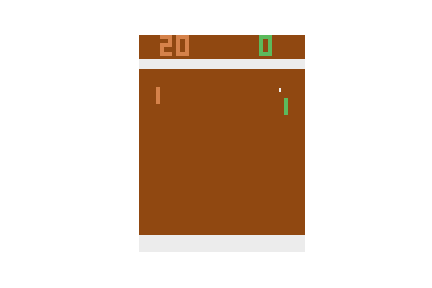
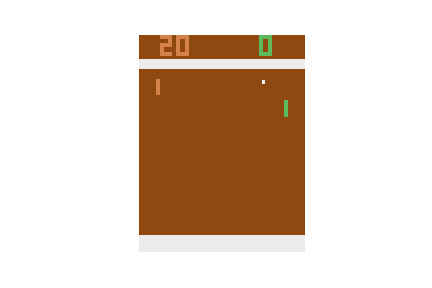
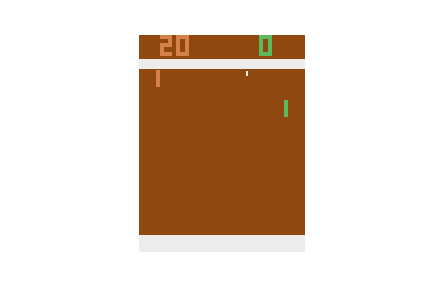
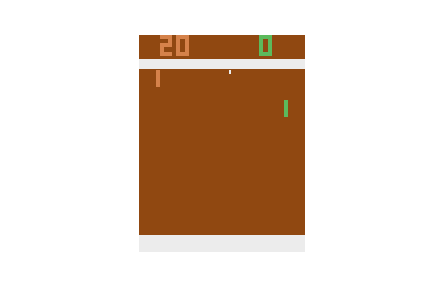
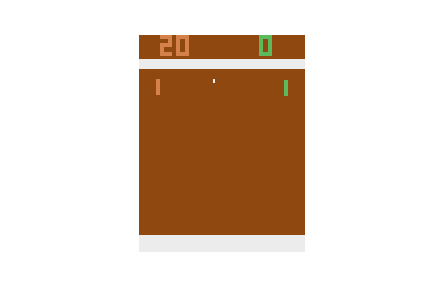
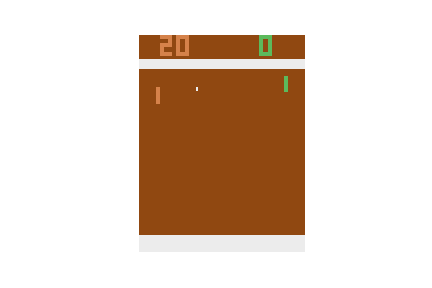
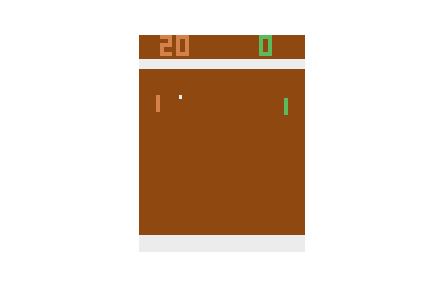
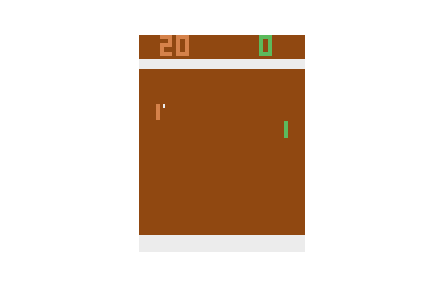
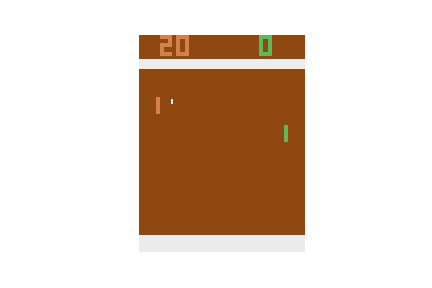
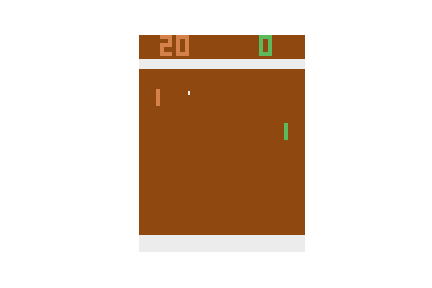
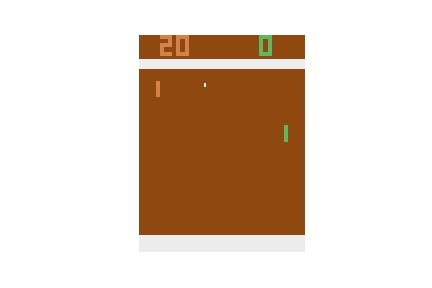
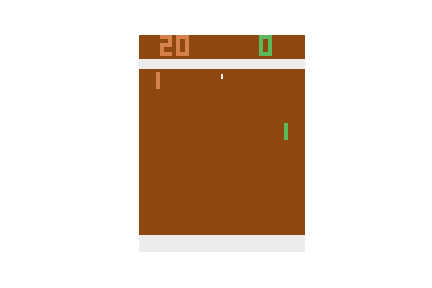
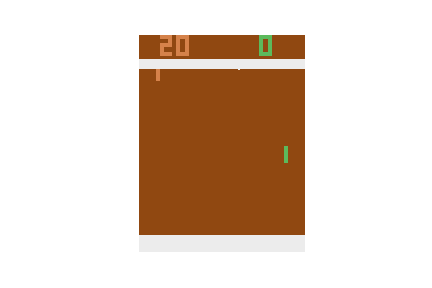
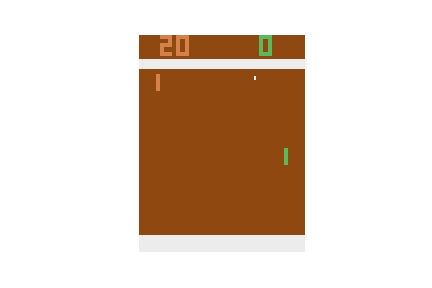
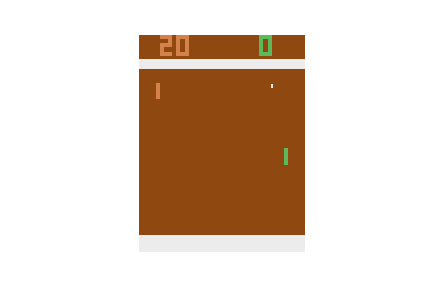
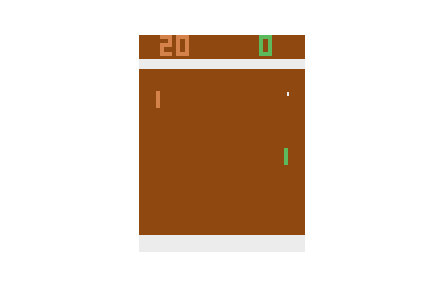
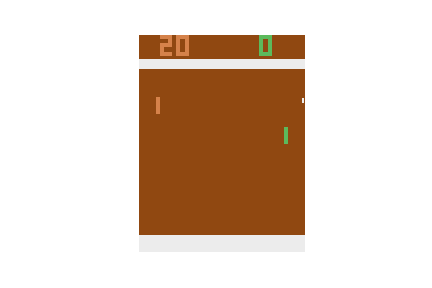

In [10]:
# play game after training!
pong_utils.play(env, policy, time=2000)

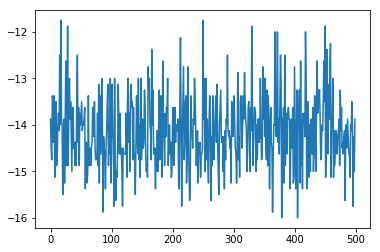

In [11]:
plt.plot(mean_rewards)

In [12]:
# save your policy!
torch.save(policy, 'REINFORCE.policy')

# load your policy if needed
# policy = torch.load('REINFORCE.policy')

# try and test out the solution!
# policy = torch.load('PPO_solution.policy')